# Environment and Data Utils

In [3]:
from typing import List, Dict, Tuple
from scipy.ndimage import gaussian_filter
from scipy.linalg import svd, sqrtm, inv, cholesky, cho_factor, cho_solve
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.linalg import svd
from scipy import stats
import os
import numpy as np
import random

import scipy
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import random
import pickle as pkl

from math import floor
from scipy.ndimage import gaussian_filter

from PIL import Image
from glob import glob
import pandas as pd
from pathlib import Path

np.random.seed(2023)
random.seed(2023)


In [4]:
# Hardcoded values from the config
config = {
"sample_size" : 10000,
# TODO: perhaps increase to 25 at the end
"num_experiments" : 1, 
"image_shape" : [8, 8],
"image_scale" : 1,
"mean_data" : 0,
"var_data" : 0.5,
"smoothing_sigma" : 3,
"manipulation" : 1.0,
"pattern_scale": 1,
"whitening_methods" : ["symmetric_orthogonalization", "sphering", "partial_regression", "cholesky_whitening", "optimal_signal_preserving_whitening"],

"positions" : [[1, 1], [4, 5]],
"patterns" : ["t", "l"],

"parameterizations" : { 
    "linear": {
      "scenario": "linear",
      "manipulation_type": "additive",
      "pattern_scales": [1],
      "snrs": [[0.18],[0.0125]]
    },
    "multiplicative": {
      "scenario": "multiplicative",
      "manipulation_type": "multiplicative",
      "pattern_scales": [1],
      "snrs": [[0.7],[0.1]]
    },
    "translations_rotations": {
      "scenario": "translations_rotations",
      "manipulation_type": "additive",
      "pattern_scales": [1],
      "snrs": [[0.65],[0.2]]
    },
    "xor": {
      "scenario": "xor",
      "manipulation_type": "additive",
      "pattern_scales": [1],
      "snrs": [[0.35],[0.15]]
    }
}
}

def normalise_data(patterns: np.array, backgrounds: np.array) -> Tuple[np.array, np.array]:
    patterns /= np.linalg.norm(patterns, ord='fro')
    d_norm = np.linalg.norm(backgrounds, ord='fro')
    distractor_term = backgrounds if 0 == d_norm else backgrounds / d_norm
    return patterns, distractor_term

def scale_to_bound(row, scale):
    return row * scale

def regularize_cov(cov, threshold=1e-16, increase_factor=1):
    eigs = np.linalg.eigvalsh(cov)
    
    min_eig = np.min(eigs)
    
    # If the smallest eigenvalue is negative or very close to zero
    if min_eig < threshold:
        # Increase the regularization threshold
        new_threshold = threshold * increase_factor
        # Add a value slightly larger than the absolute minimum eigenvalue to the diagonal
        regularizer = abs(min_eig) + new_threshold
        print(f"Added regularization: {regularizer}")
        cov += np.eye(cov.shape[0]) * regularizer
    
    return cov

def generate_backgrounds(sample_size: int, mean_data: int, var_data: float, image_shape: list=[8,8]) -> np.array:
    backgrounds = np.zeros((sample_size, image_shape[0] * image_shape[1]))

    for i in range(sample_size):
        samples = np.random.normal(mean_data, var_data, size=image_shape)
        backgrounds[i] = np.reshape(samples, (image_shape[0] * image_shape[1]))   

    return backgrounds

def get_patterns(params: Dict) -> List:
    manip = params['manipulation']
    scale = params['pattern_scale']
    t = np.array([
            [manip,0],
            [manip,manip],
            [manip,0]
        ])
    
    l = np.array([
            [manip,0],
            [manip,0],
            [manip,manip]
        ])
    
    pattern_dict = {
        't': np.kron(t, np.ones((scale,scale))),
        'l': np.kron(l, np.ones((scale,scale))),
    }

    chosen_patterns = []
    for pattern_name in params['patterns']:
        chosen_patterns.append(pattern_dict[pattern_name])
    return chosen_patterns

def generate_fixed(params: Dict, image_shape: list):
    patterns = np.zeros((params['sample_size'], image_shape[0], image_shape[1]))
    chosen_patterns = get_patterns(params)
    j = 0
    for k, pattern in enumerate(chosen_patterns):
        pos = params['positions'][k]
        for i in range(int(params['sample_size']/len(params['patterns']))):
            patterns[j][pos[0]:pos[0]+pattern.shape[0], pos[1]:pos[1]+pattern.shape[1]] = pattern
            if params['pattern_scale'] > 3:
                patterns[j] = gaussian_filter(patterns[j], 1.5)
            j+=1 

    return np.reshape(patterns, (params['sample_size'], image_shape[0] * image_shape[1]))

def generate_translations_rotations(params: Dict, image_shape: list) -> np.array:
    patterns = np.zeros((params['sample_size'], image_shape[0], image_shape[1]))    
    chosen_patterns = get_patterns(params)

    j = 0
    for pattern in chosen_patterns:
        for i in range(int(params['sample_size']/len(params['patterns']))):                        
            pattern_adj = pattern

            rand = np.random.randint(0, high=4)
            if rand > 0:
                pattern_adj = np.rot90(pattern, k=rand)
        
            rand_y = np.random.randint(0, high= (image_shape[0])-pattern_adj.shape[0] + 1)
            rand_x = np.random.randint(0, high= (image_shape[0])-pattern_adj.shape[1] + 1)
            pos = (rand_y, rand_x)

            patterns[j][pos[0]:pos[0]+pattern_adj.shape[0], pos[1]:pos[1]+pattern_adj.shape[1]] = pattern_adj
            if params['pattern_scale'] > 3:
                patterns[j] = gaussian_filter(patterns[j], 1.5)
            j+=1     

    return np.reshape(patterns, (params['sample_size'], image_shape[0] * image_shape[1]))

def generate_xor(params: Dict, image_shape: list) -> np.array:
    patterns = np.zeros((params['sample_size'], image_shape[0], image_shape[1]))
    chosen_patterns = get_patterns(params)
    poses = params['positions']

    manips = [
        [1,1],
        [-1,-1],
        [1,-1],
        [-1,1],
    ]

    k = 0
    for ind in range(0, params['sample_size'], int(params['sample_size']/4)):
        pat = np.zeros((image_shape[0], image_shape[1]))
        pat[poses[0][0]:poses[0][0]+chosen_patterns[0].shape[0], poses[0][1]:poses[0][1]+chosen_patterns[0].shape[1]] = chosen_patterns[0] * manips[k][0]
        pat[poses[1][0]:poses[1][0]+chosen_patterns[1].shape[0], poses[1][1]:poses[1][1]+chosen_patterns[1].shape[1]] = chosen_patterns[1] * manips[k][1]
        patterns[ind:ind+int(params['sample_size']/4)] = pat
        k+=1
    
    for j, pattern in enumerate(patterns):
        if params['pattern_scale'] > 3:
            patterns[j] = gaussian_filter(pattern, 1.5)

    return np.reshape(patterns, (params['sample_size'], image_shape[0] * image_shape[1]))


# Whitening Methods

In [5]:
def symmetric_orthogonalise_helper(A, maintainMagnitudes=False, return_W=False):
    L = None
    W = None
    if maintainMagnitudes:
        D = np.sqrt(np.diag(A.T @ A))
        D = np.diag(D)
        if return_W:
            Lnorm, W = symmetric_orthogonalise_helper(A @ D, maintainMagnitudes=False, return_W=True)
            if Lnorm is not None:
                L = Lnorm @ D
                W = D @ W @ D
        else:
            L = symmetric_orthogonalise_helper(A @ D, maintainMagnitudes=False, return_W=False) @ D
            W = None
    else:
        U, S, Vt = np.linalg.svd(A, full_matrices=False)

        tol = max(A.shape) * S[0] * np.finfo(A.dtype).eps
        r = np.sum(S > tol)

        if r >= A.shape[1]:
            L = U @ Vt
            if return_W:
                W = Vt.T @ np.diag(1.0 / S) @ Vt
            else:
                W = None
        else:
            print("Skipping. Matrix is not full rank.")

    return L, W

def symmetric_orthogonalization(X):
    # (n_samples, n_features)
    # Ensure data is zero-centered
    X_centered = X - np.mean(X, axis=0)
    
    # Call the orthogonalization helper on the data matrix itself
    L, P = symmetric_orthogonalise_helper(X_centered, maintainMagnitudes=True, return_W=True)
    if P is not None:
        X_new = (P @ X_centered.T).T 
        return X_new, P
    else:
        print("returning the same X")
        P = np.eye(X.shape[1])  # dummy transformation matrix, note the change to shape[1] assuming X is samples x features
        return X, P

def sphering(X):
    # (n_samples, n_features)
    # Ensure data is zero-centered
    X_centered = X - np.mean(X, axis=0)

    # Compute the covariance matrix
    covariance_matrix = np.cov(X_centered, rowvar = False, bias=True)
    
    # Regularize covariance matrix if necessary
    covariance_matrix = regularize_cov(covariance_matrix)
    
    # Compute inverse square root of covariance matrix
    P = np.linalg.inv(sqrtm(covariance_matrix))

    # Apply the transformation
    X_whitened = np.dot(X_centered, P.T)
    
    return X_whitened, P

def cholesky_whitening(X):
    # Ensure data is zero-centered
    X_centered = X - np.mean(X, axis=0)
    
    # Compute the covariance matrix
    covariance_matrix = np.cov(X_centered, rowvar=False, bias=True)

    # Regularize covariance matrix if necessary
    covariance_matrix = regularize_cov(covariance_matrix)

    # Compute the Cholesky decomposition
    L = np.linalg.cholesky(covariance_matrix)

    # Invert the lower triangular matrix L
    L_inv = np.linalg.inv(L)

    # Apply the transformation
    X_whitened = np.dot(X_centered, L_inv.T)

    return X_whitened, L_inv

def partial_regression(X):
    # (n_samples, n_features)
    # Ensure data is zero-centered
    X_centered = X - np.mean(X, axis=0)

    nsamples, nfeatures = X_centered.shape
    X_whitened = np.empty_like(X_centered)
    for ii in range(nfeatures):
        xin = X[:, ii]
        xout = X[:, [j for j in range(nfeatures) if j != ii]]
        
        # Compute the weights to regress xin on xout
        weights = np.linalg.pinv(xout) @ xin
        
        # Compute the residuals of the regression
        residuals = xin - xout @ weights
        
        X_whitened[:, ii] = residuals
        
    P = np.eye(nfeatures)  # dummy transformation matrix
    return X_whitened, P

def optimal_signal_preserving_whitening(X):
    # (n_samples, n_features)
    # Ensure data is zero-centered
    X_centered = X - np.mean(X, axis=0)
    
    # Compute the correlation matrix of X's transpose
    corr = np.corrcoef(X_centered, rowvar=False, bias=True)
    
    # Regularize correlation matrix if necessary
    corr = regularize_cov(corr)
    
    # Compute transformation matrix P
    P = np.linalg.inv(sqrtm(corr)) @ np.diag(1 / np.sqrt(np.var(X_centered, axis=0)))
    
    # Apply the transformation
    X_whitened = np.dot(X_centered, P.T)
    
    
    return X_whitened, P

In [6]:
# def pca_whitening(X):
#     # Center the data
#     X_centered = X - np.mean(X, axis=0)

#     # Compute the covariance matrix
#     covariance_matrix = np.dot(X_centered.T, X_centered) / X_centered.shape[0]

#     # Eigenvalue decomposition
#     eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

#     # Perform whitening
#     X_whitened = X_centered @ eigenvectors @ np.diag(1.0/np.sqrt(eigenvalues + 1e-5))
    
#     return X_whitened, eigenvectors, eigenvalues

# def qr_decomposition(X):
#     Q, R = np.linalg.qr(X)
#     return Q, R

## Dummy data method validation

In [7]:
def generate_data(nsamples, nfeatures):
    """
    Generate synthetic data with correlated features.
    """
    M = np.random.randn(nfeatures, nfeatures)
    X = M @ np.random.randn(nfeatures, nsamples)**2
    X = X - np.mean(X, axis=1, keepdims=True)
    return X.T

def plot_correlation_matrix(corr, title):
    fig, ax = plt.subplots()
    cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    plt.title(title, pad=20)
    plt.show()

methods = [
    symmetric_orthogonalization,
    sphering,
    cholesky_whitening,
    partial_regression,
    optimal_signal_preserving_whitening
]

def validate_whitening(X, methods):
       # Plot correlation matrix of original data
    plot_correlation_matrix(np.corrcoef(X.T), "Correlation Matrix of Original Data")

    fig_corr, axs_corr = plt.subplots(1, 5, figsize=(20, 4))
    fig_corr.suptitle('Correlation Matrices of Whitened Data')
    fig_sim, axs_sim = plt.subplots(1, 5, figsize=(20, 4))
    fig_sim.suptitle('Similarity between Original and Whitened Data')

    for i, method in enumerate(methods):
        X_whitened, P = method(X)
        corr = np.corrcoef(X_whitened.T)

        # Plot correlation matrix of whitened data
        cax_corr = axs_corr[i].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
        axs_corr[i].set_title(method.__name__)

        corr_original_whitened = np.corrcoef(X.T, X_whitened.T)

        num_features = X.shape[1]
        corr_original_whitened = corr_original_whitened[:num_features, num_features:]  # extract the off-diagonal block

        # Plot similarity between original and whitened data
        cax_sim = axs_sim[i].matshow(corr_original_whitened, cmap='coolwarm', vmin=-1, vmax=1)
        axs_sim[i].set_title(method.__name__)

    fig_corr.colorbar(cax_corr, ax=axs_corr.ravel().tolist(), shrink=0.6)
    fig_sim.colorbar(cax_sim, ax=axs_sim.ravel().tolist(), shrink=0.6)
    plt.show()

    # Save to file
    # np.savetxt('data.csv', X, delimiter=',')

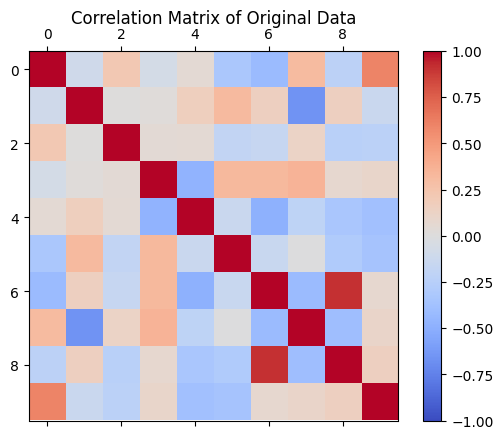

/Users/stoyankaras/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:115: DeprecationWarning: bias and ddof have no effect and are deprecated


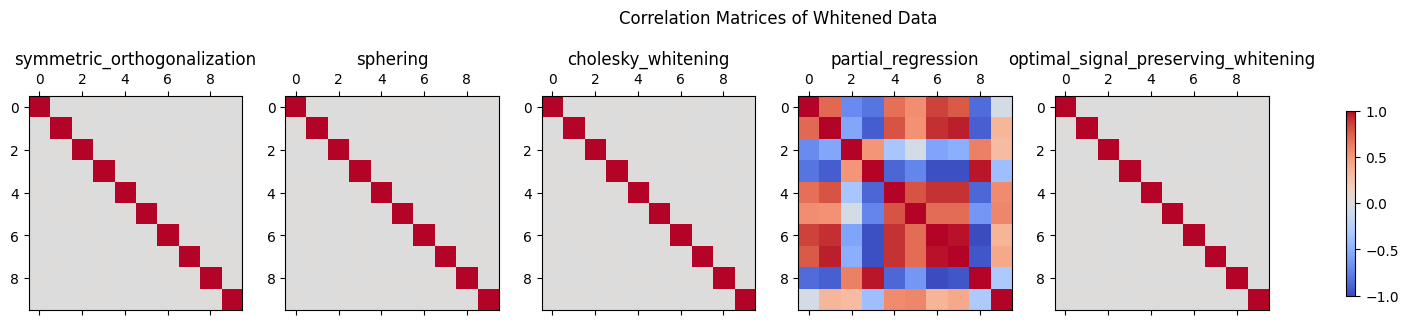

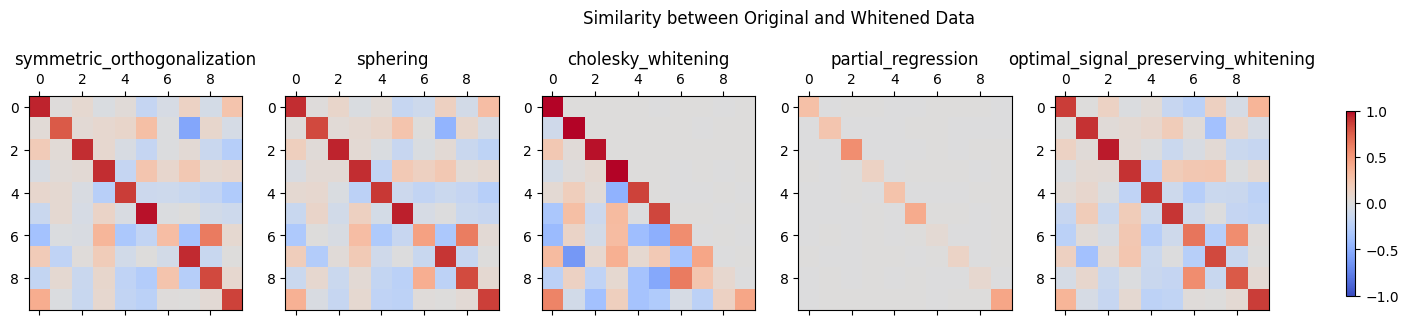

In [8]:
X = generate_data(1000, 10)
validate_whitening(X, methods)

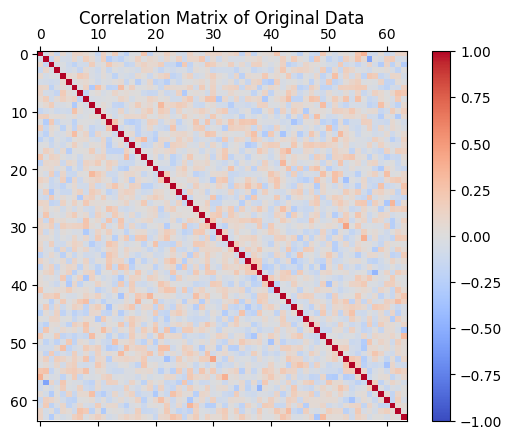

/Users/stoyankaras/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:115: DeprecationWarning: bias and ddof have no effect and are deprecated


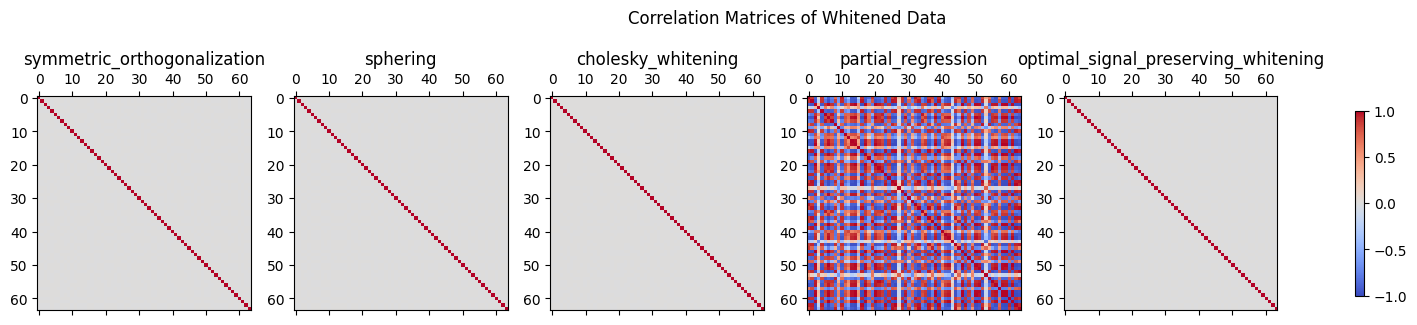

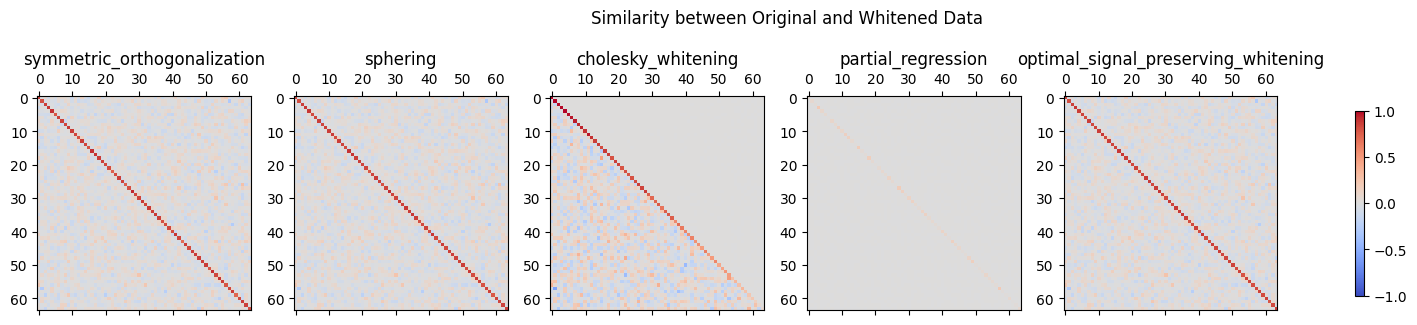

In [9]:
Y = generate_data(10000, 64)
validate_whitening(Y, methods)

In [10]:
def calculate_mean_values(corr_matrix):
    # Assuming the correlation matrix is square
    diagonal = np.diagonal(corr_matrix)
    mean_diagonal = np.mean(diagonal)

    off_diagonal = corr_matrix[~np.eye(corr_matrix.shape[0], dtype=bool)].reshape(-1)
    mean_off_diagonal = np.mean(off_diagonal)

    return mean_diagonal, mean_off_diagonal

def create_summary_table(X, methods):
    summary = {
        "Method": ["Original"] + [method.__name__ for method in methods],
        "Mean Diagonal": [],
        "Mean Off-Diagonal": []
    }

    # Original data
    corr_original = np.corrcoef(X.T)
    mean_diagonal, mean_off_diagonal = calculate_mean_values(corr_original)
    summary["Mean Diagonal"].append(mean_diagonal)
    summary["Mean Off-Diagonal"].append(mean_off_diagonal)

    # Whitened data
    for method in methods:
        X_whitened, P = method(X)
        corr_whitened = np.corrcoef(X_whitened.T)
        mean_diagonal, mean_off_diagonal = calculate_mean_values(corr_whitened)
        summary["Mean Diagonal"].append(mean_diagonal)
        summary["Mean Off-Diagonal"].append(mean_off_diagonal)

    summary_df = pd.DataFrame(summary)
    return summary_df

In [11]:
summary_table = create_summary_table(X, methods)
print(summary_table)

                                Method  Mean Diagonal  Mean Off-Diagonal
0                             Original            1.0      -3.863844e-02
1          symmetric_orthogonalization            1.0      -5.485128e-16
2                             sphering            1.0      -2.743978e-17
3                   cholesky_whitening            1.0       7.799243e-16
4                   partial_regression            1.0       5.284365e-02
5  optimal_signal_preserving_whitening            1.0      -1.596353e-15


/Users/stoyankaras/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:115: DeprecationWarning: bias and ddof have no effect and are deprecated


In [12]:
summary_table = create_summary_table(Y, methods)
print(summary_table)

                                Method  Mean Diagonal  Mean Off-Diagonal
0                             Original            1.0      -7.923255e-04
1          symmetric_orthogonalization            1.0       2.224552e-16
2                             sphering            1.0      -3.726269e-15
3                   cholesky_whitening            1.0       2.755092e-16
4                   partial_regression            1.0      -2.553632e-03
5  optimal_signal_preserving_whitening            1.0      -4.131422e-15


/Users/stoyankaras/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:115: DeprecationWarning: bias and ddof have no effect and are deprecated


# Tetris Data Generation & Validation


In [13]:
whitening_methods = {
    "cholesky_whitening": cholesky_whitening,
    "optimal_signal_preserving_whitening": optimal_signal_preserving_whitening,
    "symmetric_orthogonalization": symmetric_orthogonalization,
    "sphering": sphering,
    "partial_regression": partial_regression,
}

scenario_dict = {
    'linear': generate_fixed,
    'multiplicative': generate_fixed,
    'translations_rotations': generate_translations_rotations,
    'xor': generate_xor
}

captured_data = {
}
    
# TODO - do the backtransformations too

def whitened_data_generation(config: Dict, save_dir: str = '/Users/stoyankaras/Desktop/thesis/xai-tris/notebooks/data'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    image_shape = np.array(config["image_shape"]) * config["image_scale"]

    for i in range(config['num_experiments']): 
        backgrounds = generate_backgrounds(config['sample_size'], config['mean_data'], config['var_data'], image_shape)
        
        for scenario, params in config['parameterizations'].items():

            for pattern_scale in params['pattern_scales']:

                config['pattern_scale'] = pattern_scale

                patterns = scenario_dict.get(scenario)(params=config, image_shape=list(image_shape))

                for correlated in ['uncorrelated', 'correlated']:
    
                    copy_backgrounds = np.zeros((config['sample_size'], image_shape[0] * image_shape[1]))
                    
                    params['correlated_background'] = correlated
                    if correlated == 'correlated':
                        for j, background in enumerate(backgrounds.copy()):
                            copy_backgrounds[j] = gaussian_filter(np.reshape(background, (image_shape[0], image_shape[1])), config['smoothing_sigma']).reshape((image_shape[0] * image_shape[1]))
                        alpha_ind = 1
                    else:
                        copy_backgrounds = backgrounds.copy()
                        alpha_ind = 0

                    for alpha in params['snrs'][alpha_ind]:

                        copy_patterns = patterns.copy()
                        if params['manipulation_type'] == 'multiplicative':
                            copy_patterns = 1 - alpha * copy_patterns

                        normalised_patterns, normalised_backgrounds = normalise_data(copy_patterns, copy_backgrounds)

                        if params['manipulation_type'] == 'multiplicative':
                            x = normalised_patterns * normalised_backgrounds
                        else:
                            x = alpha * normalised_patterns.copy() + (1 - alpha) * normalised_backgrounds.copy()
                        
                        scale = 1 / np.max(np.abs(x))
                        x = np.apply_along_axis(scale_to_bound, 1, x, scale)
                        
                        captured_data[f'experiment_{i}_pattern_plus_background_{scenario}_{correlated}_alpha={alpha}'] = x.copy()

                        for method in config["whitening_methods"]:
                            whitened_x, _ = whitening_methods[method](x.copy())

                            # TODO????????????: scale between -1 and 1 again
                            scale_whitened = 1 / np.max(np.abs(whitened_x))
                            whitened_x = np.apply_along_axis(scale_to_bound, 1, whitened_x, scale_whitened)
                            
                            captured_data[f'experiment_{i}_whitened_{method}_{scenario}_{correlated}_alpha={alpha}'] = whitened_x.copy()
                            
                            # After generating all data for a specific configuration, save it
                            for key, data in captured_data.items():
                                filename = f"{key}.npy"
                                file_path = os.path.join(save_dir, filename)
                                with open(file_path, 'wb') as f:
                                    np.save(f, data)
                           
whitened_data_generation(config)
for key, value in captured_data.items():
    print(key, value.shape)

/Users/stoyankaras/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:115: DeprecationWarning: bias and ddof have no effect and are deprecated


Added regularization: 1.4139491005937534e-16
Added regularization: 1.4139491005937534e-16
Added regularization: 1.2837120994170152e-15
Added regularization: 1.2099579148608902e-16
Added regularization: 1.2099579148608902e-16
Added regularization: 8.717305801416354e-16
Added regularization: 1.5300995351263304e-16
Added regularization: 1.5300995351263304e-16
Added regularization: 1.0198057324176874e-15
experiment_0_pattern_plus_background_linear_uncorrelated_alpha=0.18 (10000, 64)
experiment_0_whitened_symmetric_orthogonalization_linear_uncorrelated_alpha=0.18 (10000, 64)
experiment_0_whitened_sphering_linear_uncorrelated_alpha=0.18 (10000, 64)
experiment_0_whitened_partial_regression_linear_uncorrelated_alpha=0.18 (10000, 64)
experiment_0_whitened_cholesky_whitening_linear_uncorrelated_alpha=0.18 (10000, 64)
experiment_0_whitened_optimal_signal_preserving_whitening_linear_uncorrelated_alpha=0.18 (10000, 64)
experiment_0_pattern_plus_background_linear_correlated_alpha=0.0125 (10000, 64)


In [14]:
def compute_data_properties(data):
    properties = {}
    
    # Rank
    properties["rank"] = np.linalg.matrix_rank(data)
    
    # Condition Number
    covariance_matrix = np.cov(data, rowvar=False, bias=True)
    properties["condition_number"] = np.linalg.cond(covariance_matrix)
    
    # Eigenvalues
    eigenvalues, _ = np.linalg.eigh(covariance_matrix)
    properties["min_eigenvalue"] = np.min(eigenvalues)
    properties["max_eigenvalue"] = np.max(eigenvalues)
    
    # Mean & Variance
    properties["mean"] = np.real(np.mean(data))
    properties["variance"] = np.var(data)
    
    return properties

data_properties = {}
for key, value in captured_data.items():
    if ("pattern_plus_background" in key): continue
    if ("uncorrelated" in key): continue
    data_properties[key] = compute_data_properties(value)

# data_properties

In [15]:
data_properties = {key: compute_data_properties(value) for key, value in captured_data.items() if "uncorrelated" not in key }

df_properties = pd.DataFrame(data_properties).T
df_properties

rank  condition_number  \
experiment_0_pattern_plus_background_linear_cor...  64.0      2.365994e+18   
experiment_0_whitened_symmetric_orthogonalizati...  64.0      2.137057e+00   
experiment_0_whitened_sphering_linear_correlate...  64.0      2.842459e+04   
experiment_0_whitened_partial_regression_linear...  64.0      1.281191e+18   
experiment_0_whitened_cholesky_whitening_linear...  64.0      2.568610e+04   
experiment_0_whitened_optimal_signal_preserving...  64.0      9.264804e+03   
experiment_0_pattern_plus_background_multiplica...  64.0      2.994917e+17   
experiment_0_whitened_symmetric_orthogonalizati...  64.0      2.137056e+00   
experiment_0_whitened_sphering_multiplicative_c...  64.0      5.963794e+03   
experiment_0_whitened_partial_regression_multip...  64.0      6.152201e+20   
experiment_0_whitened_cholesky_whitening_multip...  64.0      6.051244e+03   
experiment_0_whitened_optimal_signal_preserving...  64.0      1.943189e+03   
experiment_0_pattern_plus_background_translatio...  64.0      5.515410e+03   
experiment_0_whitened_symmetric_orthogonalizati...  64.0      1.942480e+00   
experiment_0_whitened_sphering_translations_rot...  64.0      1.000000e+00   
experiment_0_whitened_partial_regression_transl...  64.0      7.422091e+03   
experiment_0_whitened_cholesky_whitening_transl...  64.0      1.000000e+00   
experiment_0_whitened_optimal_signal_preserving...  64.0      1.000000e+00   
experiment_0_pattern_plus_background_xor_correl...  64.0      1.335592e+19   
experiment_0_whitened_symmetric_orthogonalizati...  64.0      2.137057e+00   
experiment_0_whitened_sphering_xor_correlated_a...  64.0      2.986736e+04   
experiment_0_whitened_partial_regression_xor_co...  64.0      8.849633e+13   
experiment_0_whitened_cholesky_whitening_xor_co...  64.0      2.997170e+04   
experiment_0_whitened_optimal_signal_preserving...  64.0      7.333473e+03   

                                                    min_eigenvalue  \
experiment_0_pattern_plus_background_linear_cor...   -1.860946e-16   
experiment_0_whitened_symmetric_orthogonalizati...    2.468899e-02   
experiment_0_whitened_sphering_linear_correlate...    1.952043e-06   
experiment_0_whitened_partial_regression_linear...   -8.392074e-18   
experiment_0_whitened_cholesky_whitening_linear...    1.504305e-06   
experiment_0_whitened_optimal_signal_preserving...    6.051765e-06   
experiment_0_pattern_plus_background_multiplica...   -5.339047e-17   
experiment_0_whitened_symmetric_orthogonalizati...    2.428301e-02   
experiment_0_whitened_sphering_multiplicative_c...    6.285983e-06   
experiment_0_whitened_partial_regression_multip...   -1.715933e-18   
experiment_0_whitened_cholesky_whitening_multip...    6.382996e-06   
experiment_0_whitened_optimal_signal_preserving...    2.429191e-05   
experiment_0_pattern_plus_background_translatio...    2.896614e-04   
experiment_0_whitened_symmetric_orthogonalizati...    1.221067e-02   
experiment_0_whitened_sphering_translations_rot...    2.334888e-02   
experiment_0_whitened_partial_regression_transl...    1.677512e-05   
experiment_0_whitened_cholesky_whitening_transl...    1.661082e-02   
experiment_0_whitened_optimal_signal_preserving...    2.373750e-02   
experiment_0_pattern_plus_background_xor_correl...   -1.264680e-16   
experiment_0_whitened_symmetric_orthogonalizati...    2.647502e-02   
experiment_0_whitened_sphering_xor_correlated_a...    1.597536e-06   
experiment_0_whitened_partial_regression_xor_co...    4.700720e-15   
experiment_0_whitened_cholesky_whitening_xor_co...    1.284851e-06   
experiment_0_whitened_optimal_signal_preserving...    6.696397e-06   

                                                    max_eigenvalue  \
experiment_0_pattern_plus_background_linear_cor...        1.597574   
experiment_0_whitened_symmetric_orthogonalizati...        0.052762   
experiment_0_whitened_sphering_linear_correlate...        0.055486   
experiment_0_whitened_partial_regression_linear...        0.629412   


# Plotting

In [16]:
def plot_average_heatmaps(experiment_number, scenario, background_type, alpha):
    methods = list(whitening_methods.keys())  
    num_methods = len(list(whitening_methods.keys())) + 1 # +1 for the pattern+background

    fig, axs = plt.subplots(1, num_methods, figsize=(4 * num_methods, 4))
    
    # Pattern + Background
    pattern_key = f'experiment_{experiment_number}_pattern_plus_background_{scenario}_{background_type}_alpha={alpha}'
    pattern_data_avg = np.mean(captured_data[pattern_key], axis=0).reshape(8, 8).real  # Take average and then the real part
    sns.heatmap(pattern_data_avg, ax=axs[0], cmap='coolwarm', cbar=True, square=True)
    axs[0].set_title('Pattern + Background (Avg)')

    # Whitening methods
    for i, method in enumerate(methods):
        whitened_key = f'experiment_{experiment_number}_whitened_{method}_{scenario}_{background_type}_alpha={alpha}'
        whitened_data_avg = np.mean(captured_data[whitened_key], axis=0).reshape(8, 8).real  # Take average and then the real part
        sns.heatmap(whitened_data_avg, ax=axs[i + 1], cmap='coolwarm', cbar=True, square=True)
        axs[i + 1].set_title(f'{method} (Avg)')

    plt.tight_layout()
    plt.show()


In [17]:
def plot_heatmaps_for_index(experiment_number, scenario, background_type, alpha, sample_index):
    methods = list(whitening_methods.keys())  
    num_methods = len(list(whitening_methods.keys())) + 1 # +1 for the pattern+background
    num_samples = len(captured_data[f'experiment_{experiment_number}_pattern_plus_background_{scenario}_{background_type}_alpha={alpha}'])

    if sample_index >= num_samples:
        raise ValueError(f"Sample index {sample_index} is out of range for dataset with {num_samples} samples.")

    fig, axs = plt.subplots(1, num_methods, figsize=(4 * num_methods, 4))
    
    # Pattern + Background
    pattern_key = f'experiment_{experiment_number}_pattern_plus_background_{scenario}_{background_type}_alpha={alpha}'

    pattern_data = captured_data[pattern_key][sample_index].reshape(8, 8)

    sns.heatmap(pattern_data, ax=axs[0], cmap='coolwarm', cbar=True, square=True)
    axs[0].set_title('Pattern + Background')

    # Whitening methods
    for i, method in enumerate(methods):
        whitened_key = f'experiment_{experiment_number}_whitened_{method}_{scenario}_{background_type}_alpha={alpha}'
        whitened_data = captured_data[whitened_key][sample_index].reshape(8, 8)
        # Handle complex number issue by taking the real part
        whitened_data = np.real(whitened_data)
        sns.heatmap(whitened_data, ax=axs[i + 1], cmap='coolwarm', cbar=True, square=True)
        axs[i + 1].set_title(f'{method}')

    plt.tight_layout()
    plt.show()

In [18]:
def plot_correlation_matrices(experiment_number, scenario, background_type, alpha):
    methods = list(whitening_methods.keys()) 
    num_methods = len(list(whitening_methods.keys())) + 1 # +1 for the pattern+background
    
    fig, axs = plt.subplots(1, num_methods, figsize=(4 * num_methods, 4))
    
    pattern_key = f'experiment_{experiment_number}_pattern_plus_background_{scenario}_{background_type}_alpha={alpha}'
    
    pattern_data = captured_data[pattern_key]

    sns.heatmap(np.corrcoef(pattern_data, rowvar=False), ax=axs[0], cmap='coolwarm', cbar=True, square=True, vmax=1, vmin=-1)
    axs[0].set_title('Pattern + Background')
    
    for i, method in enumerate(methods):
        whitened_key = f'experiment_{experiment_number}_whitened_{method}_{scenario}_{background_type}_alpha={alpha}'
        whitened_data = captured_data[whitened_key]

        # Handle complex number issue by taking the real part
        whitened_data = np.real(whitened_data)

        sns.heatmap(np.corrcoef(whitened_data, rowvar=False), ax=axs[i + 1], cmap='coolwarm', cbar=True, square=True, vmax=1, vmin=-1)
        axs[i + 1].set_title(f'{method}')
    
    plt.tight_layout()
    plt.show()

In [19]:
def plot_covariance_matrices(experiment_number, scenario, background_type, alpha):
    methods = list(whitening_methods.keys()) 
    num_methods = len(list(whitening_methods.keys())) + 1 # +1 for the pattern+background
    
    fig, axs = plt.subplots(1, num_methods, figsize=(4 * num_methods, 4))
    
    pattern_key = f'experiment_{experiment_number}_pattern_plus_background_{scenario}_{background_type}_alpha={alpha}'
    
    pattern_data = captured_data[pattern_key]
    
    sns.heatmap(np.corrcoef(pattern_data, rowvar=False), ax=axs[0], cmap='coolwarm', cbar=True, square=True)
    axs[0].set_title('Pattern + Background')
    
    for i, method in enumerate(methods):
        whitened_key = f'experiment_{experiment_number}_whitened_{method}_{scenario}_{background_type}_alpha={alpha}'
        whitened_data = captured_data[whitened_key]

        # Handle complex number issue by taking the real part
        whitened_data = np.real(whitened_data)

        sns.heatmap(np.cov(whitened_data, rowvar=False, bias=True), ax=axs[i + 1], cmap='coolwarm', cbar=True, square=True)
        axs[i + 1].set_title(f'{method}')
    
    plt.tight_layout()
    plt.show()

In [20]:
def compute_mean_off_diagonal(correlation_matrix):
    # Get the total sum of the matrix elements
    total_sum = np.sum(correlation_matrix)
    # Get the sum of the diagonal elements
    diagonal_sum = np.sum(np.diag(correlation_matrix))
    # Compute the mean off-diagonal value
    n = correlation_matrix.shape[0]  # Get the dimension of the matrix
    mean_off_diagonal = (total_sum - diagonal_sum) / (n**2 - n)
    return mean_off_diagonal

def get_mean_off_diagonal_values(experiment_number, scenario, background_type, alpha):
    # methods = list(whitening_methods.keys())  # Get the list of whitening methods
    methods = whitening_methods
    mean_off_diagonal_values = {}  # Dictionary to store the mean off-diagonal values
    
    # Get the keys for original, normalized, and pattern data
    pattern_key = f'experiment_{experiment_number}_pattern_plus_background_{scenario}_{background_type}_alpha={alpha}'
    
    # Retrieve the original, normalized, and pattern data
    pattern_data = captured_data[pattern_key]
    
    # Compute the mean off-diagonal values for original, normalized, and pattern data
    mean_off_diagonal_values['Pattern + Background'] = compute_mean_off_diagonal(np.corrcoef(pattern_data, rowvar=False))
    
    # Iterate through each whitening method and compute the mean off-diagonal values
    for method in methods:
        whitened_key = f'experiment_{experiment_number}_whitened_{method}_{scenario}_{background_type}_alpha={alpha}'
        whitened_data = captured_data[whitened_key]
        # Handle complex number issue by taking the real part
        whitened_data = np.real(whitened_data)
        mean_off_diagonal_values[method] = compute_mean_off_diagonal(np.corrcoef(whitened_data, rowvar=False))
    
    return mean_off_diagonal_values

# Call the function to get the mean off-diagonal values
mean_off_diagonal_values1 = get_mean_off_diagonal_values(0, 'translations_rotations', 'correlated', 0.2)
mean_off_diagonal_values2 = get_mean_off_diagonal_values(0, 'multiplicative', 'correlated', 0.1)
mean_off_diagonal_values3 = get_mean_off_diagonal_values(0, 'linear', 'correlated', 0.0125)
mean_off_diagonal_values4 = get_mean_off_diagonal_values(0, 'xor', 'correlated', 0.15)

# Display the mean off-diagonal values in a table
df1 = pd.DataFrame(mean_off_diagonal_values1, index=['Translations Rotations'])
df2 = pd.DataFrame(mean_off_diagonal_values2, index=['Multiplicative'])
df3 = pd.DataFrame(mean_off_diagonal_values3, index=['Linear'])
df4 = pd.DataFrame(mean_off_diagonal_values4, index=['XOR '])

display(df1)
display(df2)
display(df3)
display(df4)


Pattern + Background  cholesky_whitening  \
Translations Rotations              0.609995        1.057355e-17   

                        optimal_signal_preserving_whitening  \
Translations Rotations                         8.458842e-17   

                        symmetric_orthogonalization      sphering  \
Translations Rotations                 4.581873e-17  1.092600e-16   

                        partial_regression  
Translations Rotations           -0.015778

Pattern + Background  cholesky_whitening  \
Multiplicative               0.65181            0.005268   

                optimal_signal_preserving_whitening  \
Multiplicative                             0.002637   

                symmetric_orthogonalization  sphering  partial_regression  
Multiplicative                -5.491861e-10   0.00335           -0.008419

Pattern + Background  cholesky_whitening  \
Linear              0.651949             0.01112   

        optimal_signal_preserving_whitening  symmetric_orthogonalization  \
Linear                             0.005347                 1.161083e-09   

        sphering  partial_regression  
Linear  0.005871            0.026889

Pattern + Background  cholesky_whitening  \
XOR               0.634216            0.010067   

      optimal_signal_preserving_whitening  symmetric_orthogonalization  \
XOR                              0.004863                 3.699094e-09   

      sphering  partial_regression  
XOR   0.005483            0.036978

# translations_rotations


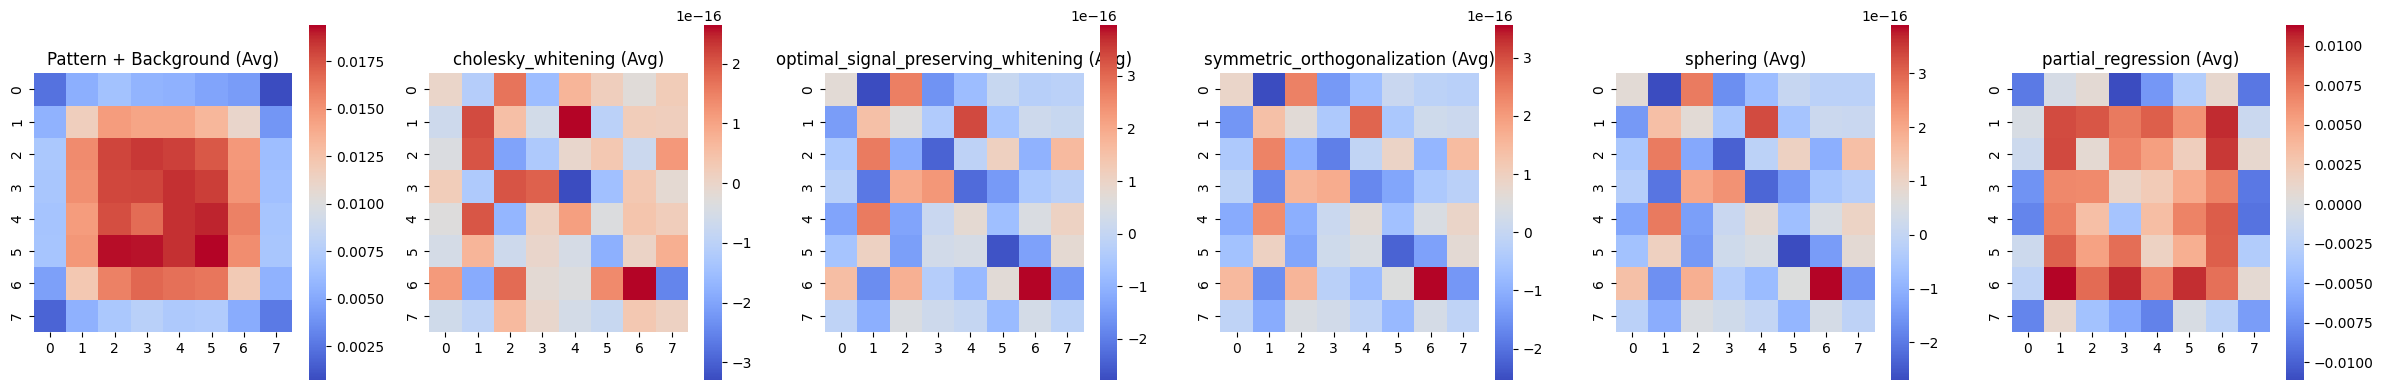

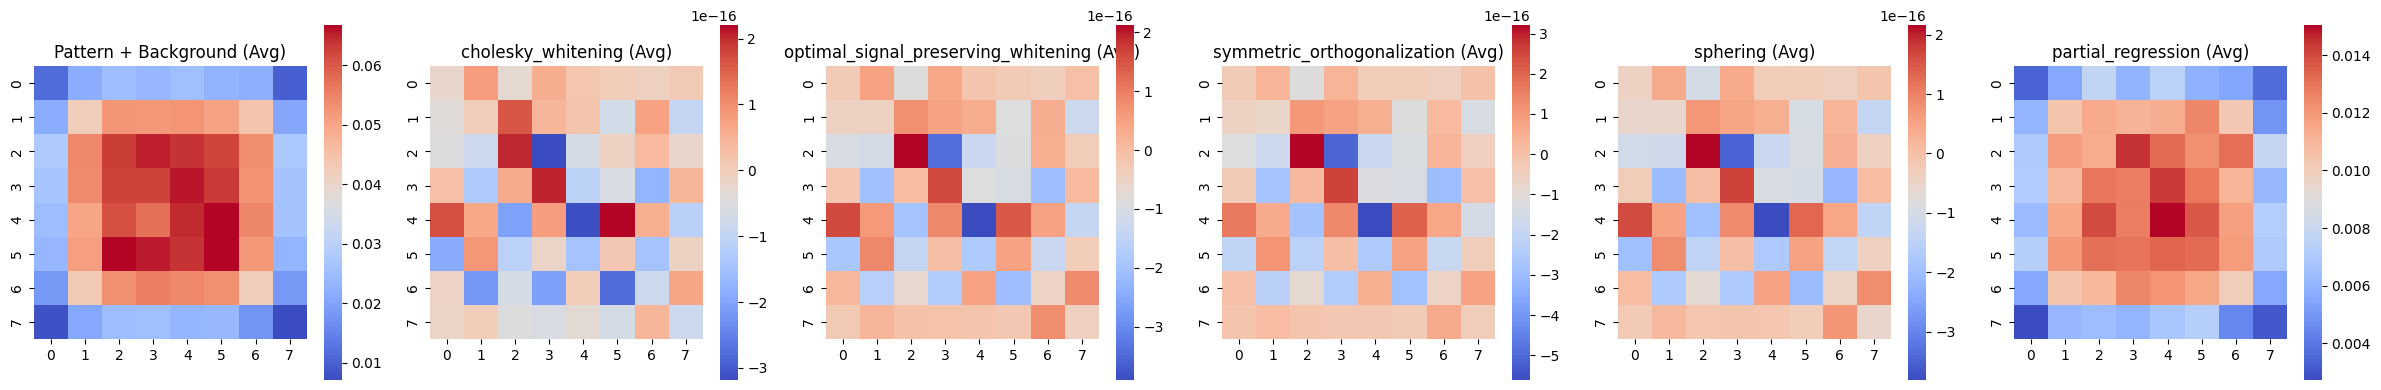

In [21]:
plot_average_heatmaps(0, 'translations_rotations', 'correlated', 0.2)
plot_average_heatmaps(0, 'translations_rotations', 'uncorrelated', 0.65)

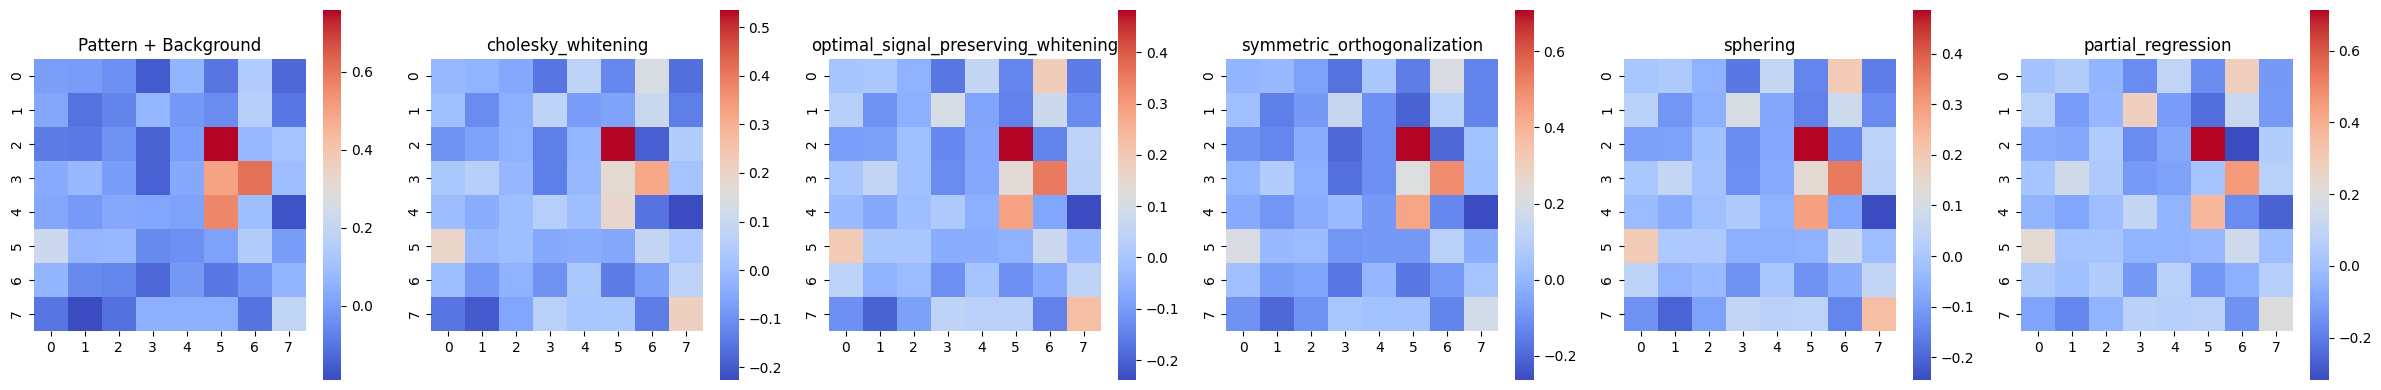

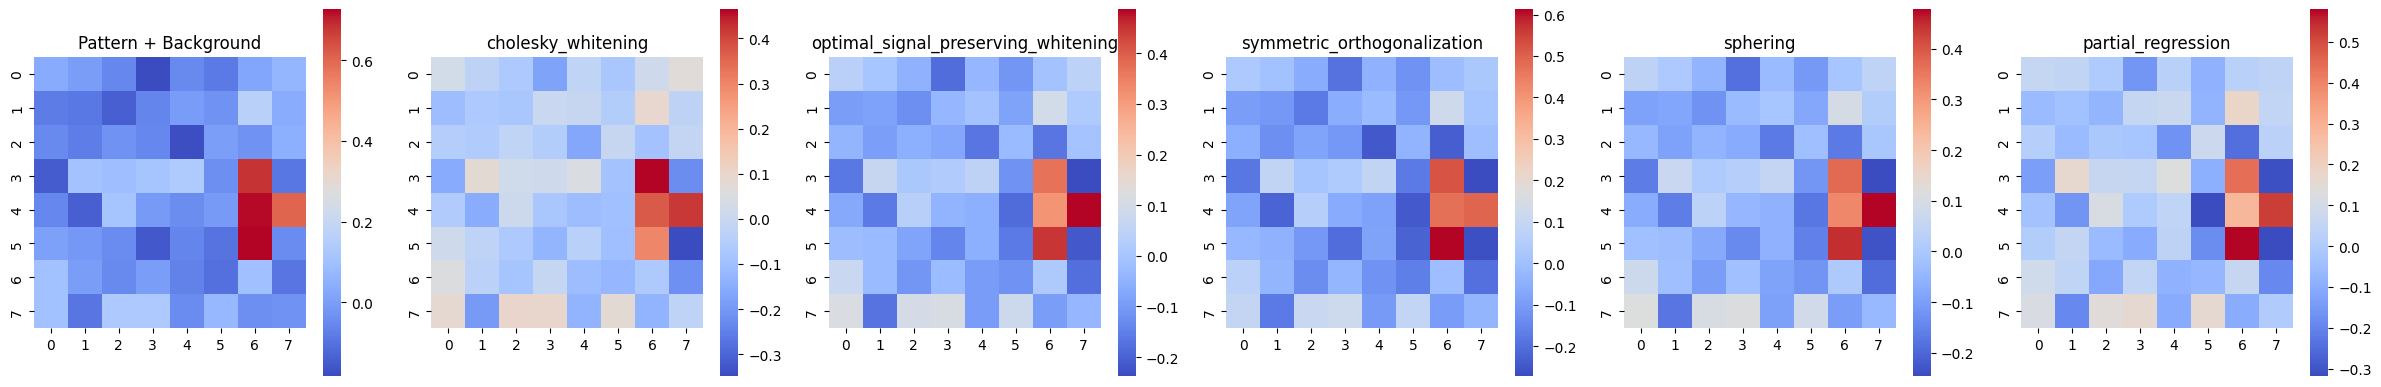

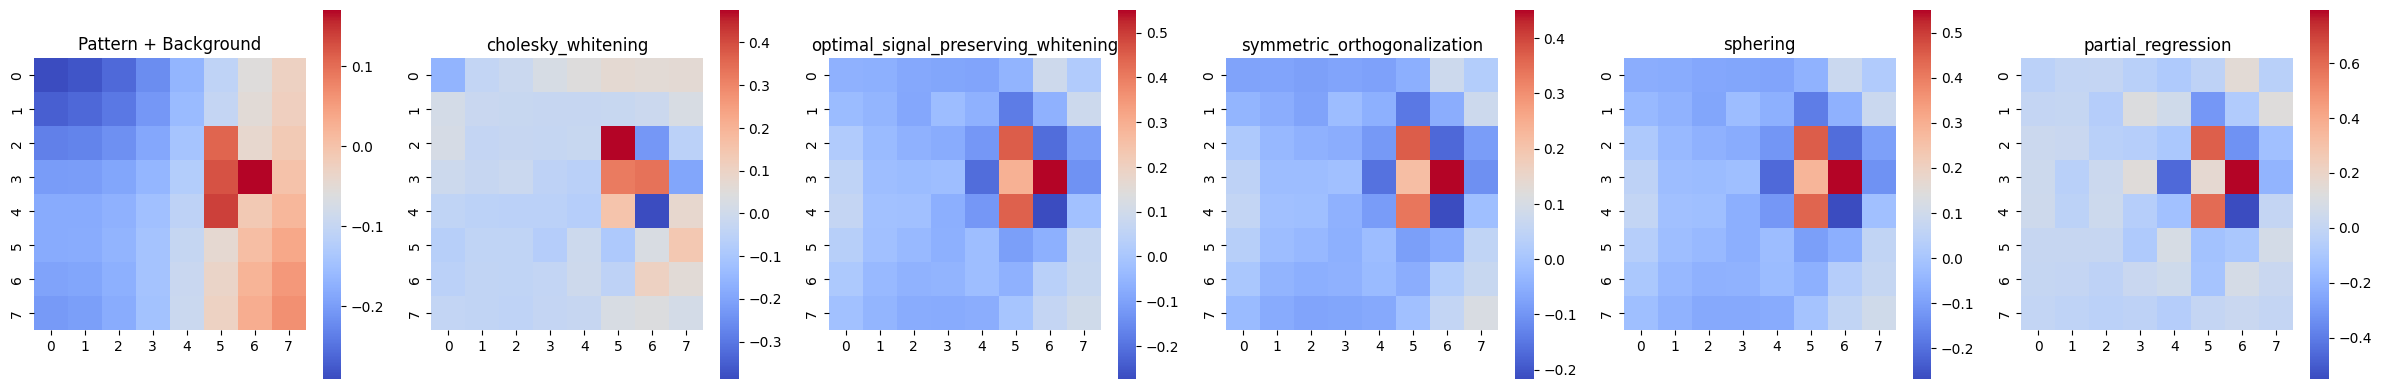

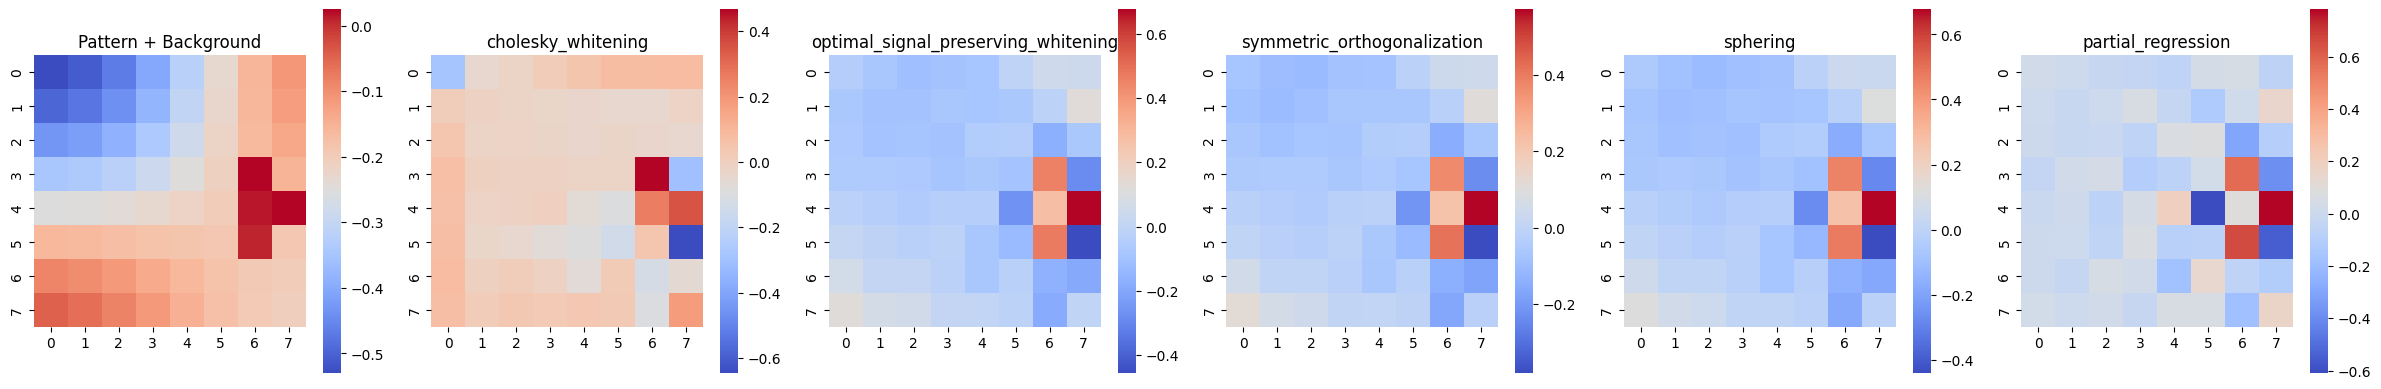

In [22]:
plot_heatmaps_for_index(0,  'translations_rotations', 'uncorrelated', 0.65, 2)
plot_heatmaps_for_index(0,  'translations_rotations', 'uncorrelated', 0.65, 3)
plot_heatmaps_for_index(0,  'translations_rotations', 'correlated', 0.2, 2)
plot_heatmaps_for_index(0,  'translations_rotations', 'correlated', 0.2, 3)

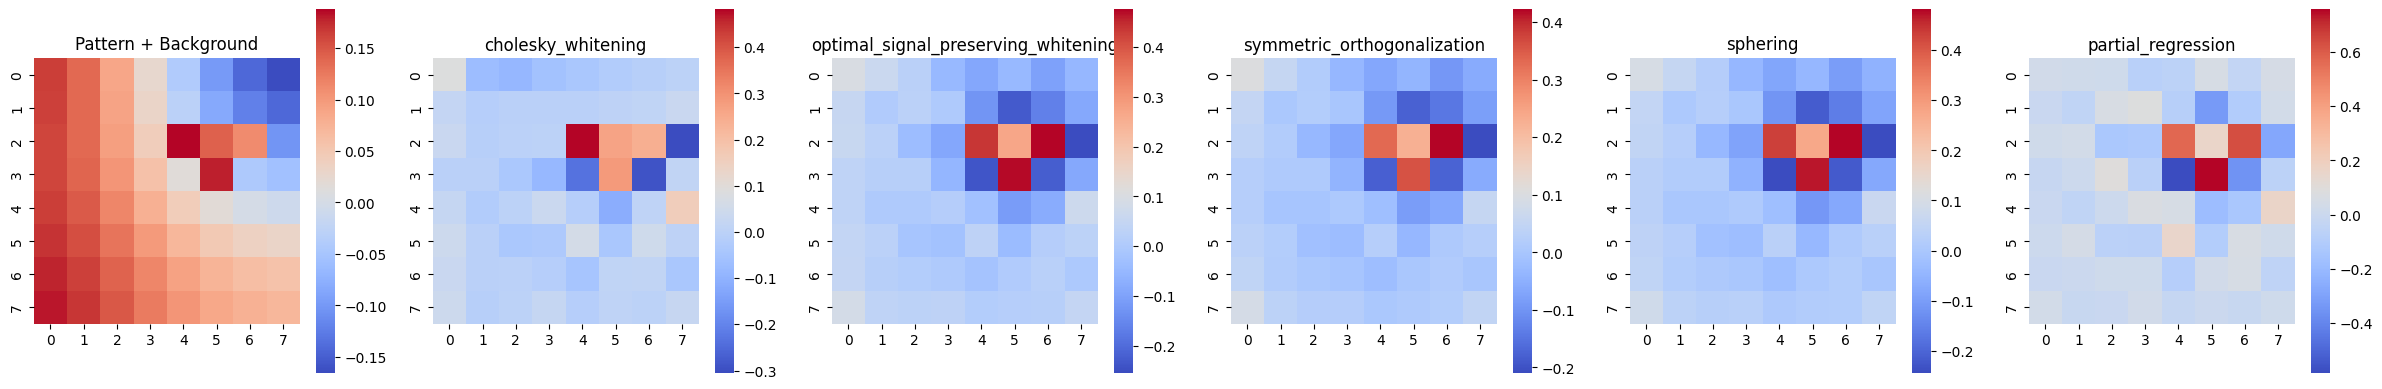

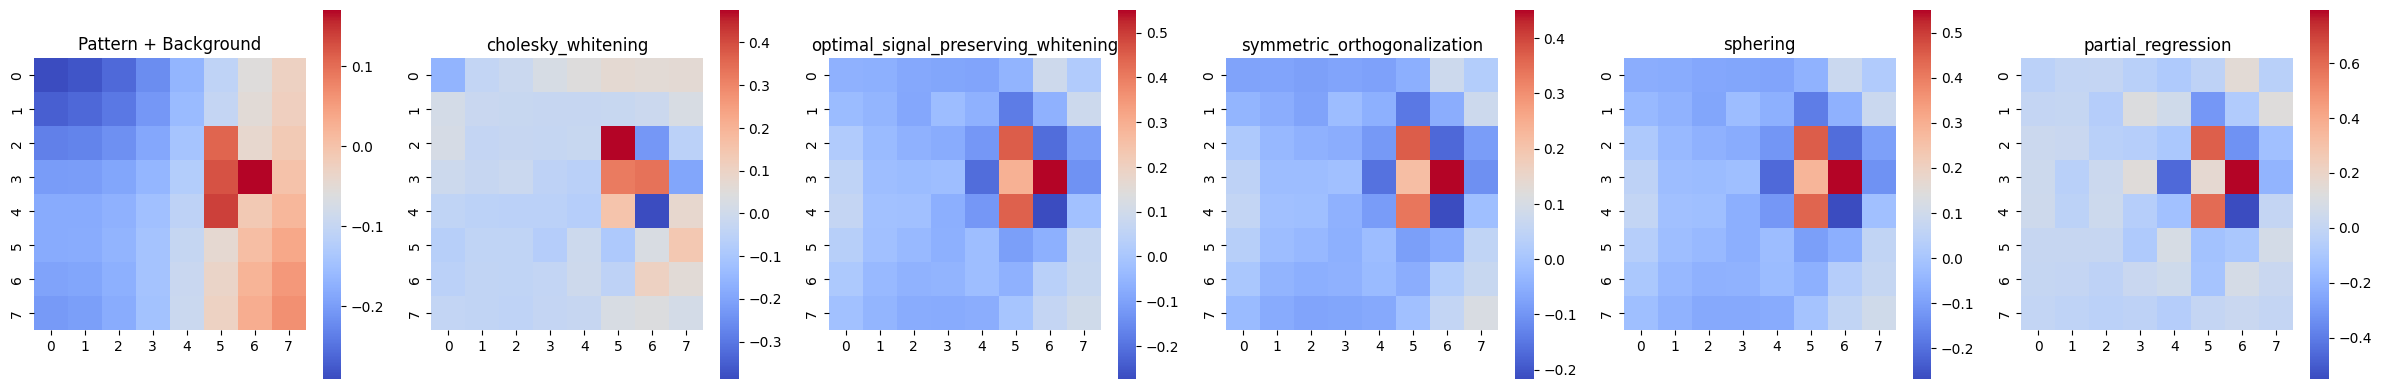

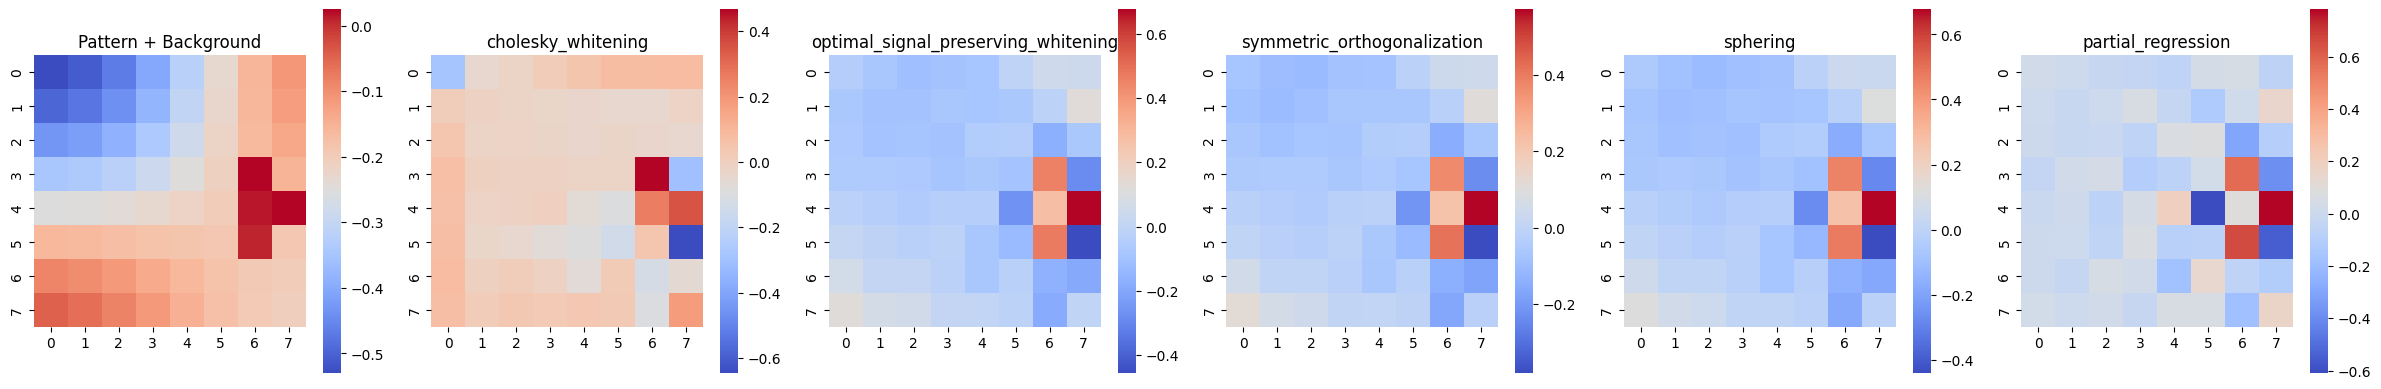

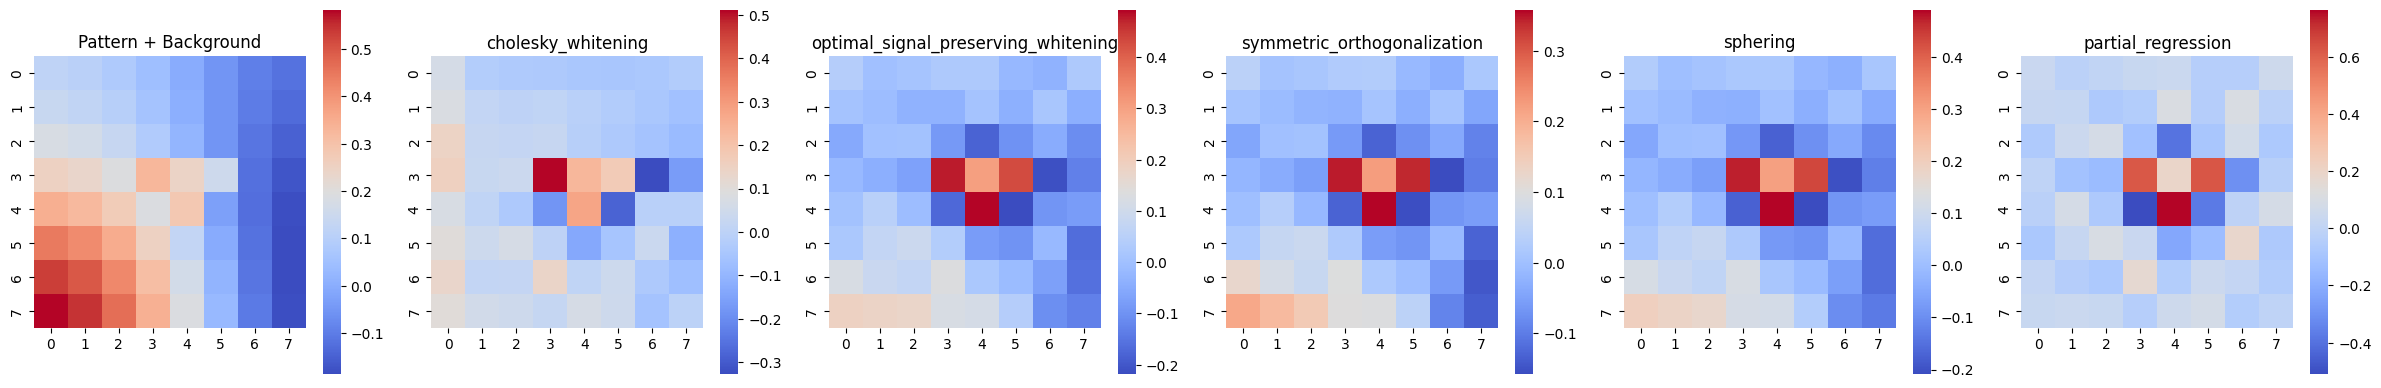

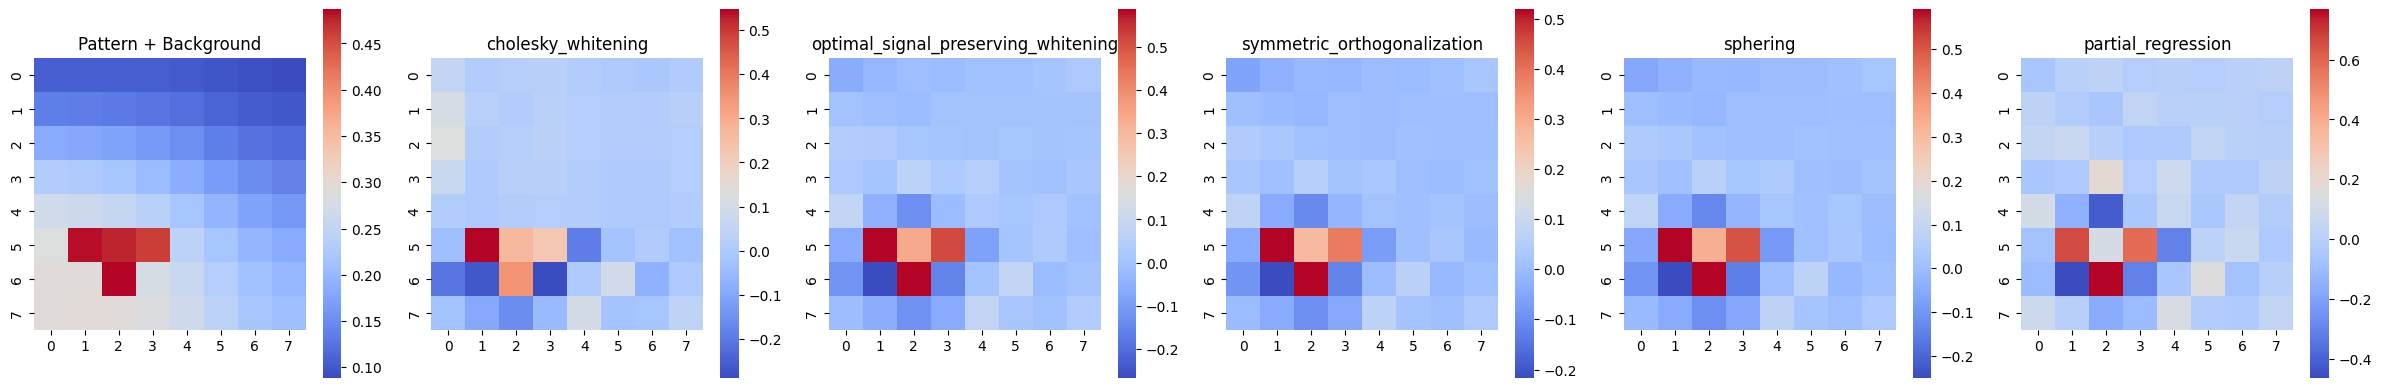

In [23]:
plot_heatmaps_for_index(0,  'translations_rotations', 'correlated', 0.2, 1)
plot_heatmaps_for_index(0,  'translations_rotations', 'correlated', 0.2, 2)
plot_heatmaps_for_index(0,  'translations_rotations', 'correlated', 0.2, 3)
plot_heatmaps_for_index(0,  'translations_rotations', 'correlated', 0.2, 4)
plot_heatmaps_for_index(0,  'translations_rotations', 'correlated', 0.2, 5)

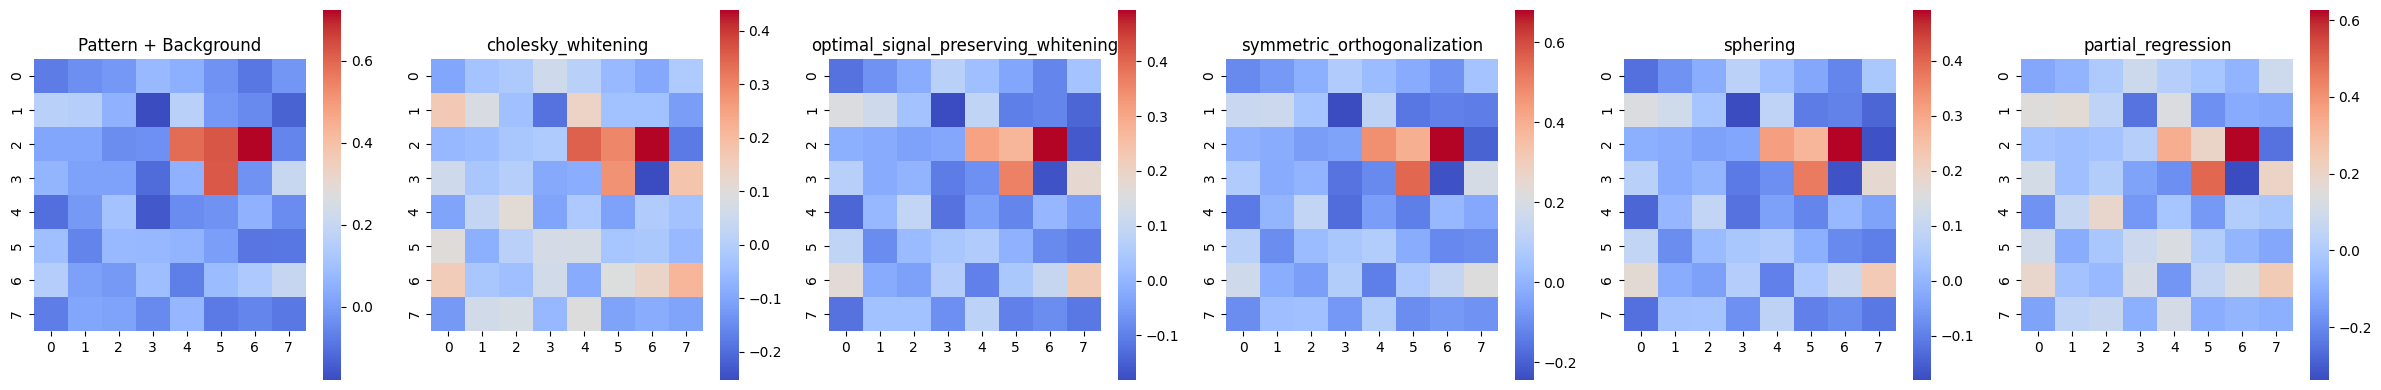

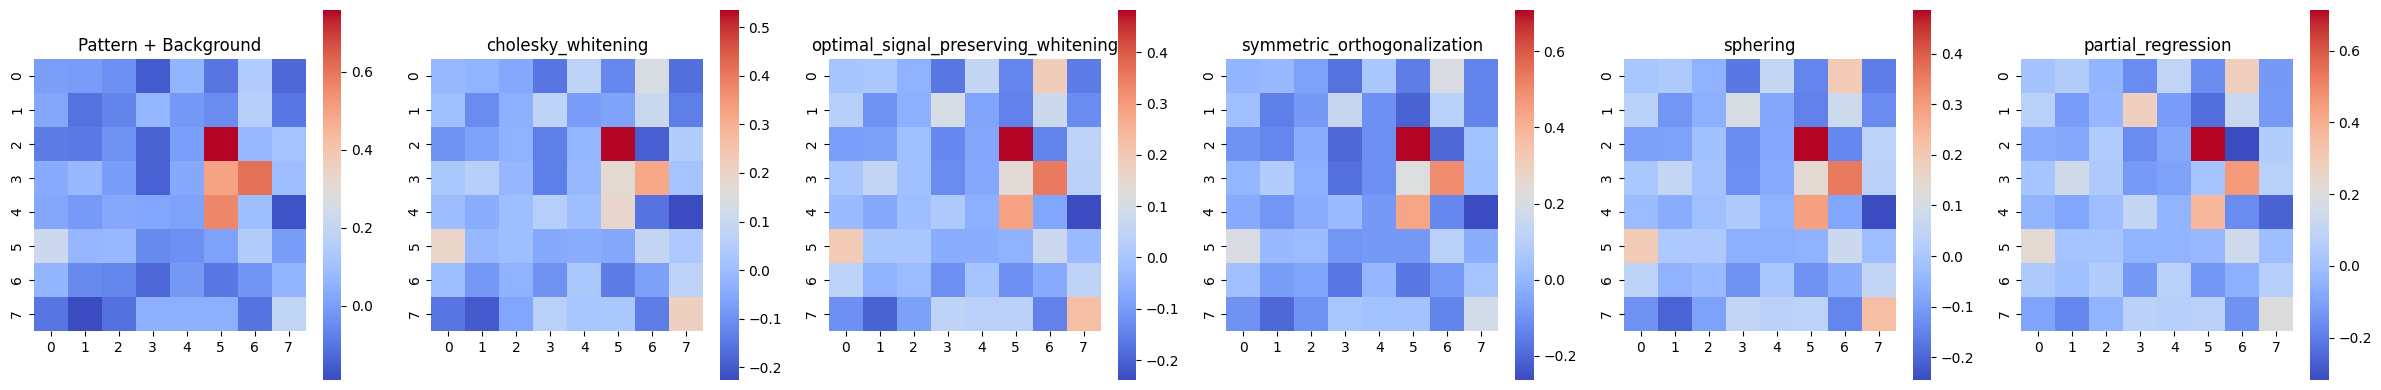

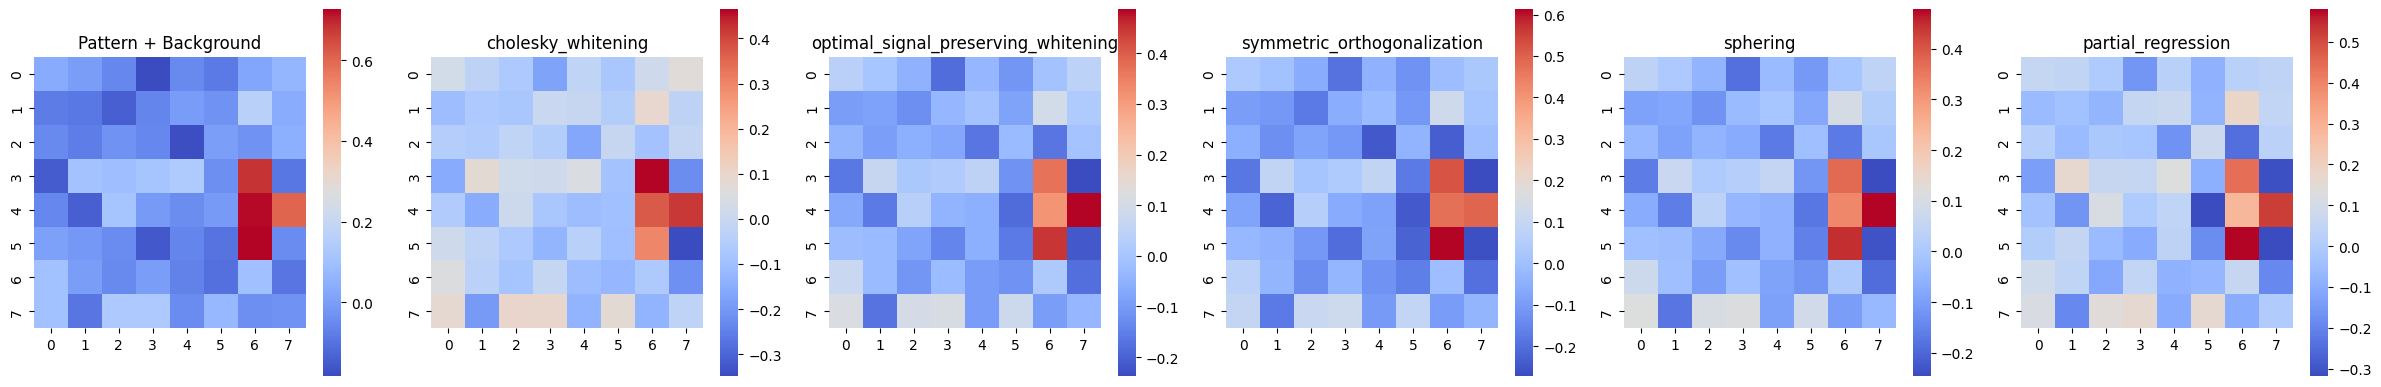

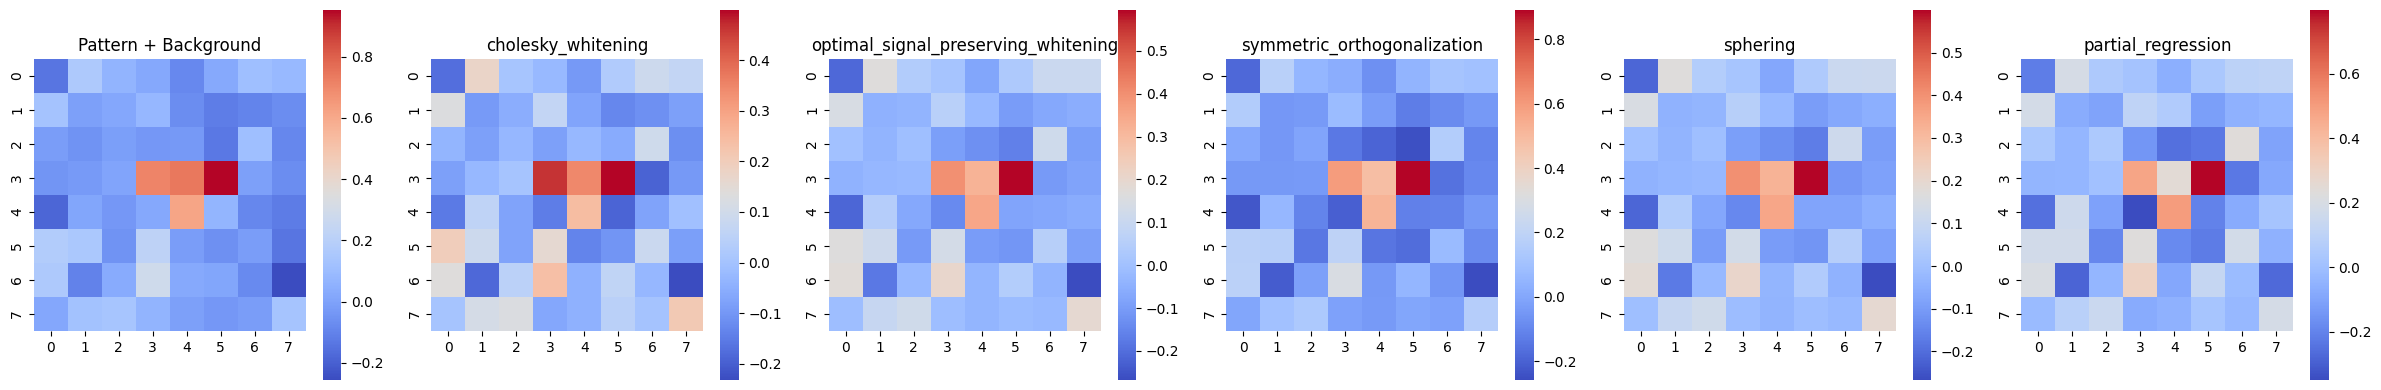

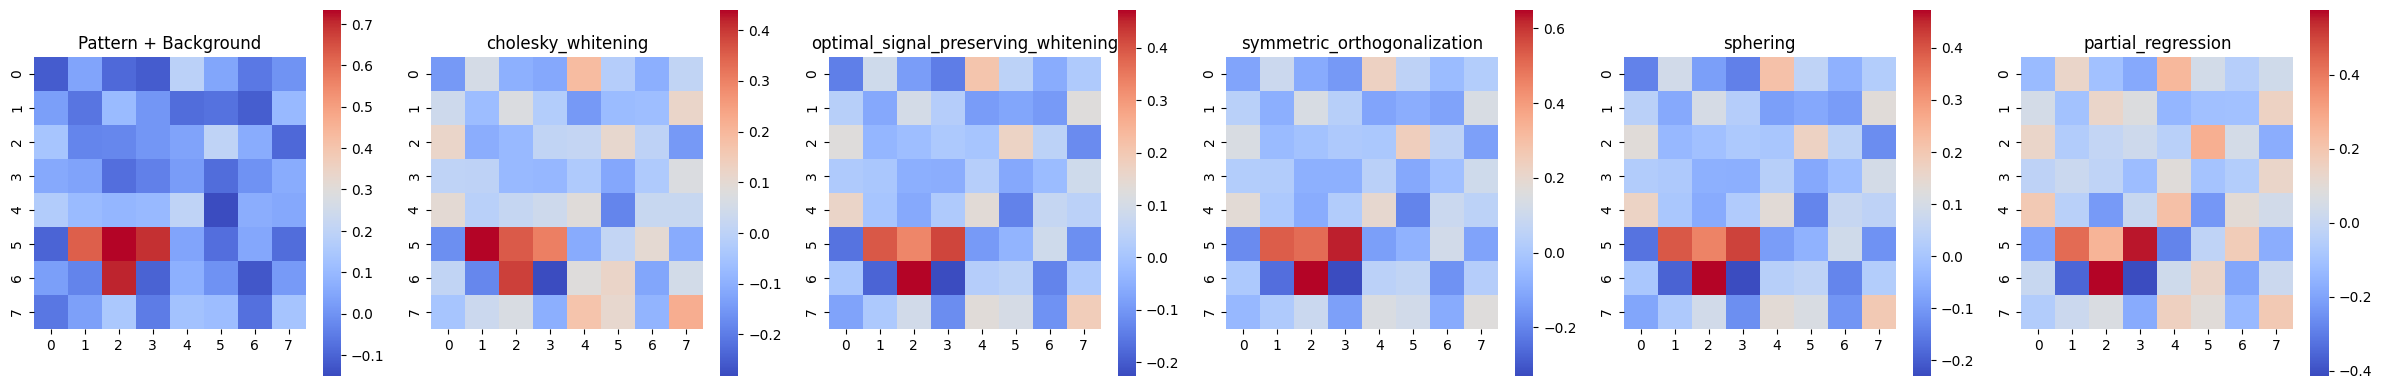

In [24]:
plot_heatmaps_for_index(0,  'translations_rotations', 'uncorrelated', 0.65, 1)
plot_heatmaps_for_index(0,  'translations_rotations', 'uncorrelated', 0.65, 2)
plot_heatmaps_for_index(0,  'translations_rotations', 'uncorrelated', 0.65, 3)
plot_heatmaps_for_index(0,  'translations_rotations', 'uncorrelated', 0.65, 4)
plot_heatmaps_for_index(0,  'translations_rotations', 'uncorrelated', 0.65, 5)

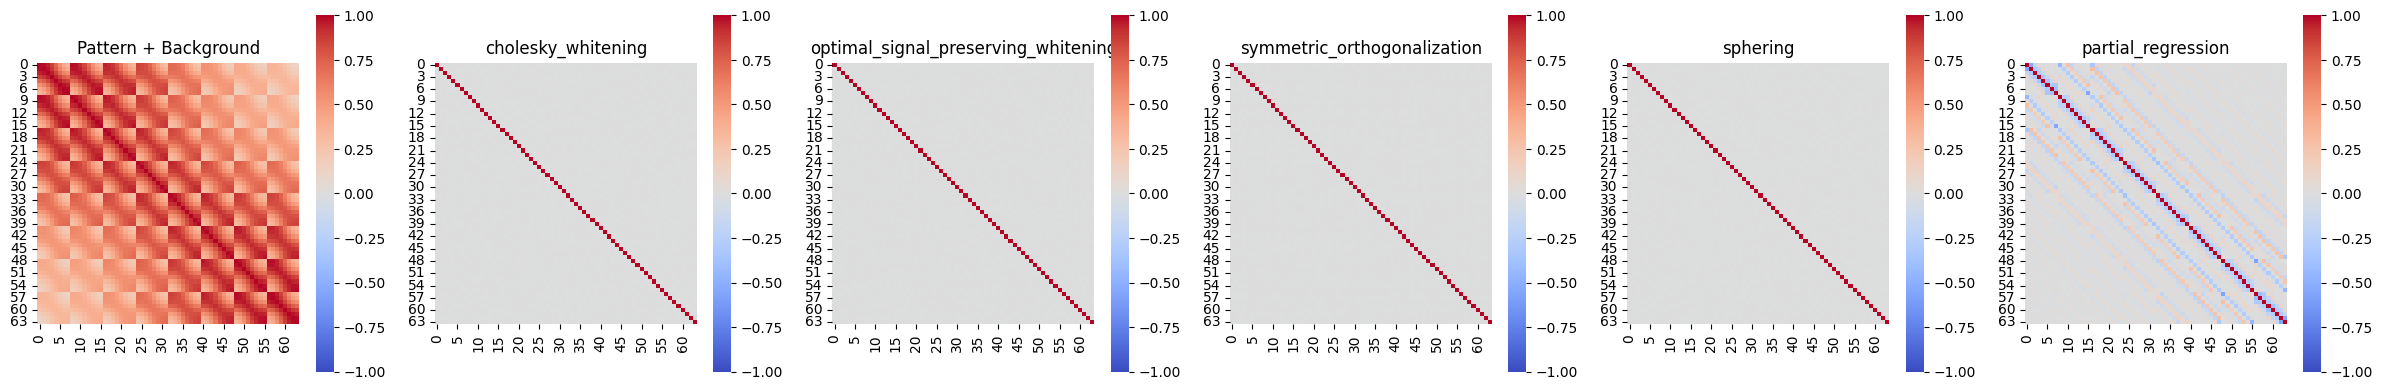

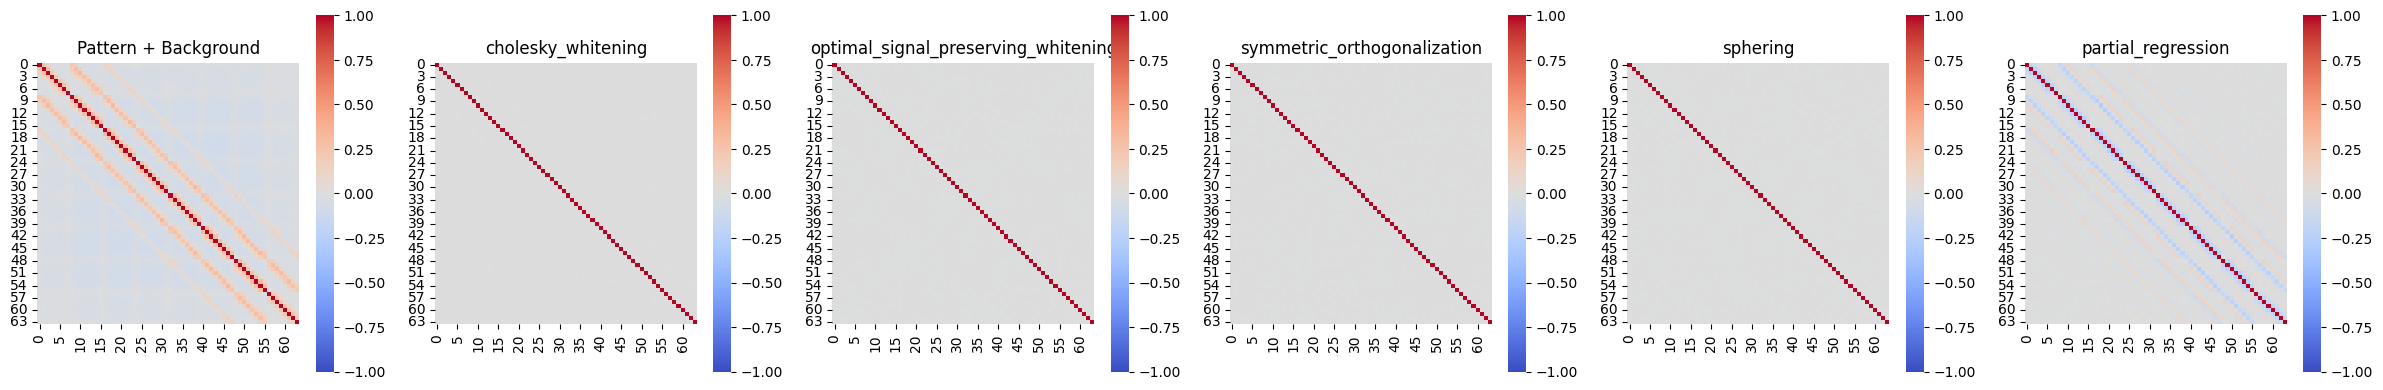

In [25]:
plot_correlation_matrices(0, 'translations_rotations', 'correlated', 0.2)
plot_correlation_matrices(0, 'translations_rotations', 'uncorrelated', 0.65)

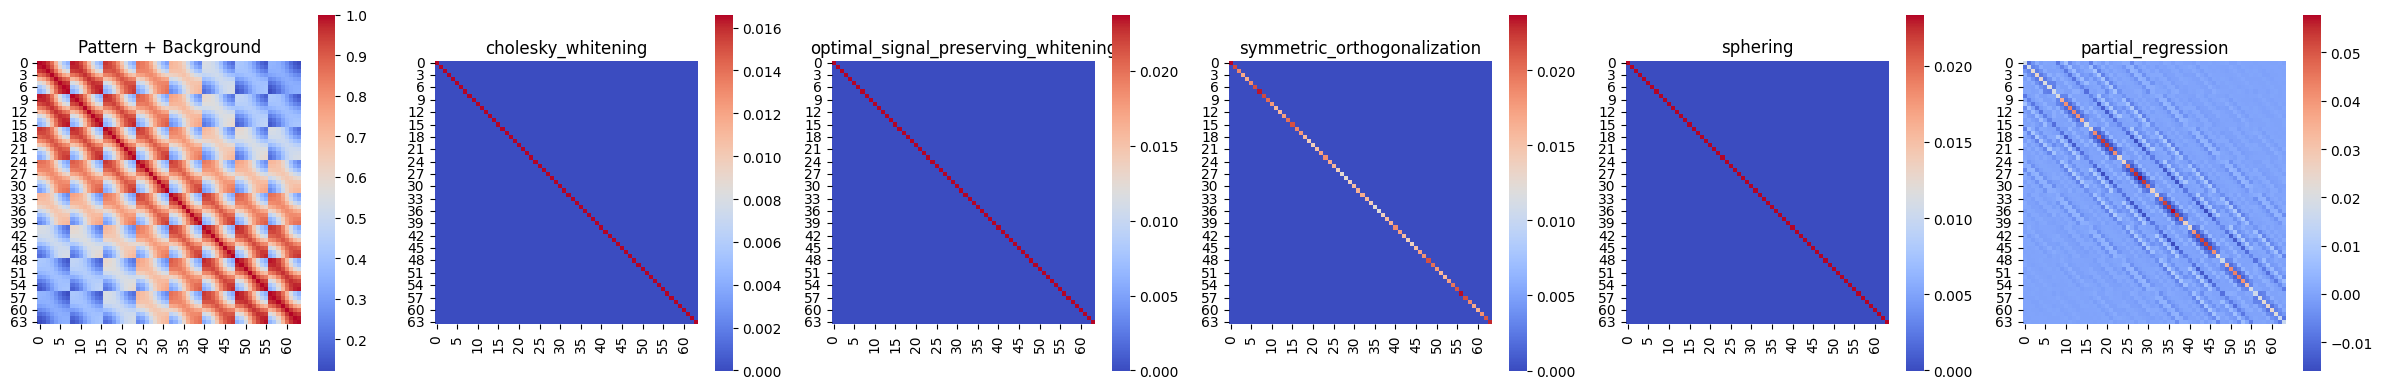

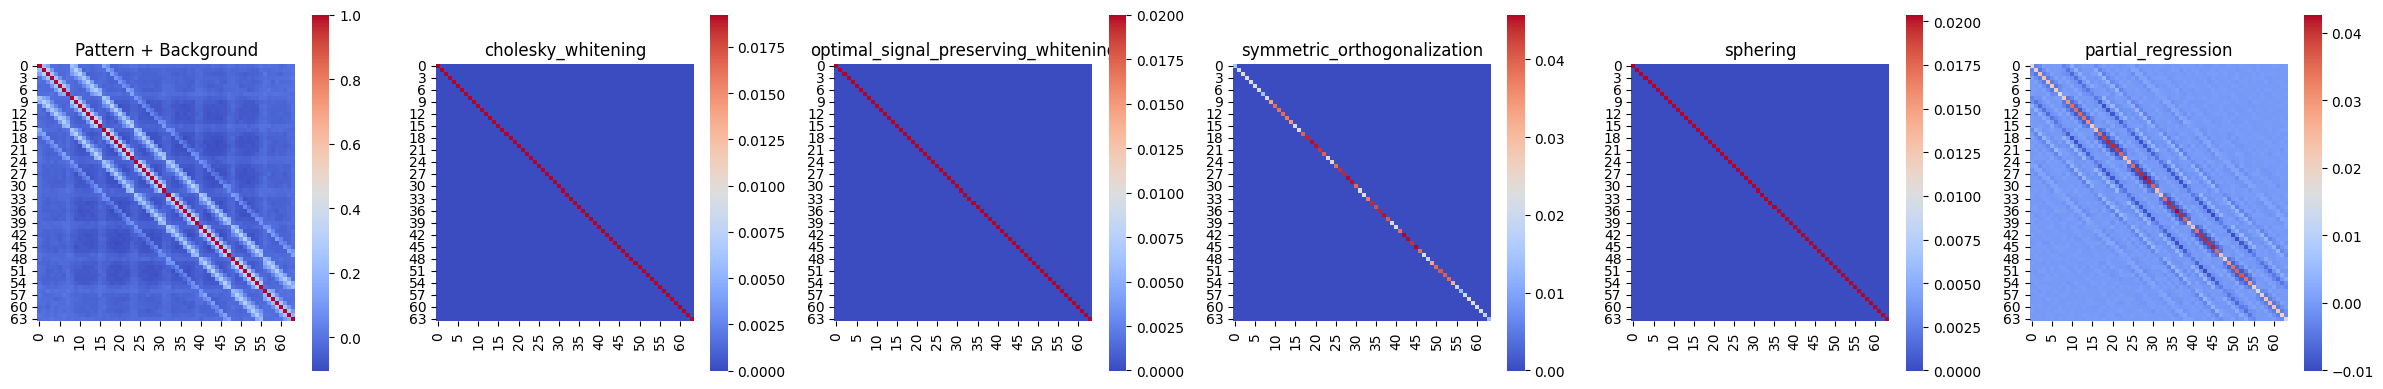

In [26]:
plot_covariance_matrices(0, 'translations_rotations', 'correlated', 0.2)
plot_covariance_matrices(0, 'translations_rotations', 'uncorrelated', 0.65)

# multiplicative

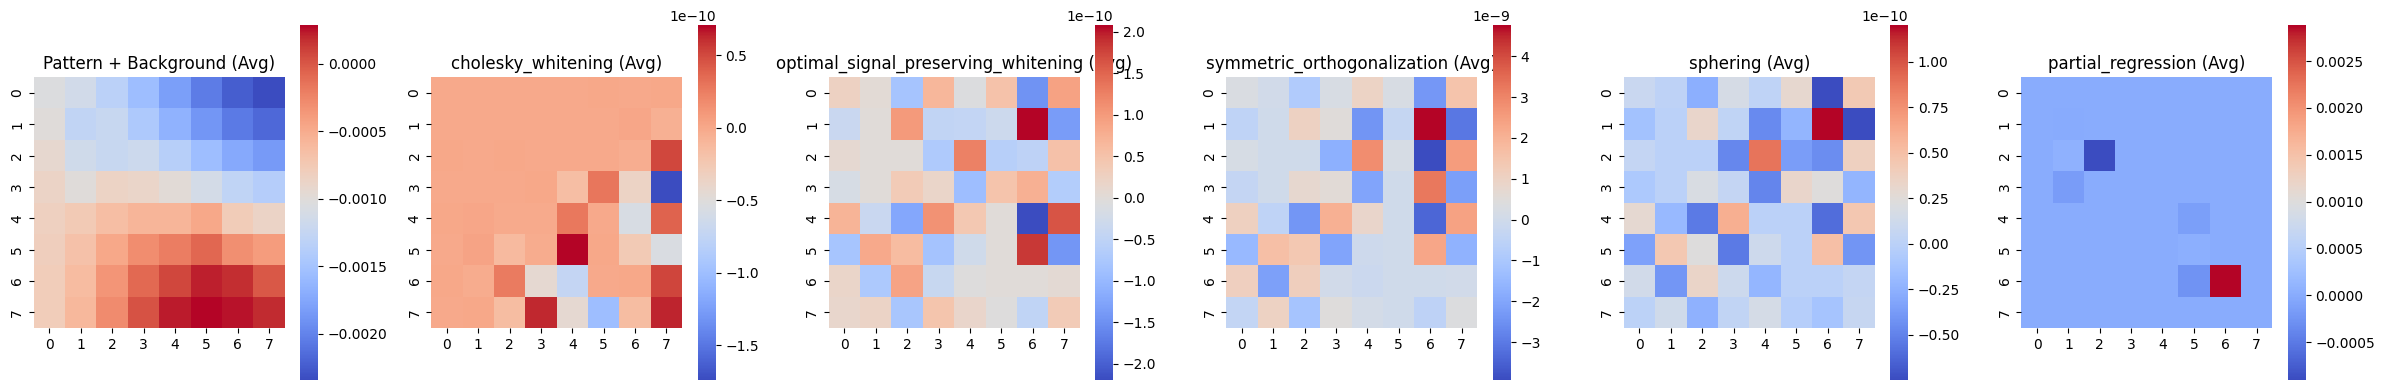

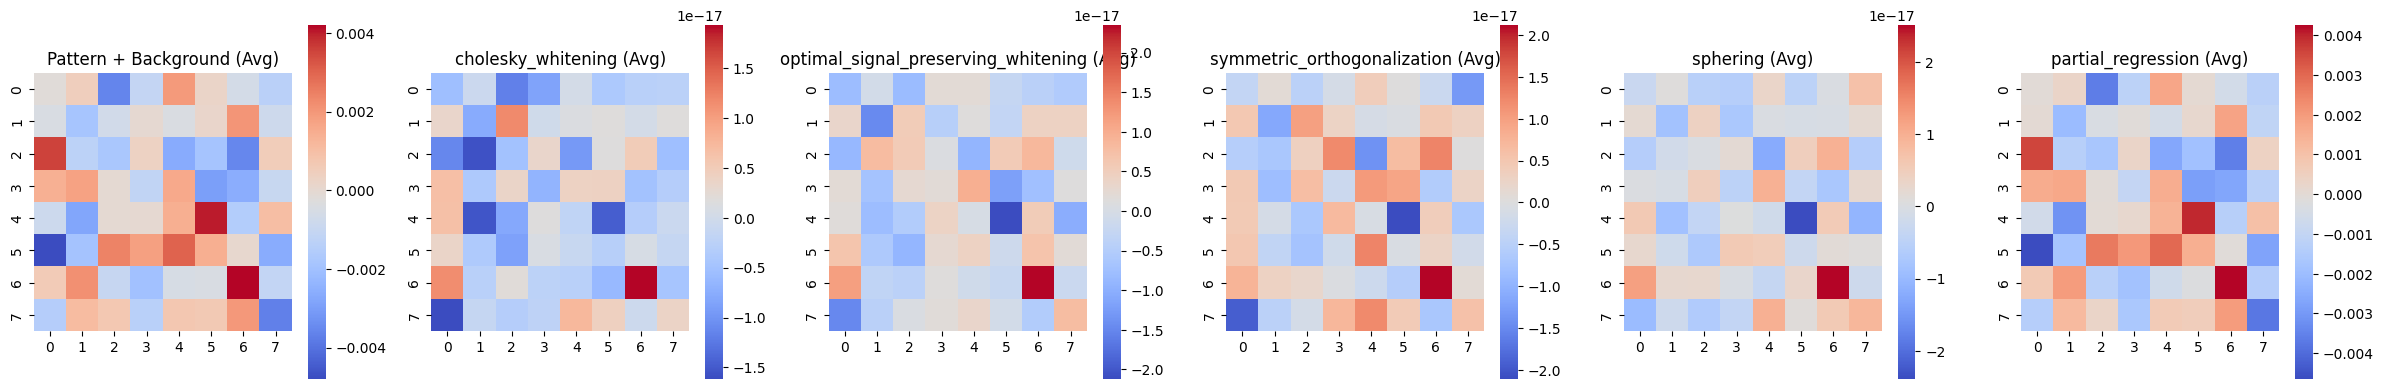

In [27]:
plot_average_heatmaps(0, 'multiplicative', 'correlated', 0.1)
plot_average_heatmaps(0, 'multiplicative', 'uncorrelated', 0.7)

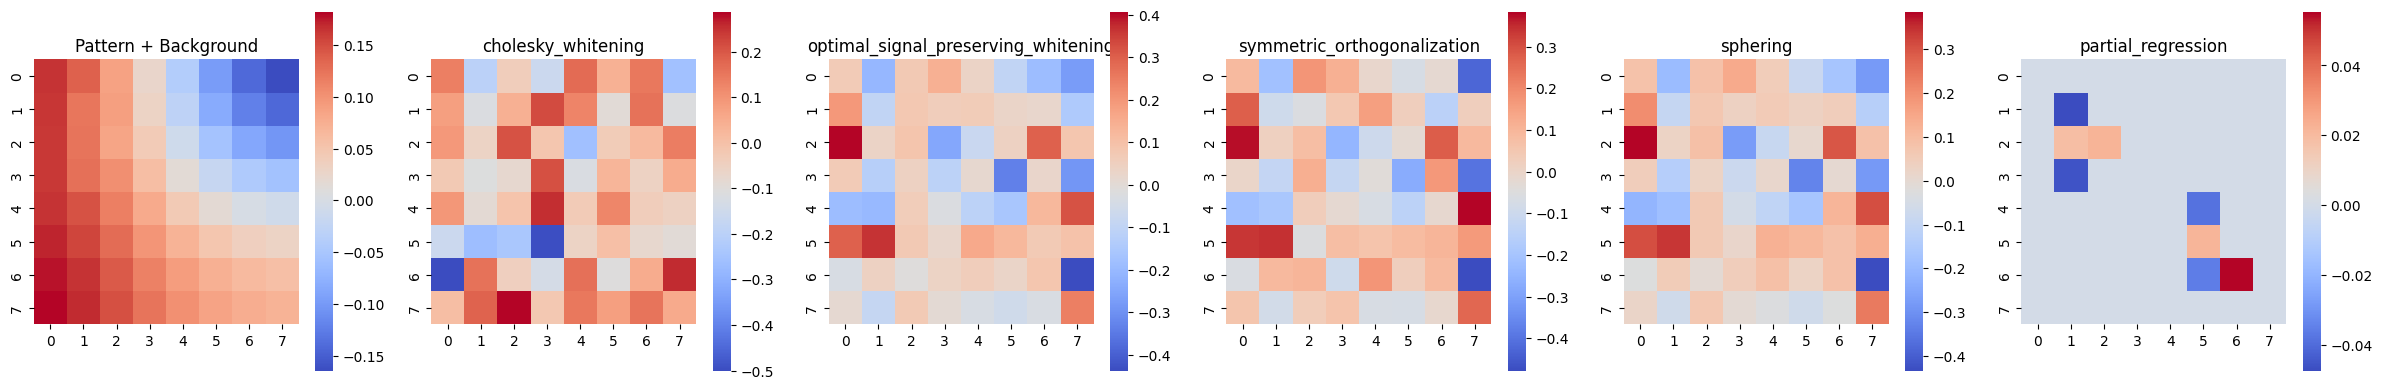

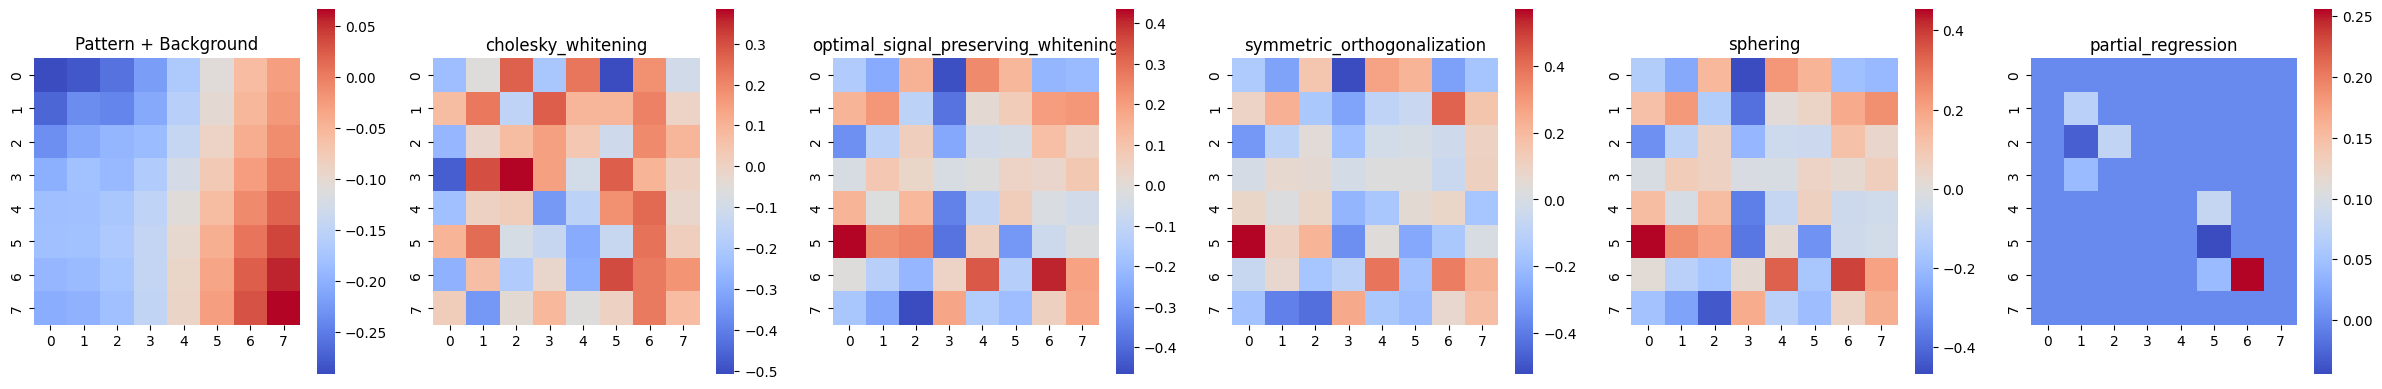

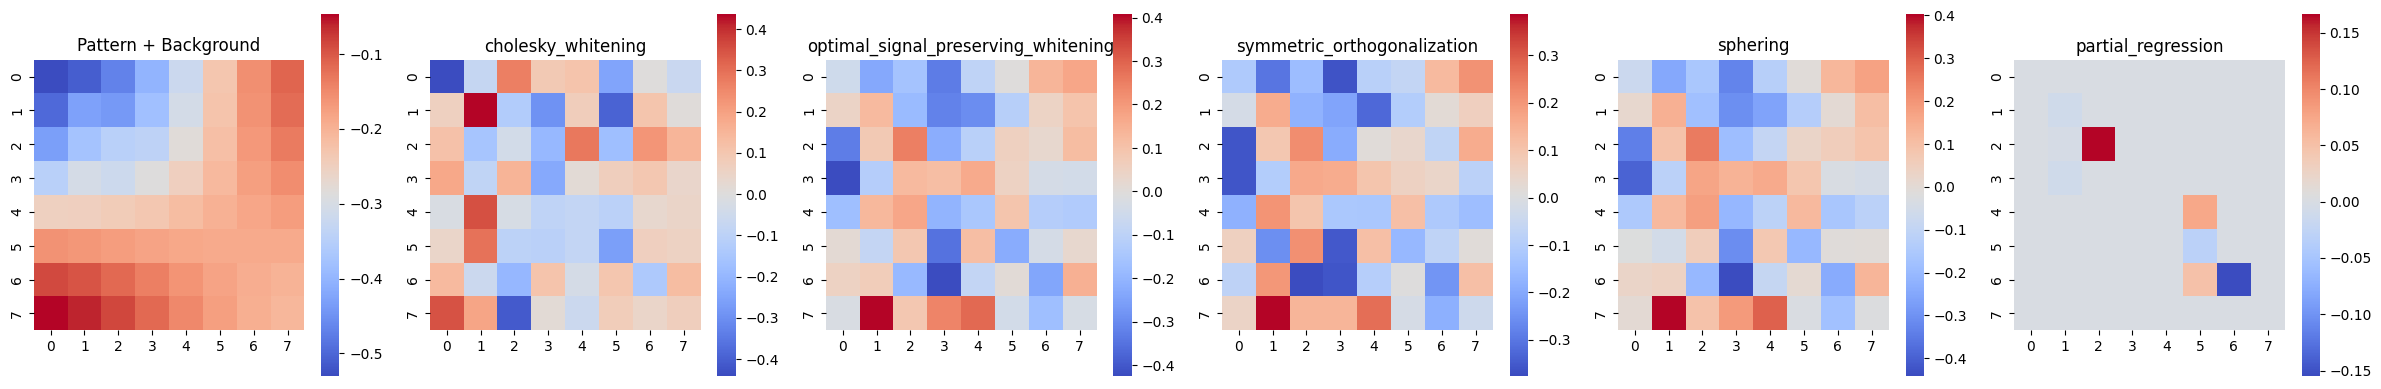

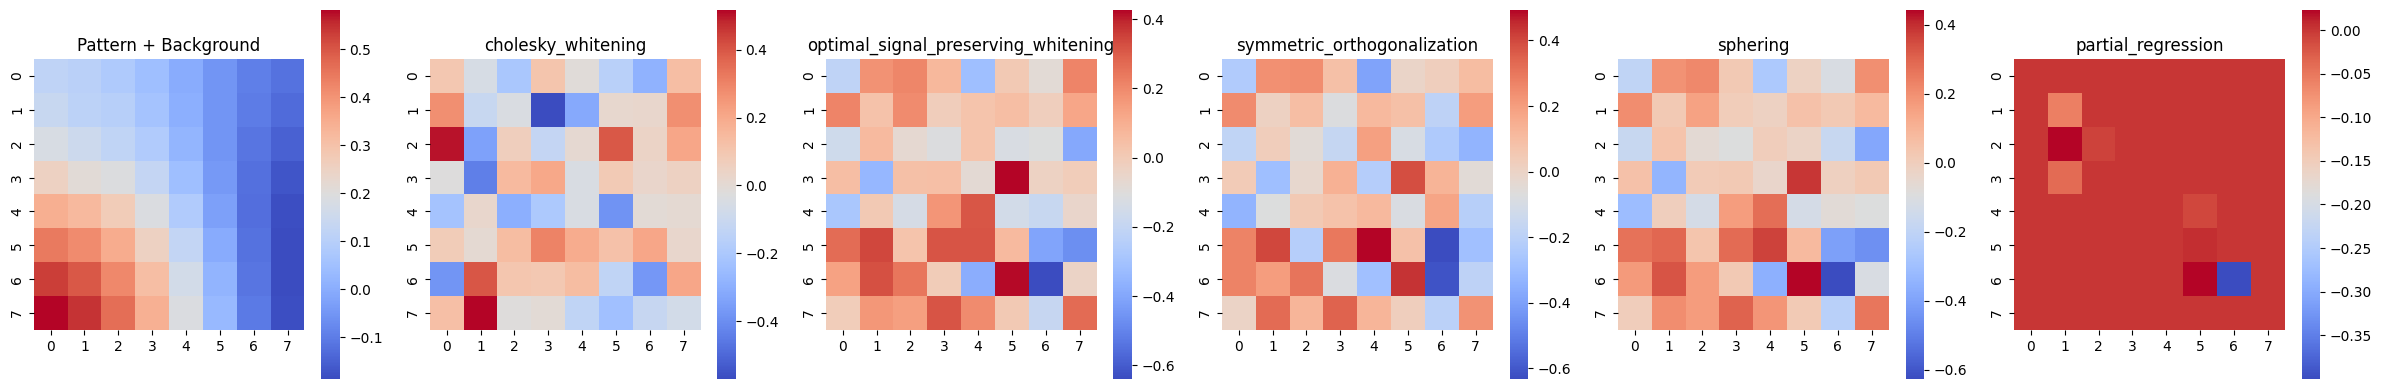

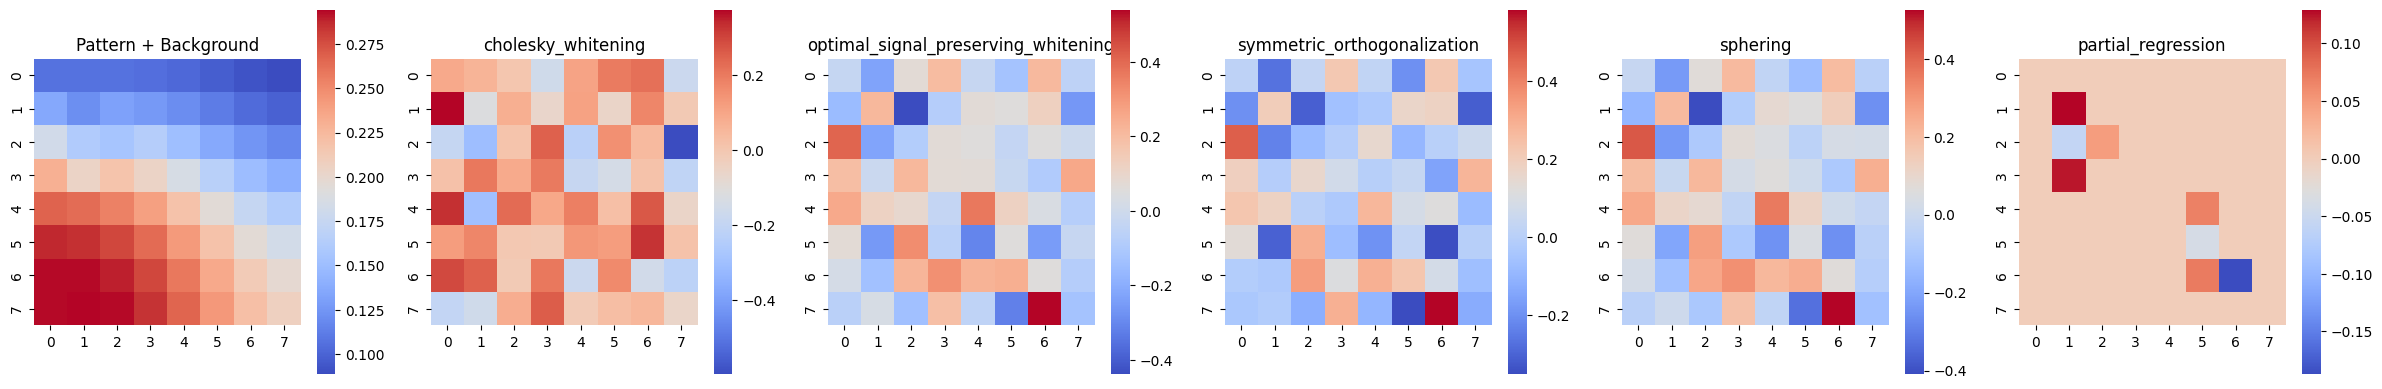

In [28]:
plot_heatmaps_for_index(0,  'multiplicative', 'correlated', 0.1, 1)
plot_heatmaps_for_index(0,  'multiplicative', 'correlated', 0.1, 2)
plot_heatmaps_for_index(0,  'multiplicative', 'correlated', 0.1, 3)
plot_heatmaps_for_index(0,  'multiplicative', 'correlated', 0.1, 4)
plot_heatmaps_for_index(0,  'multiplicative', 'correlated', 0.1, 5)

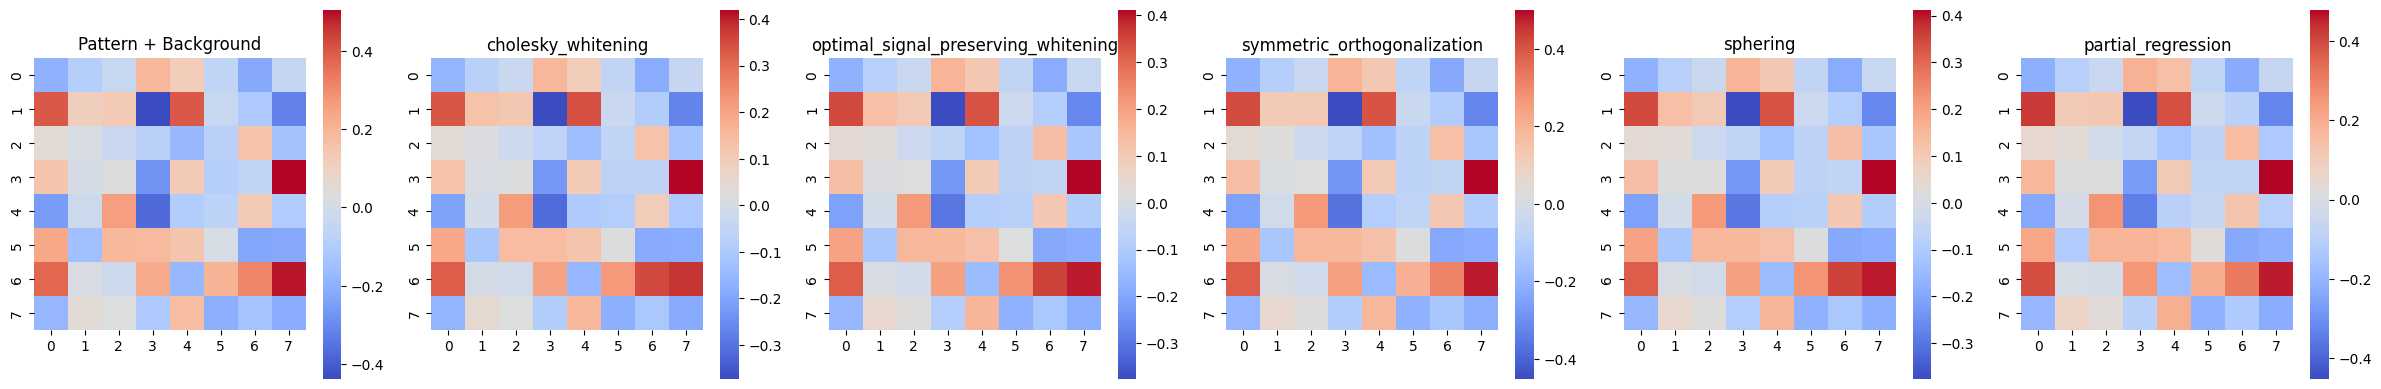

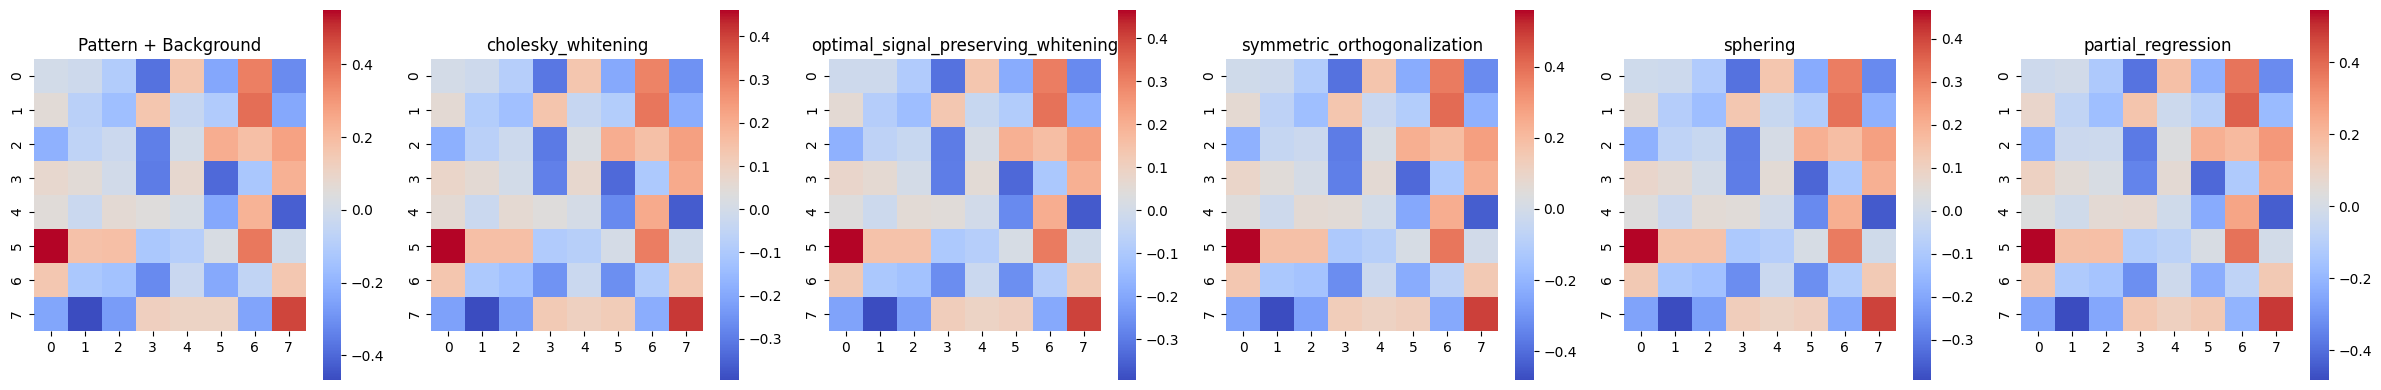

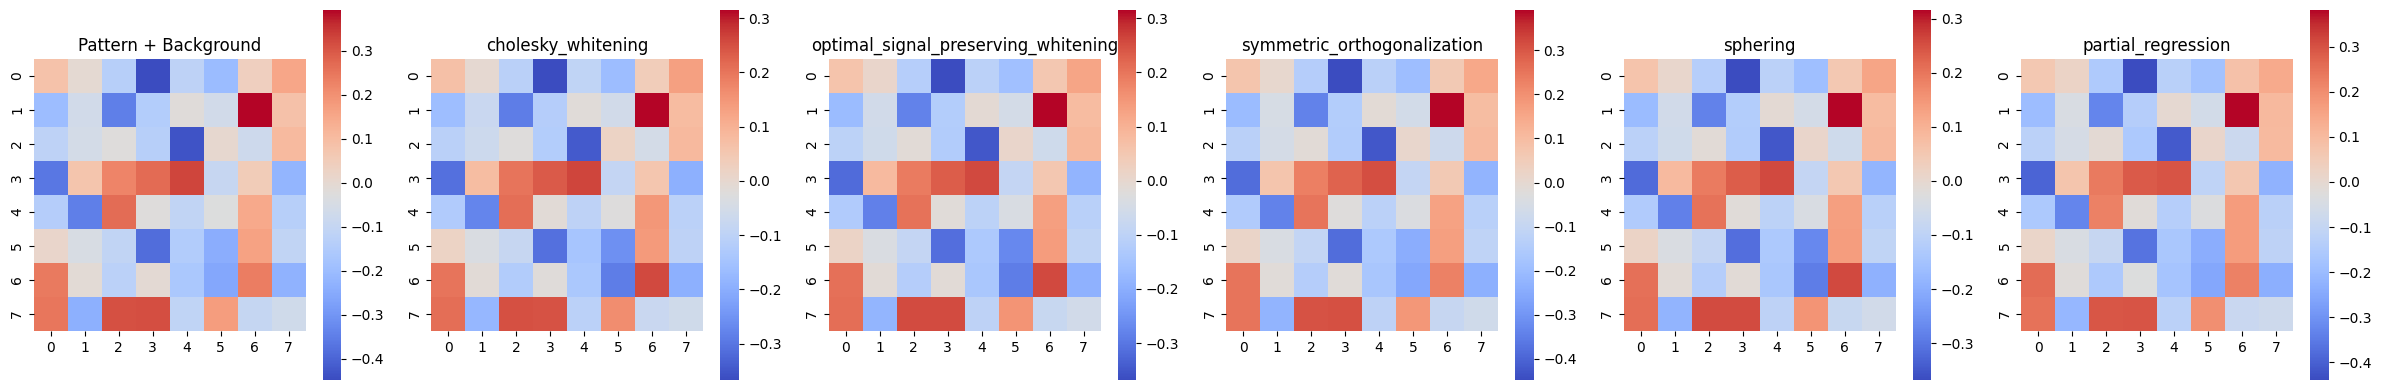

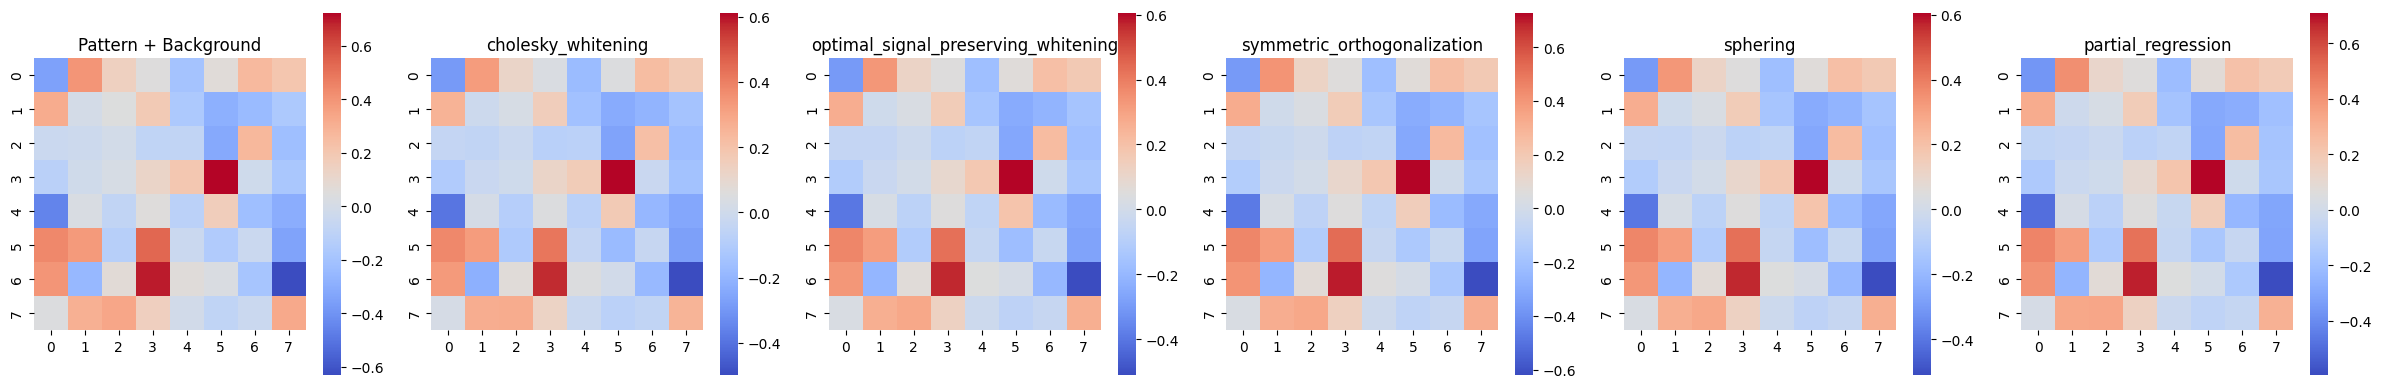

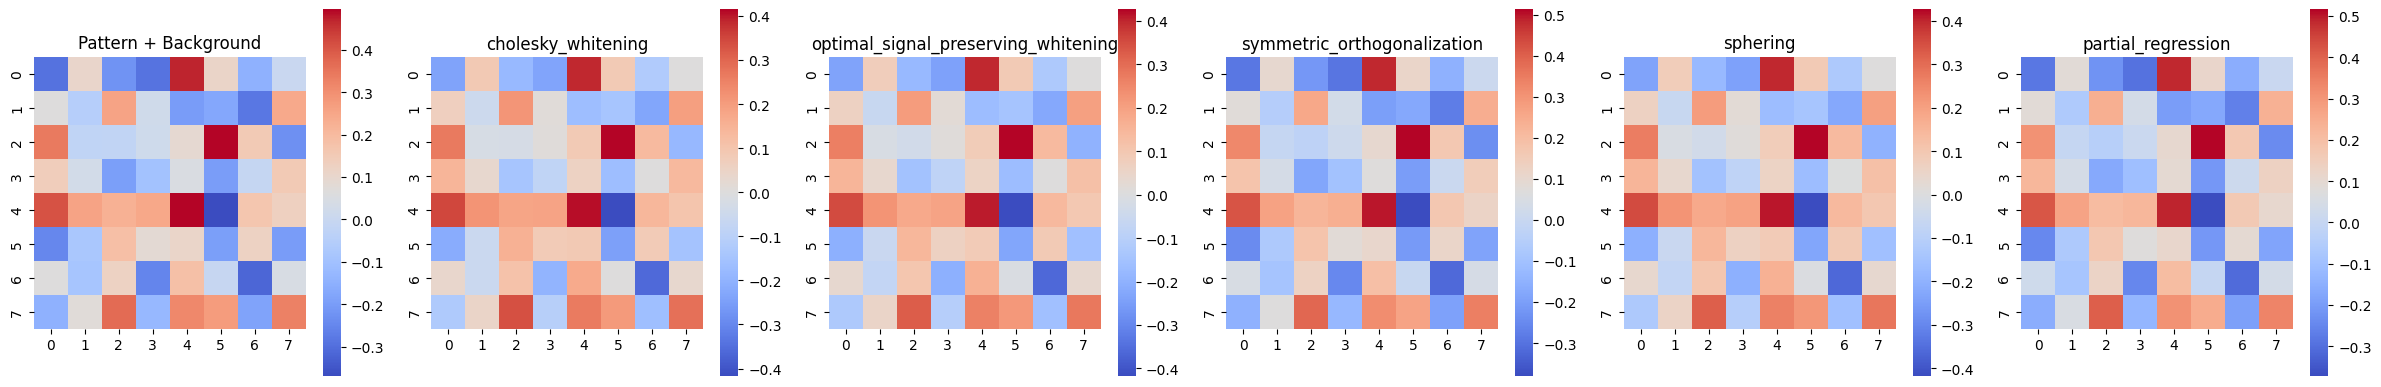

In [29]:
plot_heatmaps_for_index(0,  'multiplicative', 'uncorrelated', 0.7, 1)
plot_heatmaps_for_index(0,  'multiplicative', 'uncorrelated', 0.7, 2)
plot_heatmaps_for_index(0,  'multiplicative', 'uncorrelated', 0.7, 3)
plot_heatmaps_for_index(0,  'multiplicative', 'uncorrelated', 0.7, 4)
plot_heatmaps_for_index(0,  'multiplicative', 'uncorrelated', 0.7, 5)

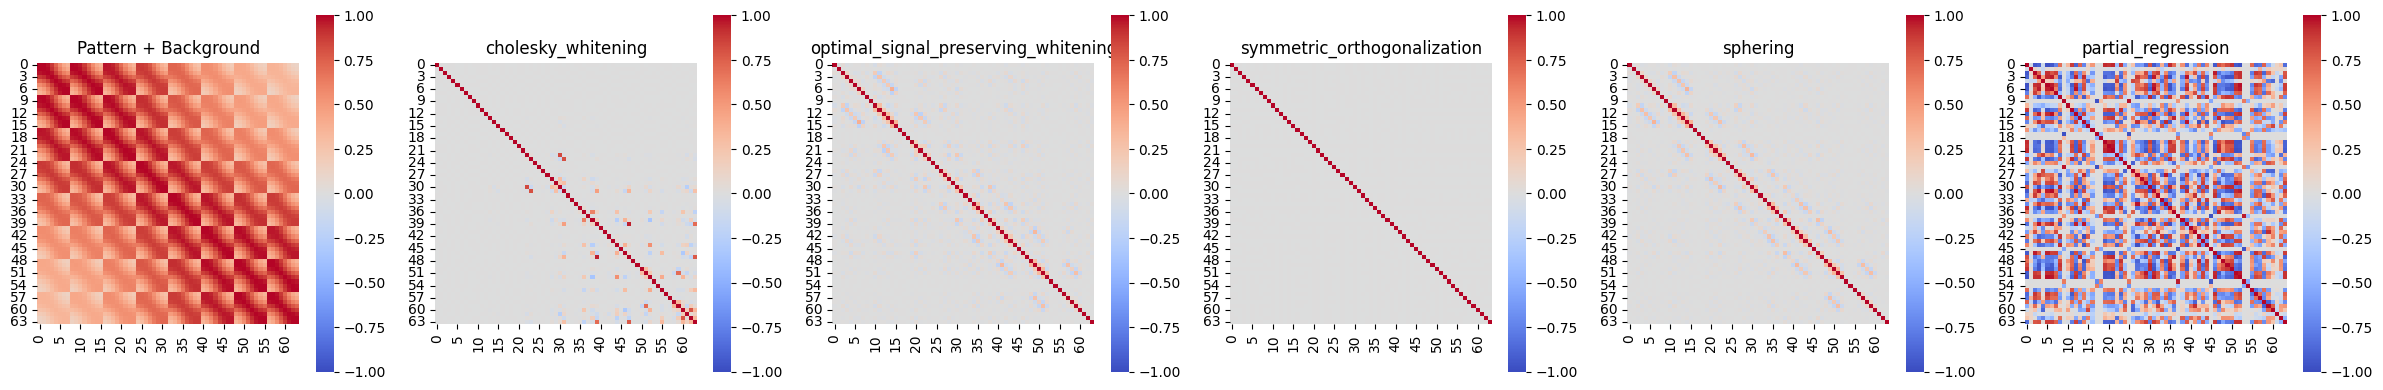

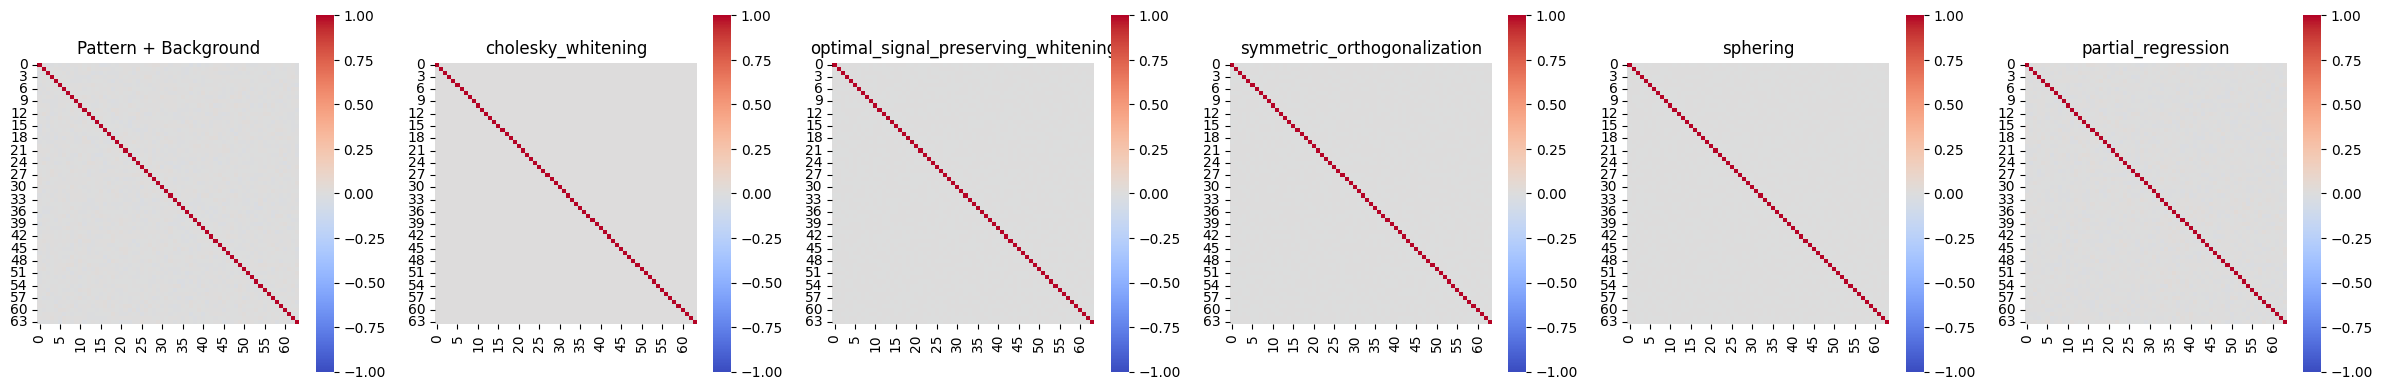

In [30]:
plot_correlation_matrices(0, 'multiplicative', 'correlated', 0.1)
plot_correlation_matrices(0, 'multiplicative', 'uncorrelated', 0.7)

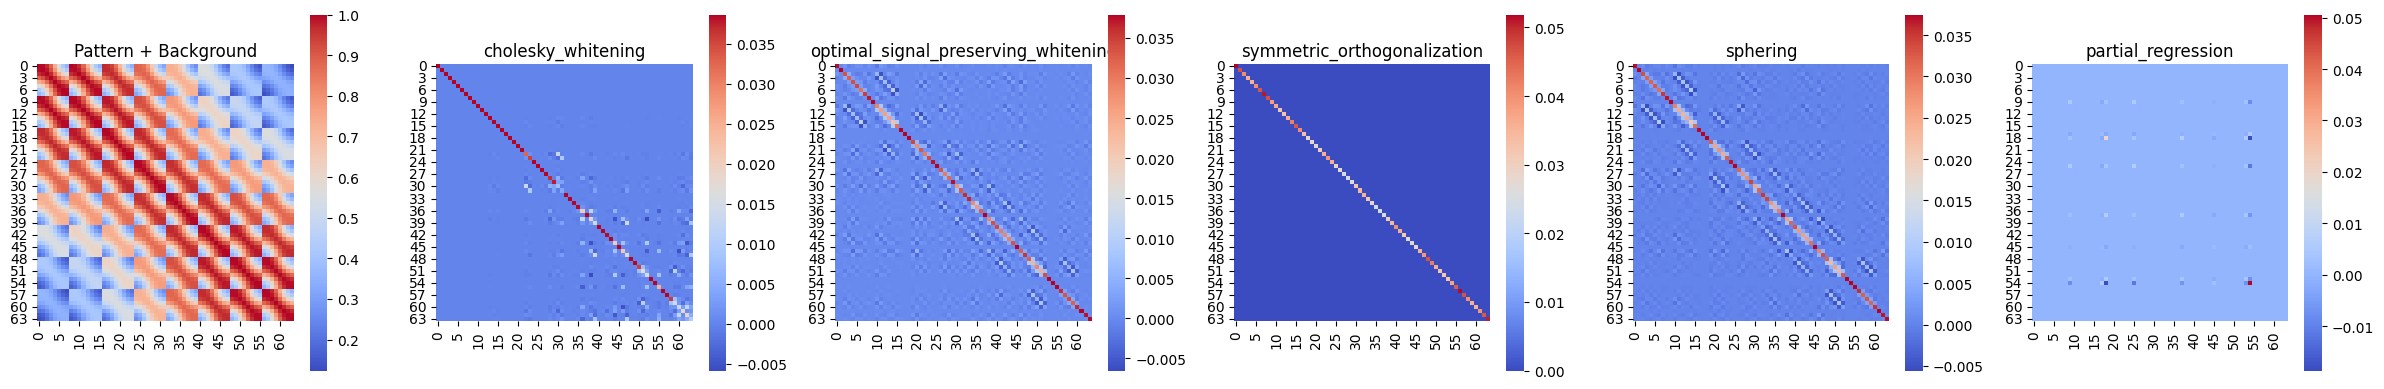

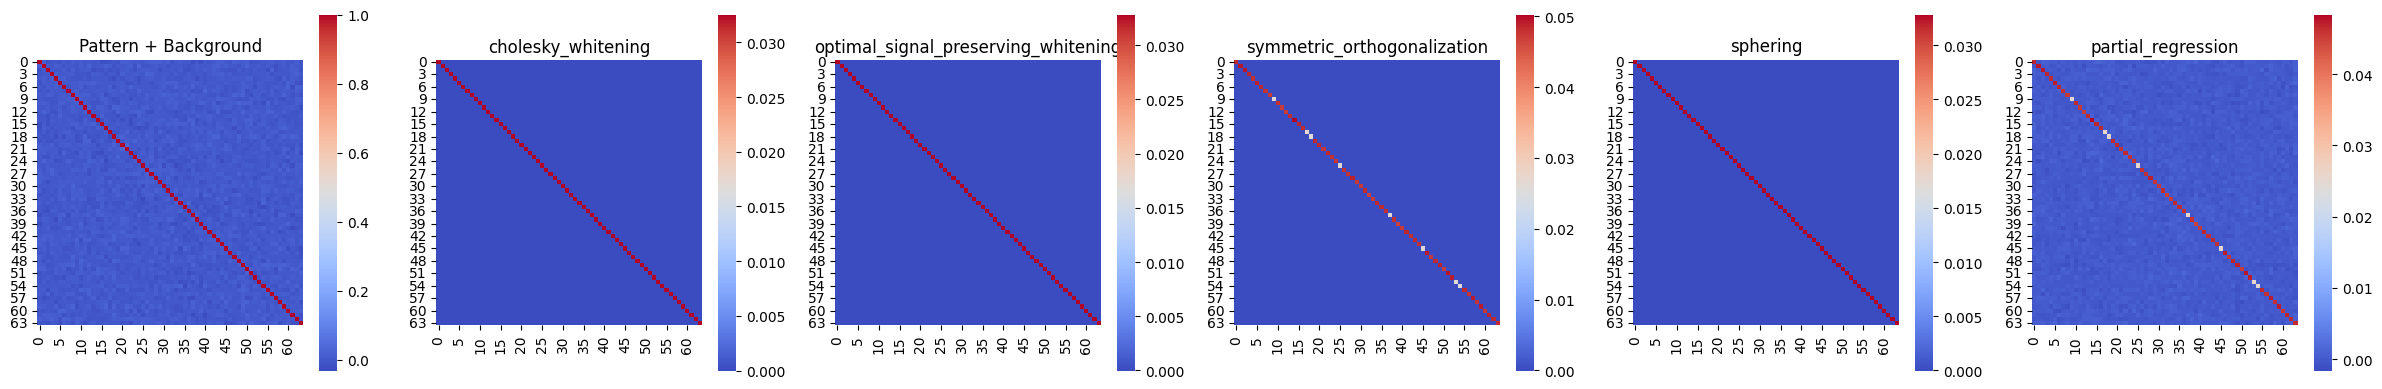

In [31]:
plot_covariance_matrices(0, 'multiplicative', 'correlated', 0.1)
plot_covariance_matrices(0, 'multiplicative', 'uncorrelated', 0.7)


# linear

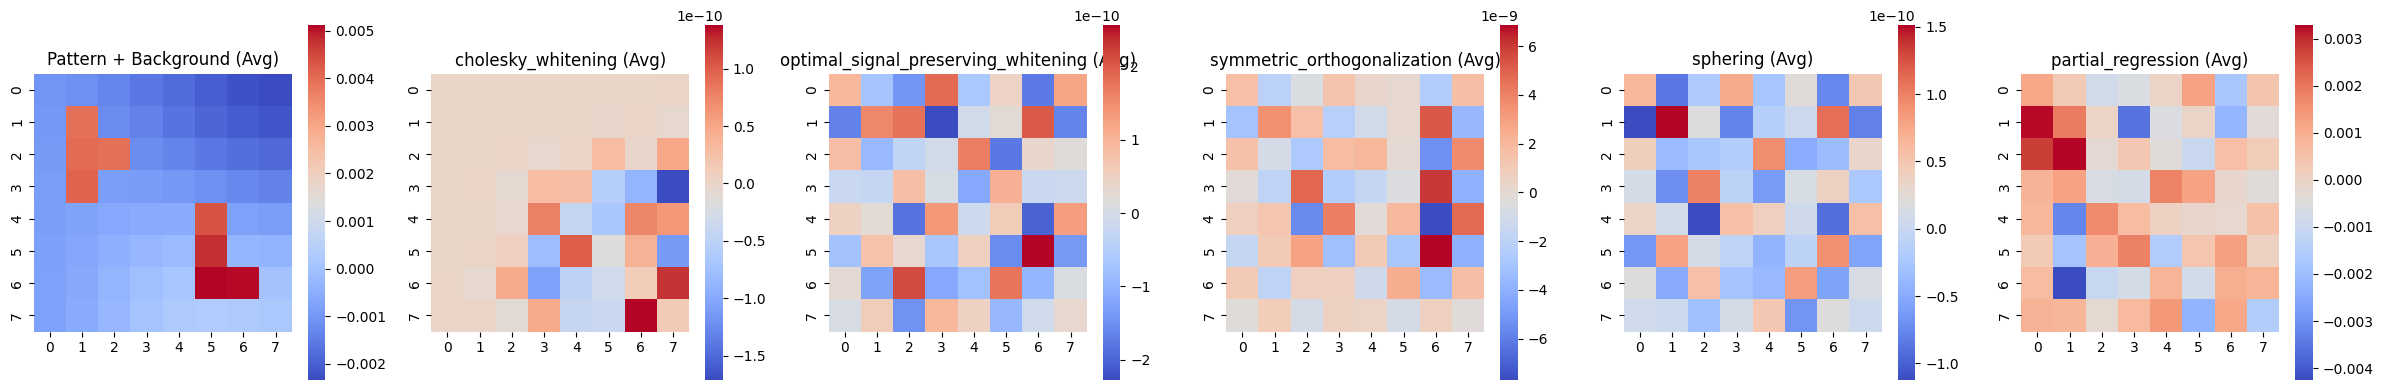

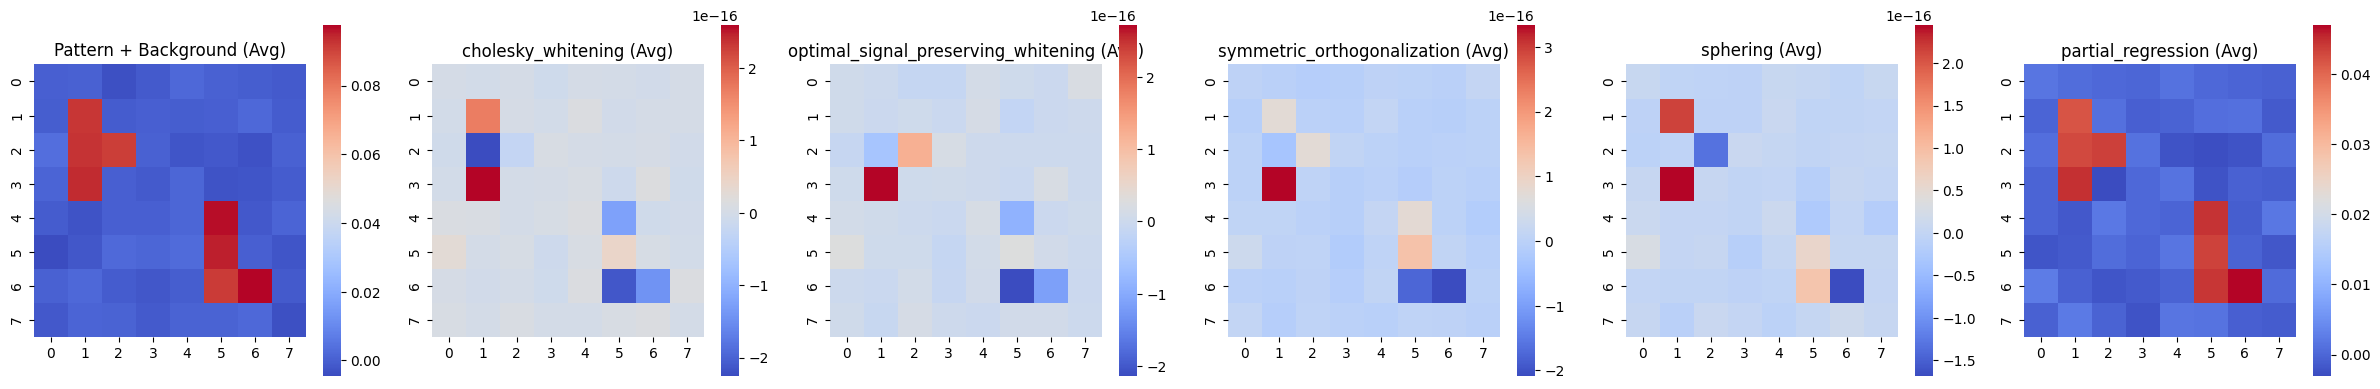

In [32]:
plot_average_heatmaps(0, 'linear', 'correlated', 0.0125)
plot_average_heatmaps(0, 'linear', 'uncorrelated', 0.18)

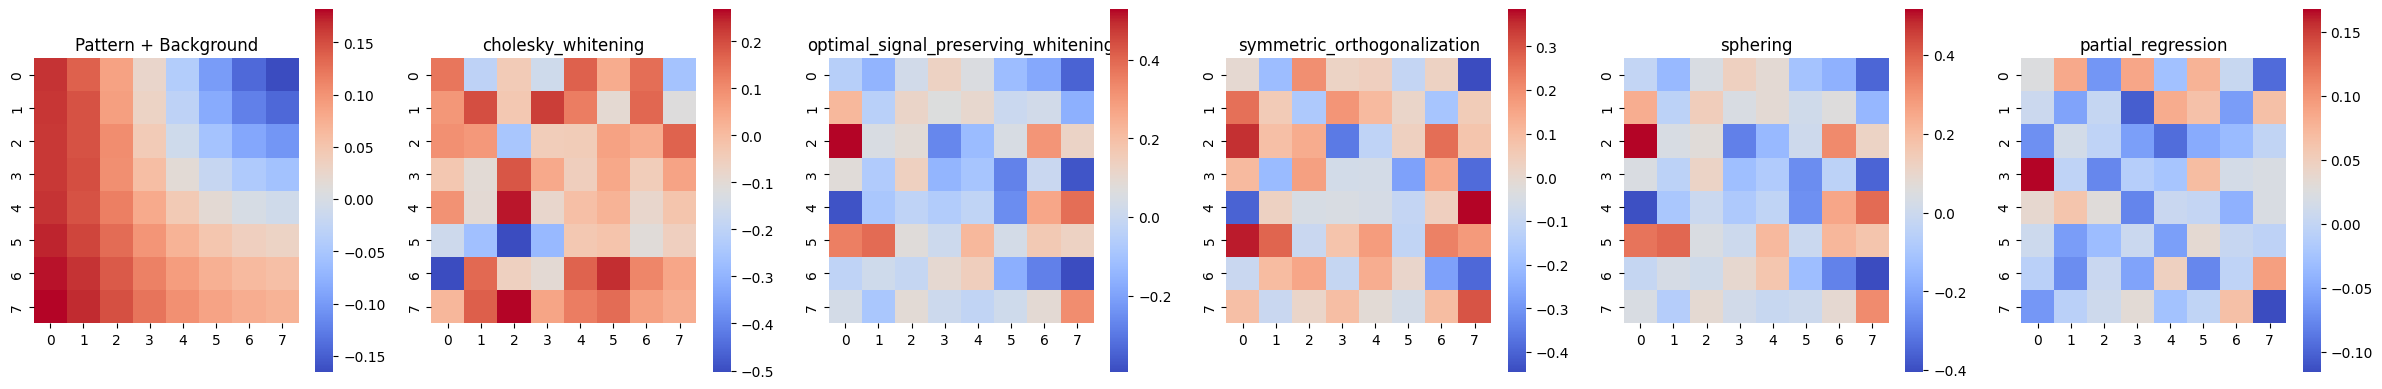

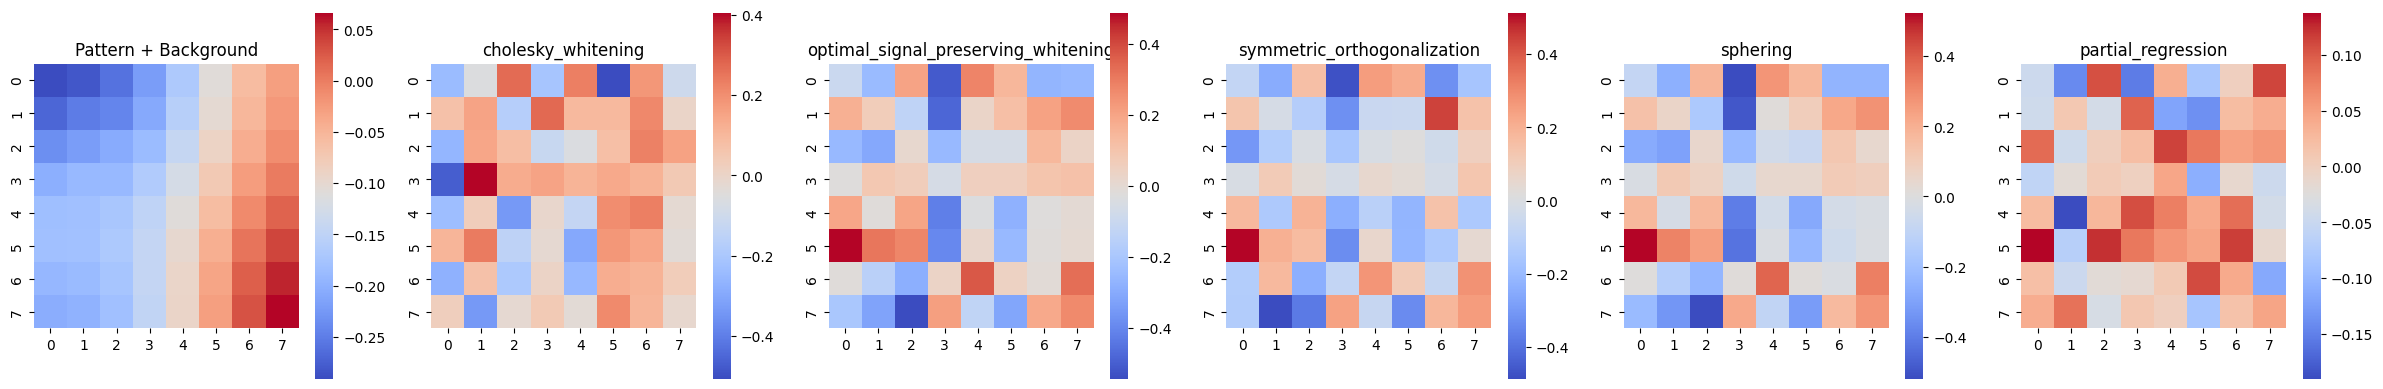

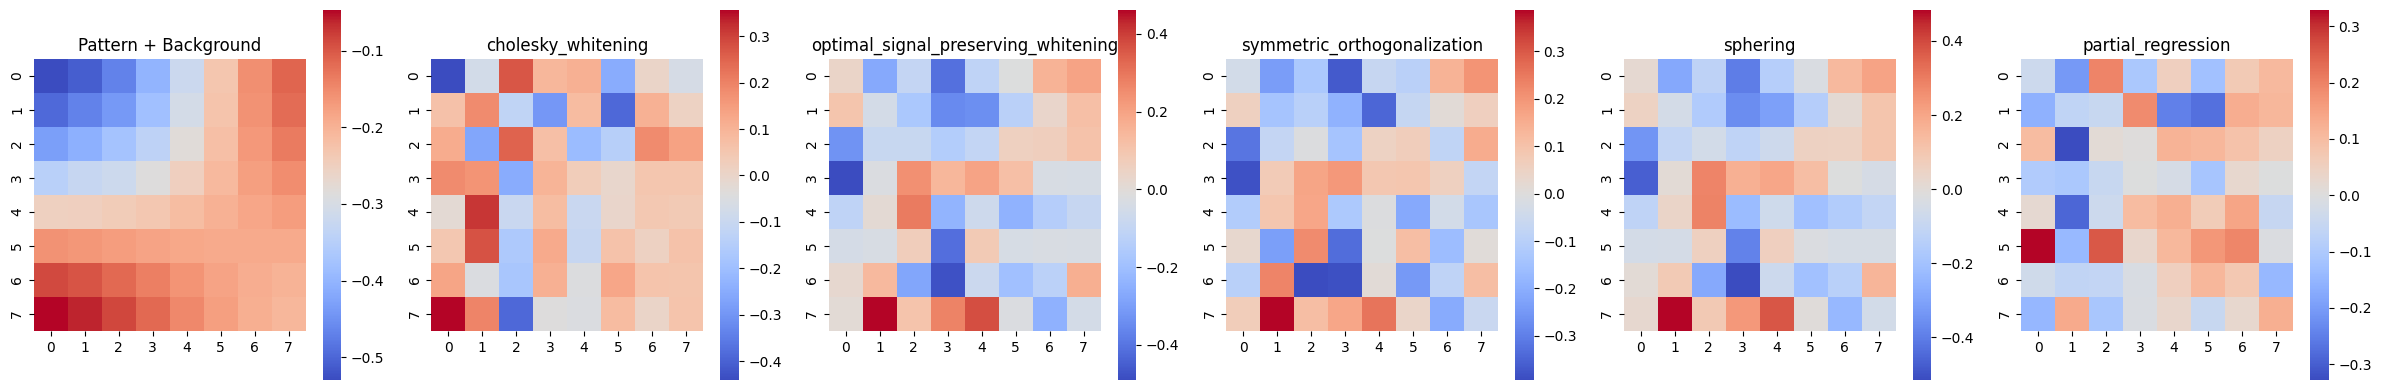

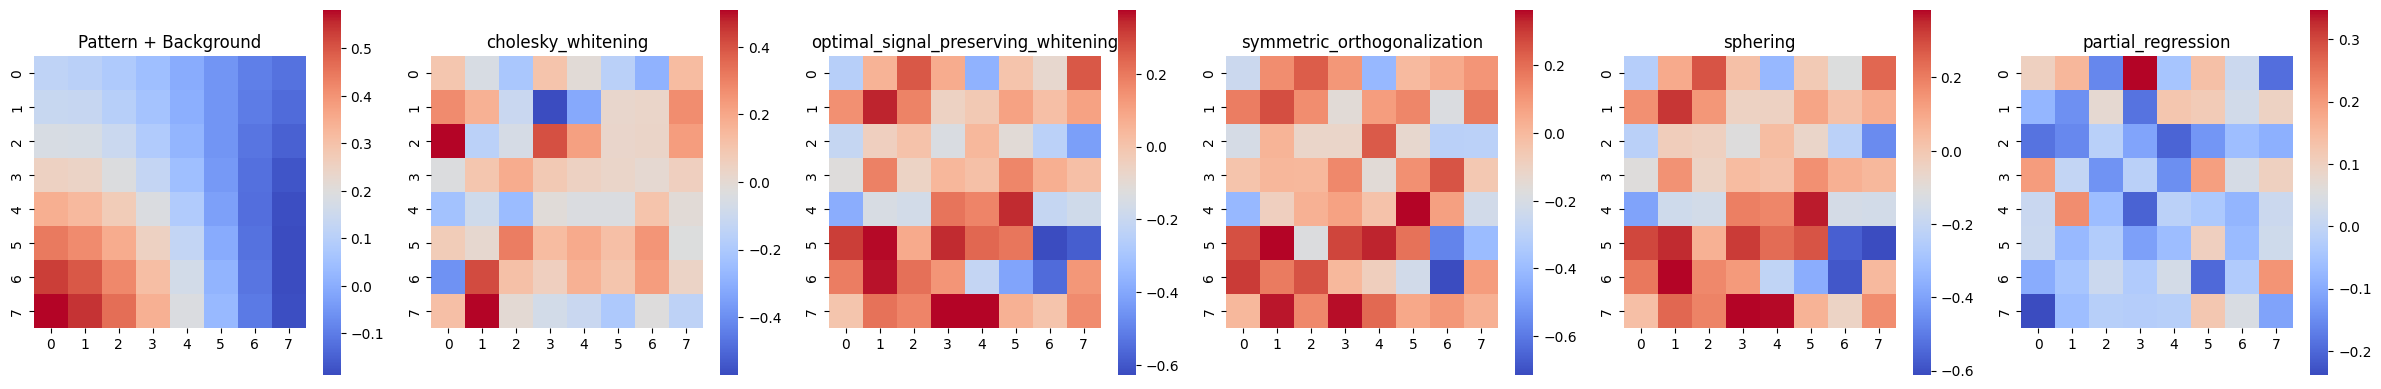

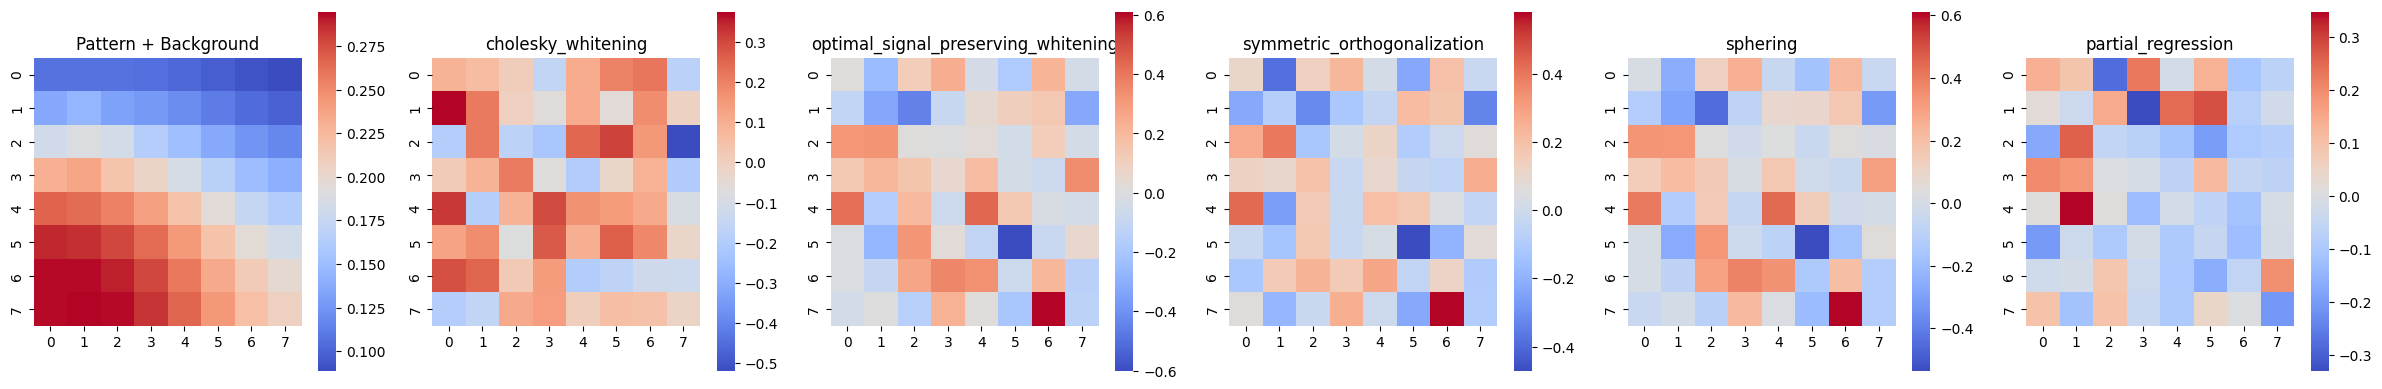

In [33]:
plot_heatmaps_for_index(0,  'linear', 'correlated', 0.0125, 1)
plot_heatmaps_for_index(0,  'linear', 'correlated', 0.0125, 2)
plot_heatmaps_for_index(0,  'linear', 'correlated', 0.0125, 3)
plot_heatmaps_for_index(0,  'linear', 'correlated', 0.0125, 4)
plot_heatmaps_for_index(0,  'linear', 'correlated', 0.0125, 5)

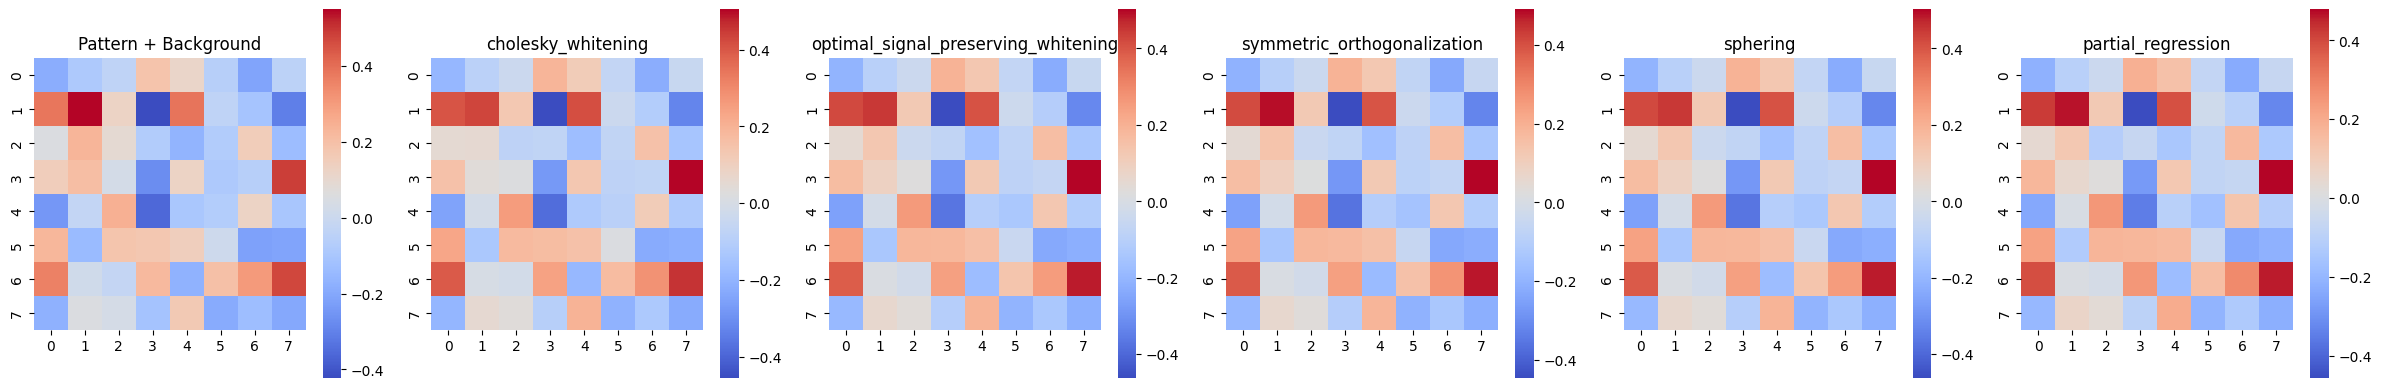

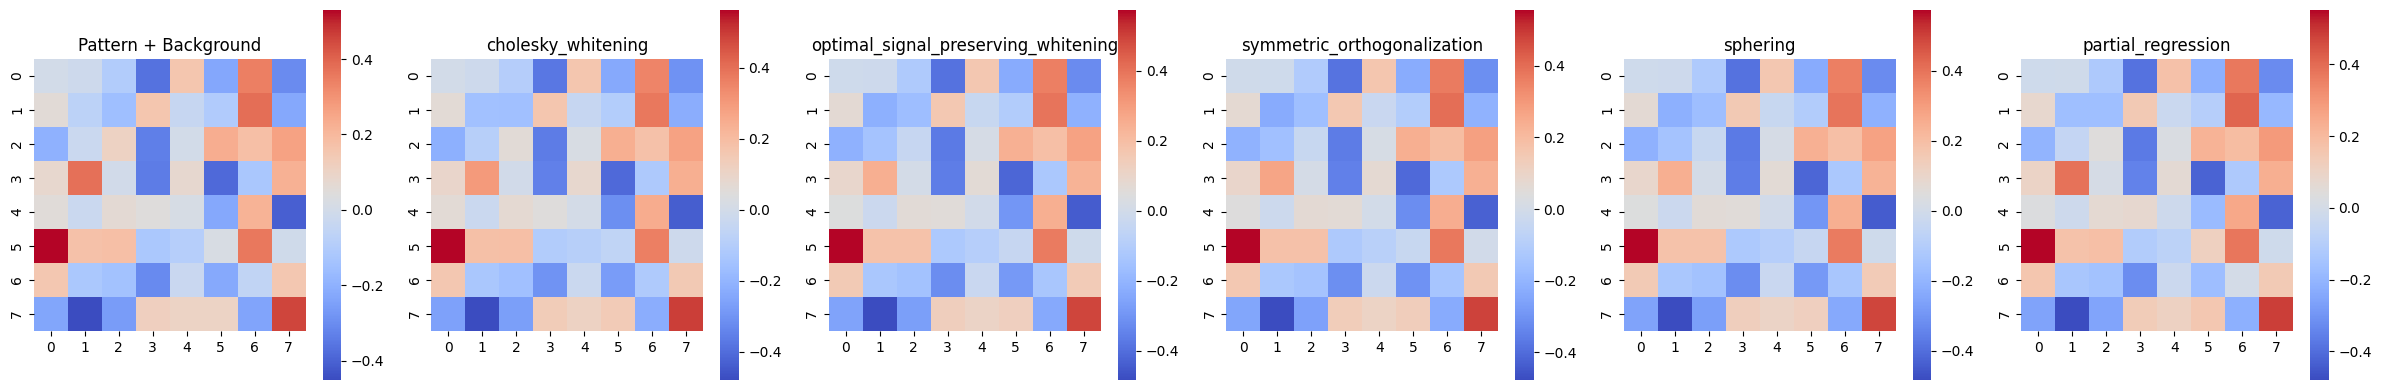

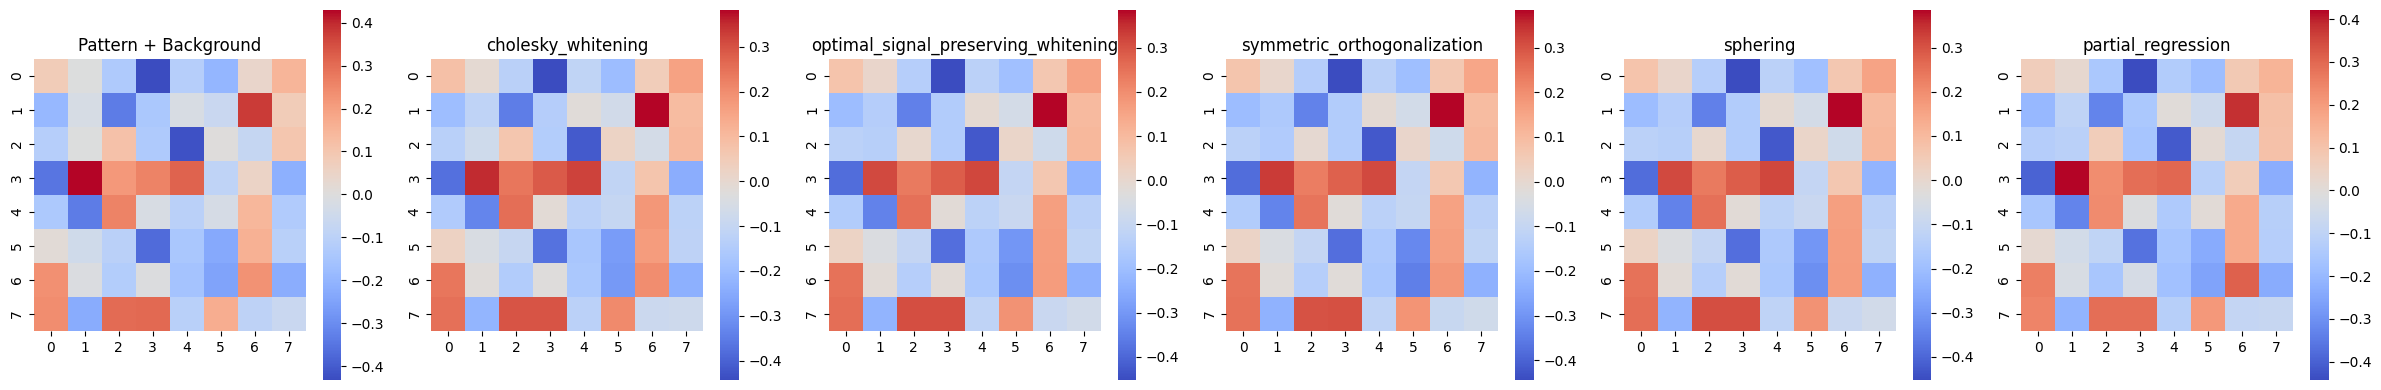

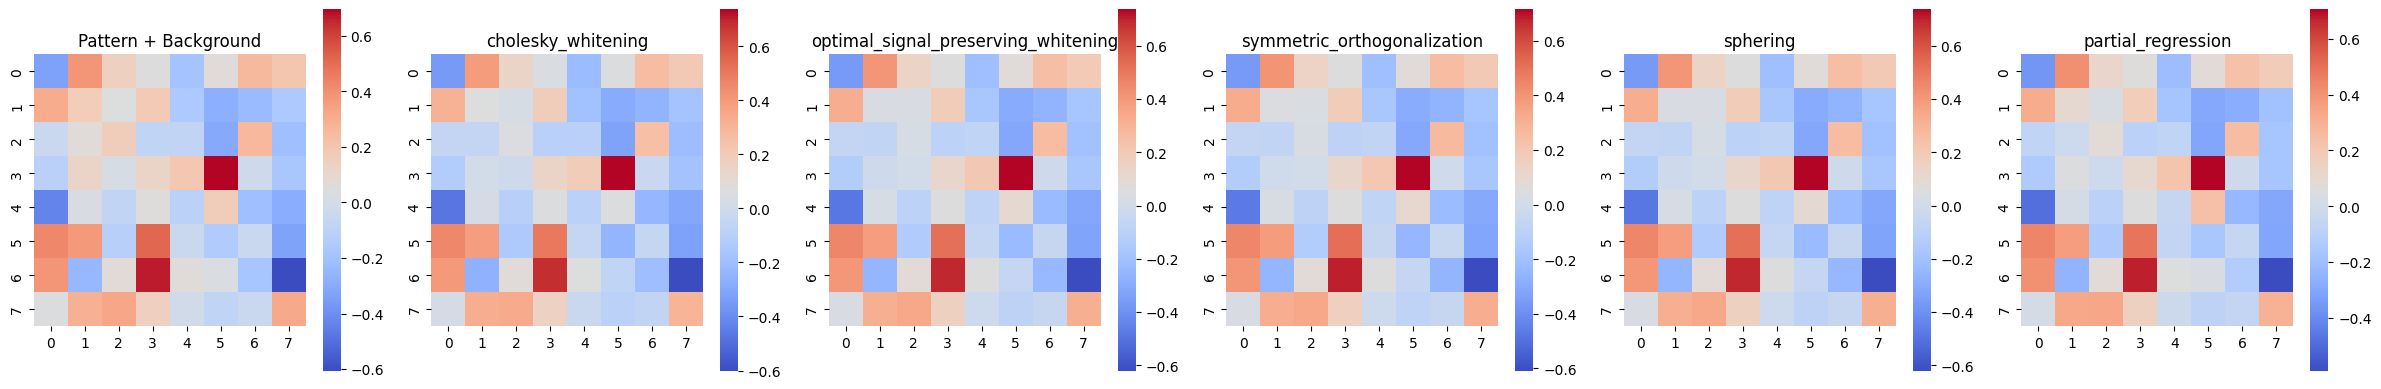

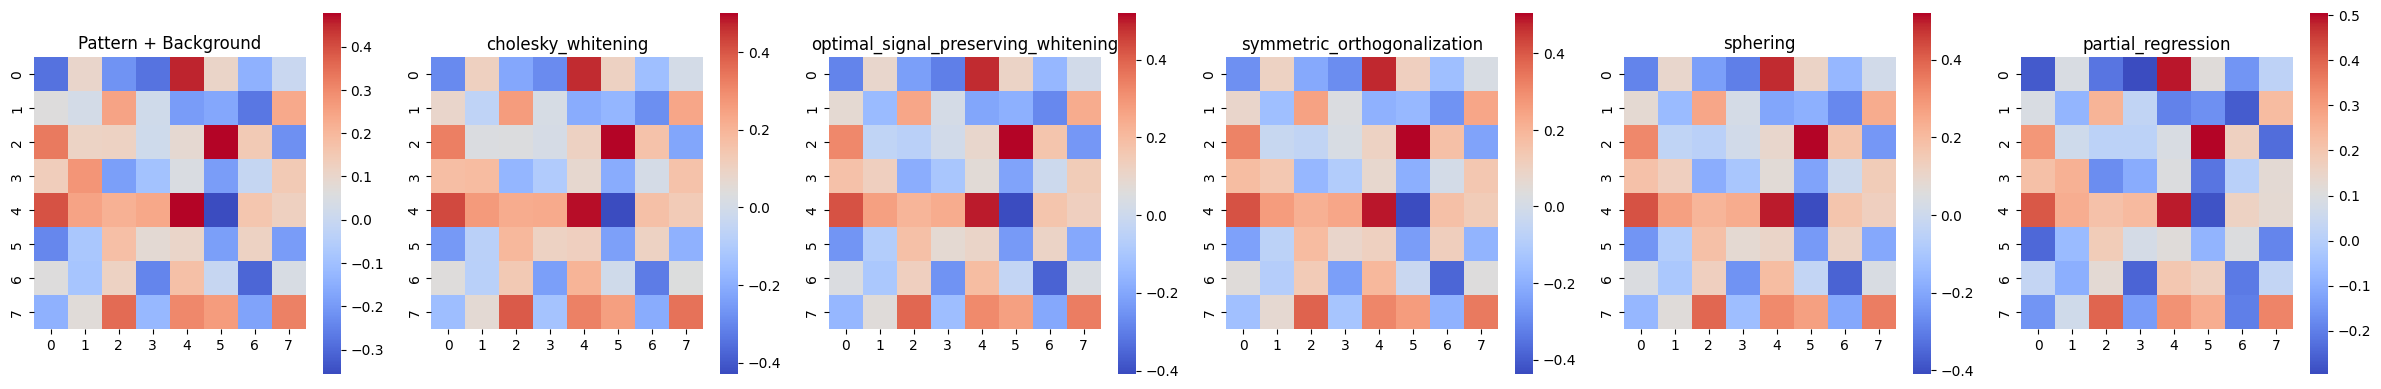

In [34]:
plot_heatmaps_for_index(0,  'linear', 'uncorrelated', 0.18, 1)
plot_heatmaps_for_index(0,  'linear', 'uncorrelated', 0.18, 2)
plot_heatmaps_for_index(0,  'linear', 'uncorrelated', 0.18, 3)
plot_heatmaps_for_index(0,  'linear', 'uncorrelated', 0.18, 4)
plot_heatmaps_for_index(0,  'linear', 'uncorrelated', 0.18, 5)

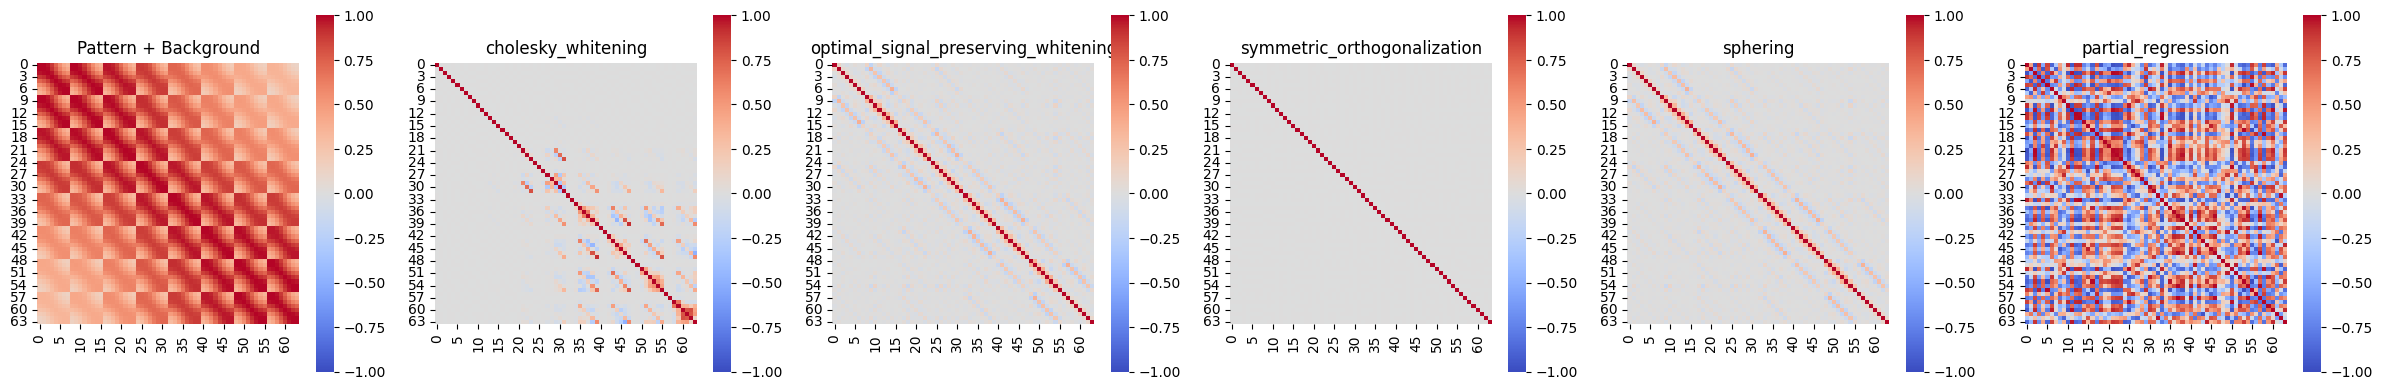

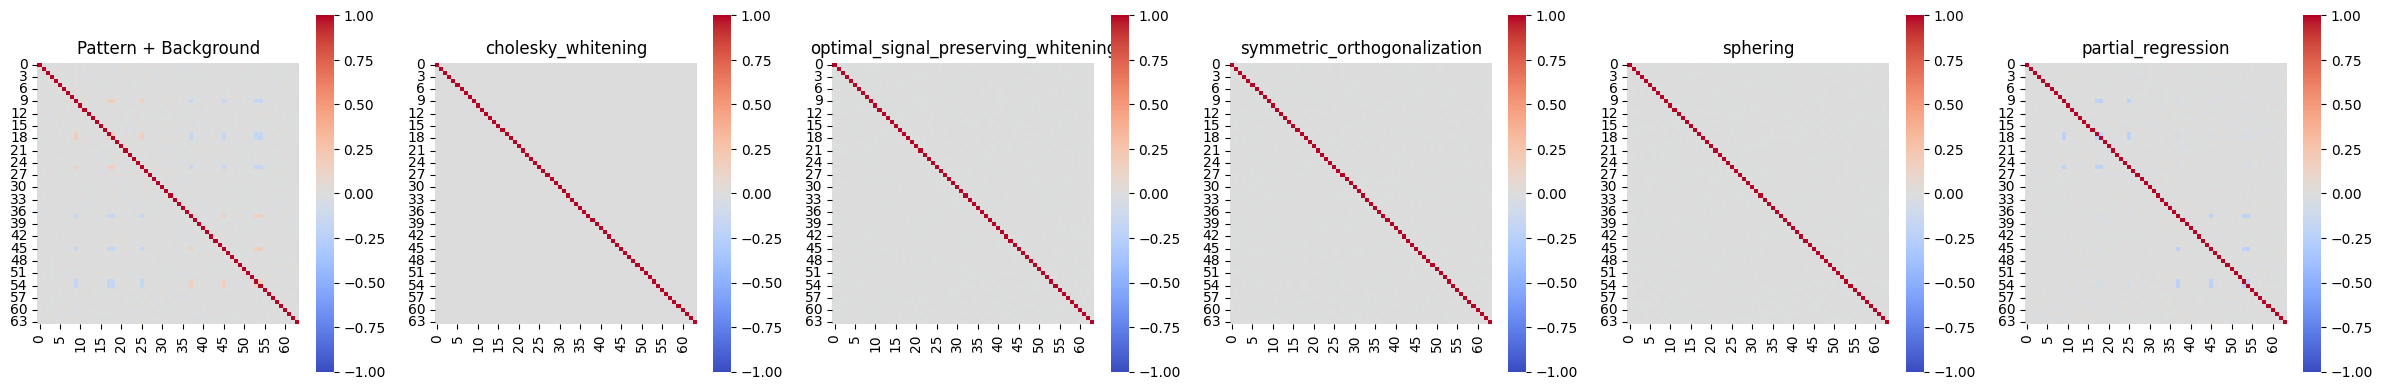

In [35]:
plot_correlation_matrices(0, 'linear', 'correlated', 0.0125
                        )
plot_correlation_matrices(0, 'linear', 'uncorrelated', 0.18)

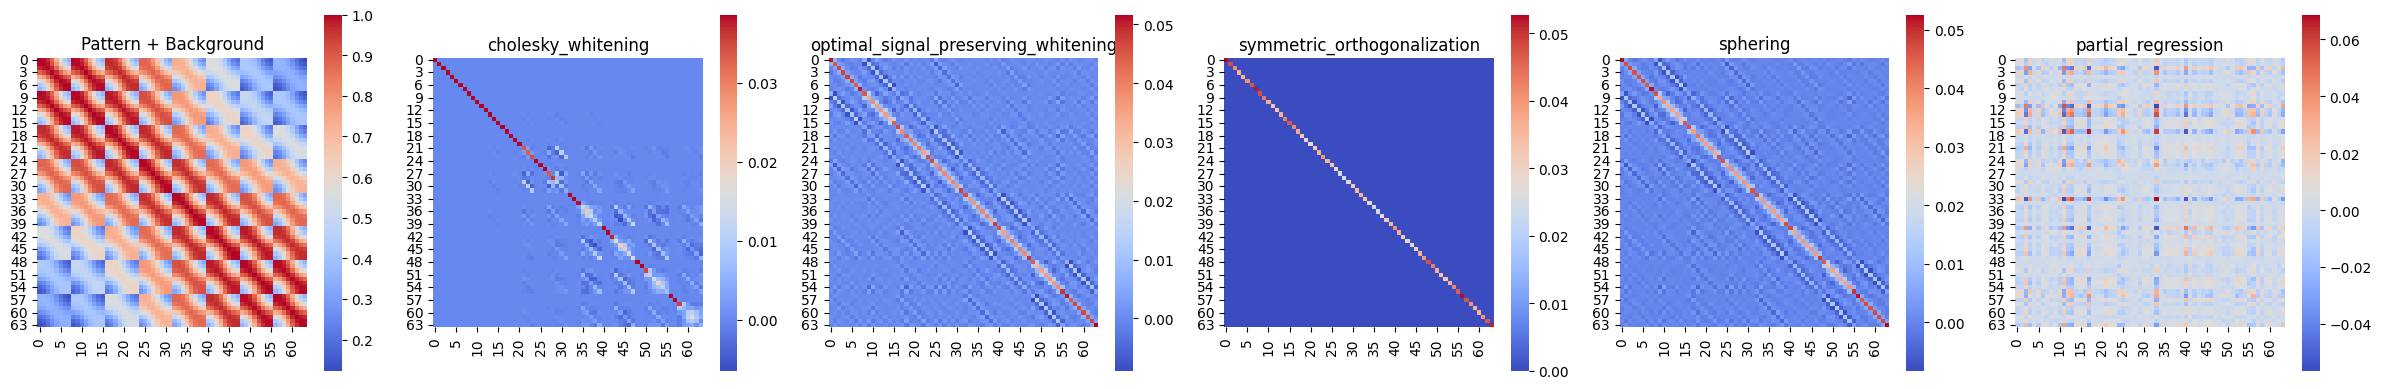

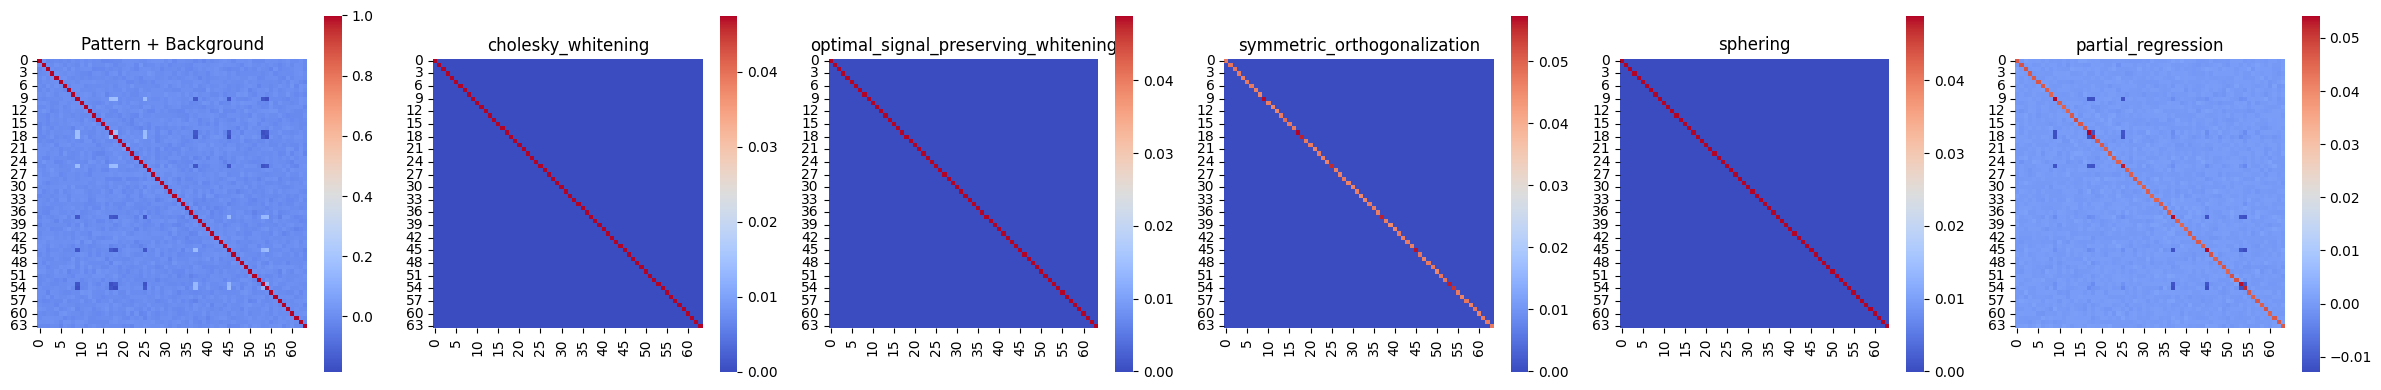

In [36]:
plot_covariance_matrices(0, 'linear', 'correlated', 0.0125)
plot_covariance_matrices(0, 'linear', 'uncorrelated', 0.18)

# xor

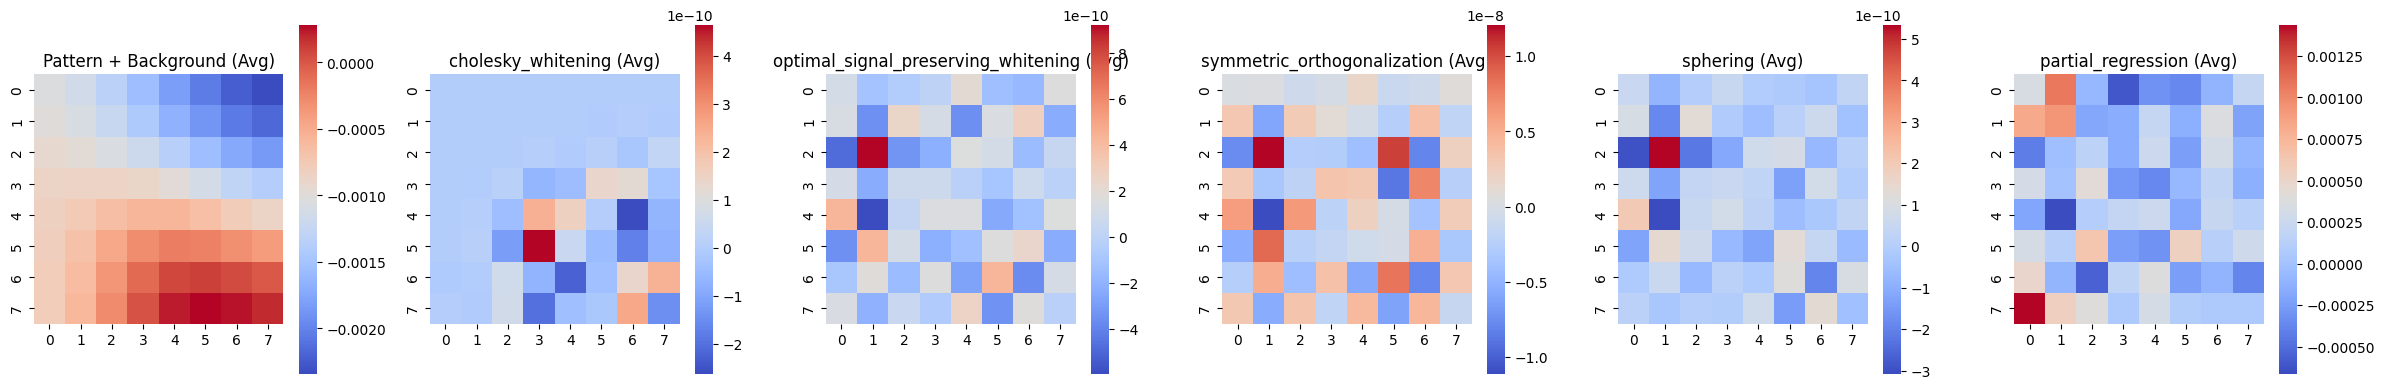

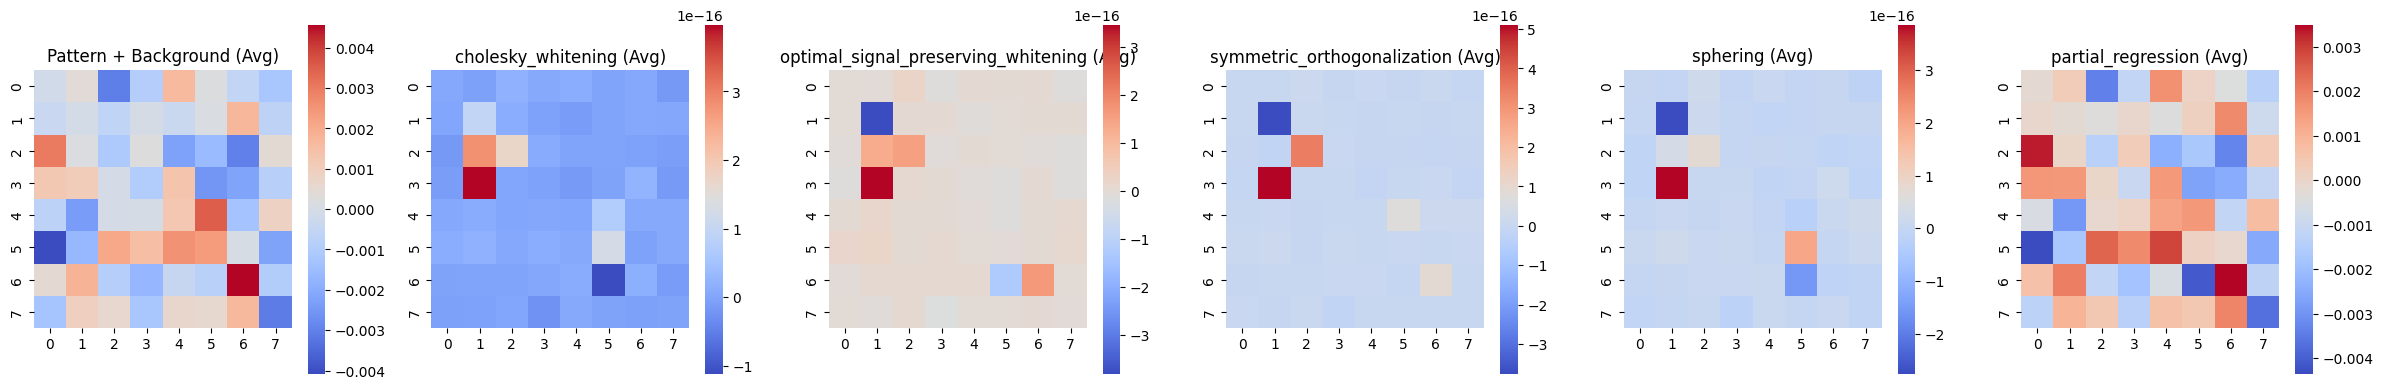

In [37]:
plot_average_heatmaps(0, 'xor', 'correlated', 0.15)
plot_average_heatmaps(0, 'xor', 'uncorrelated', 0.35)

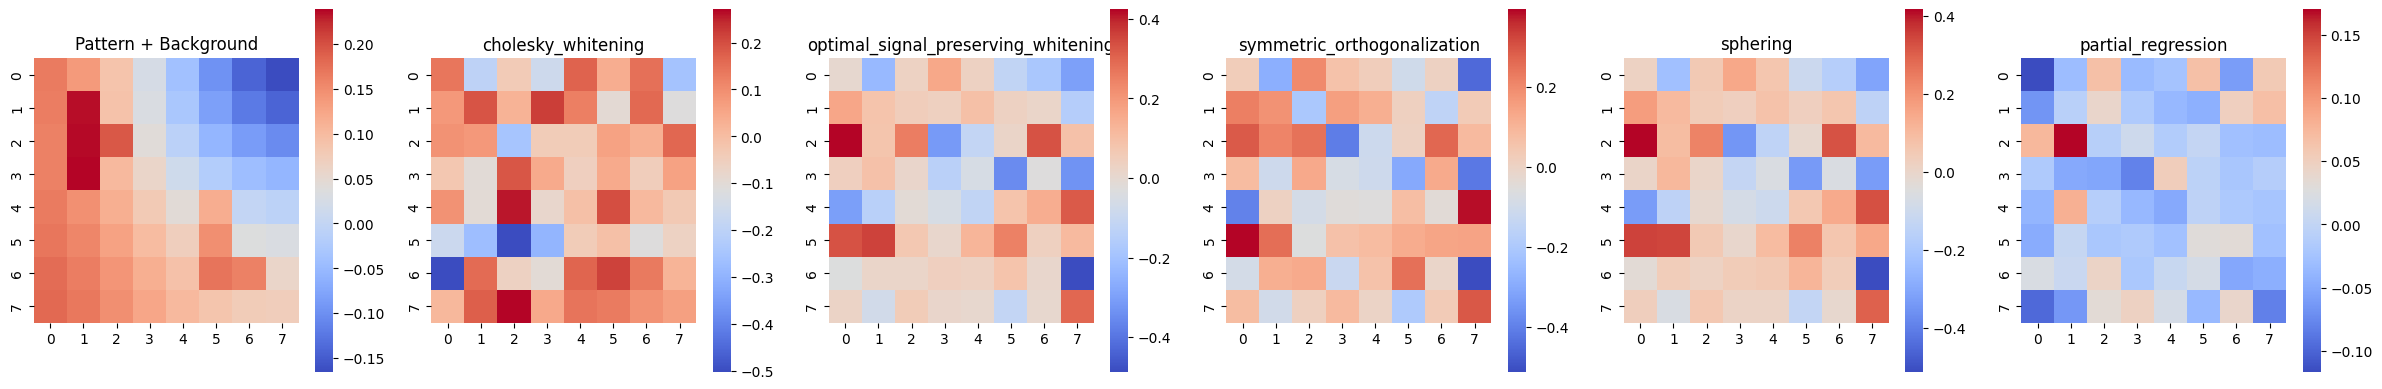

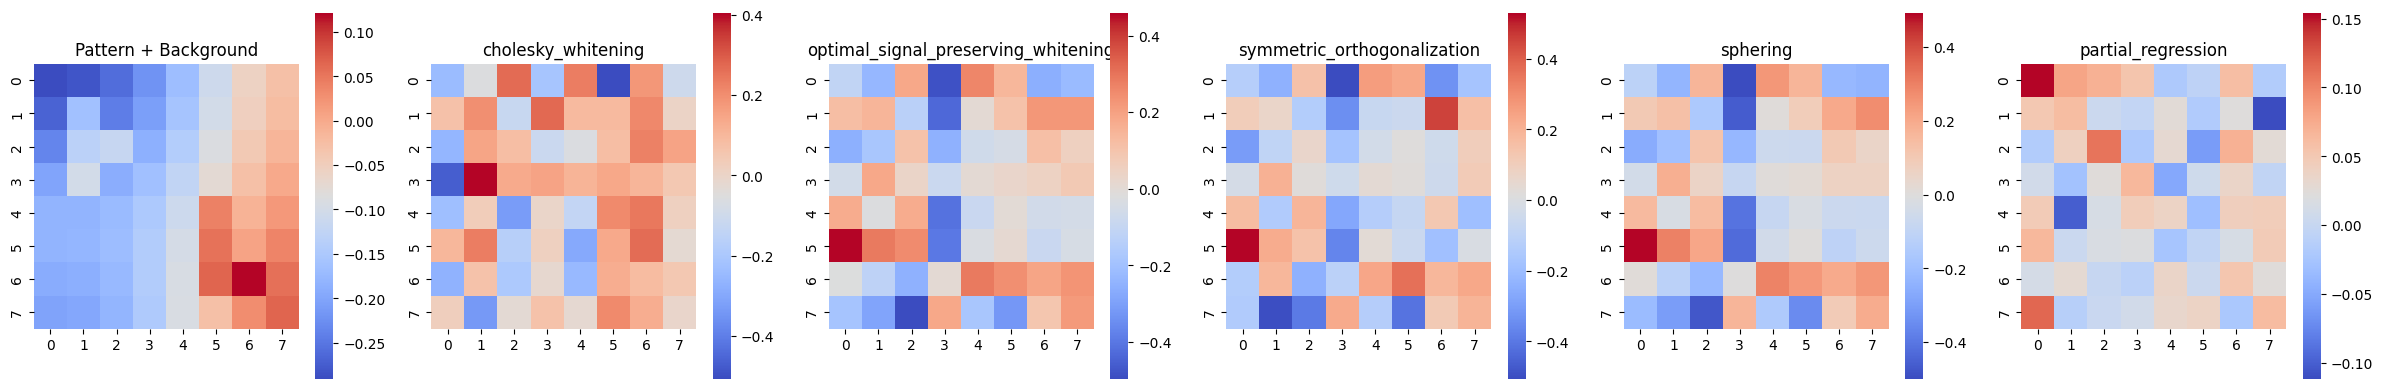

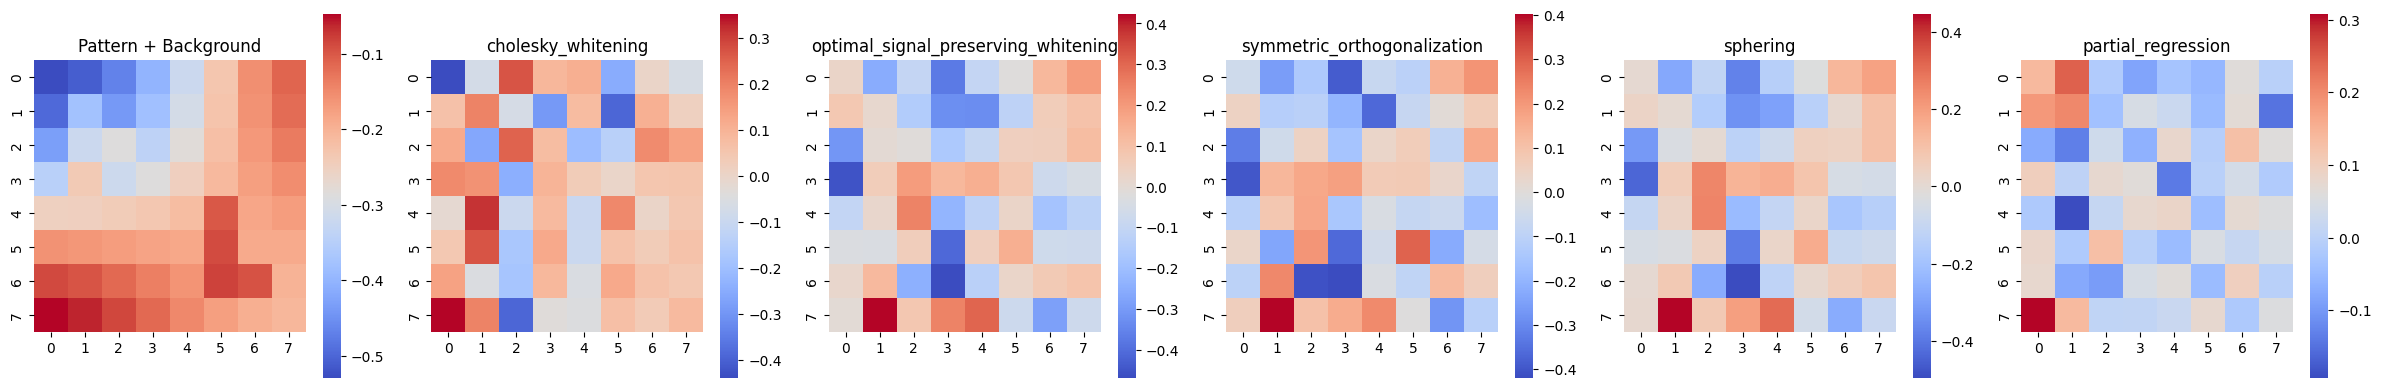

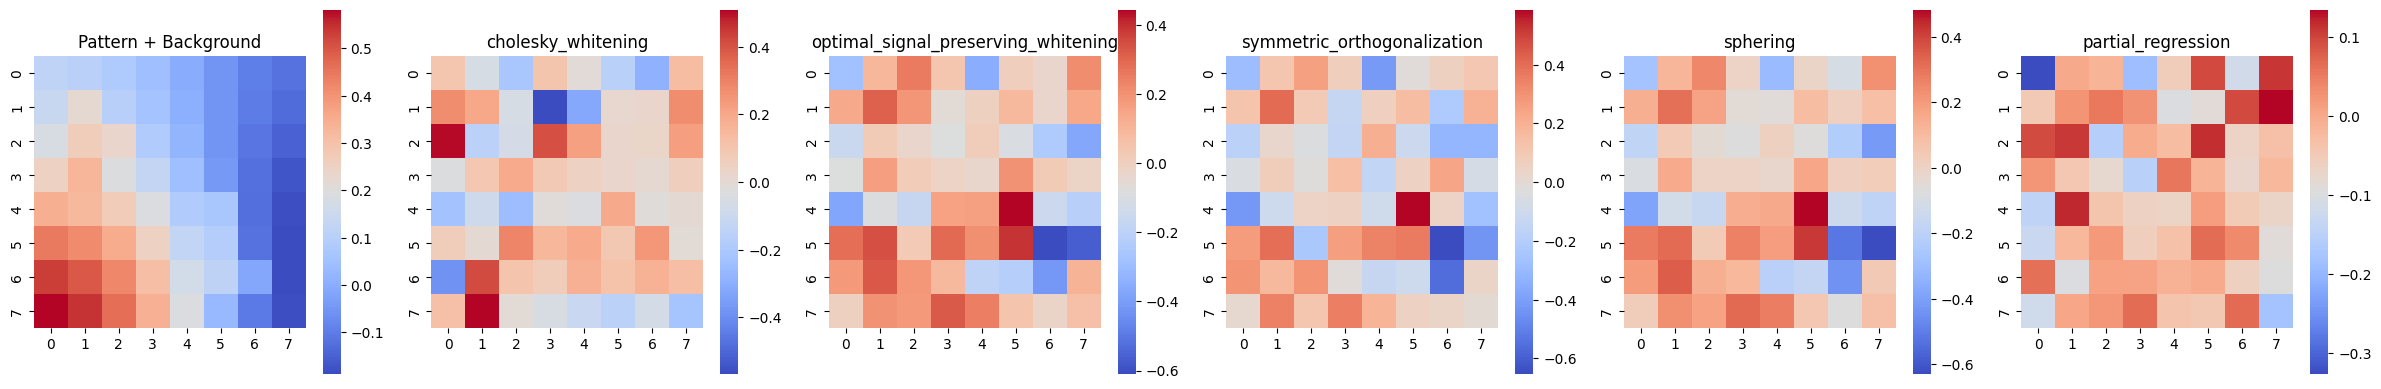

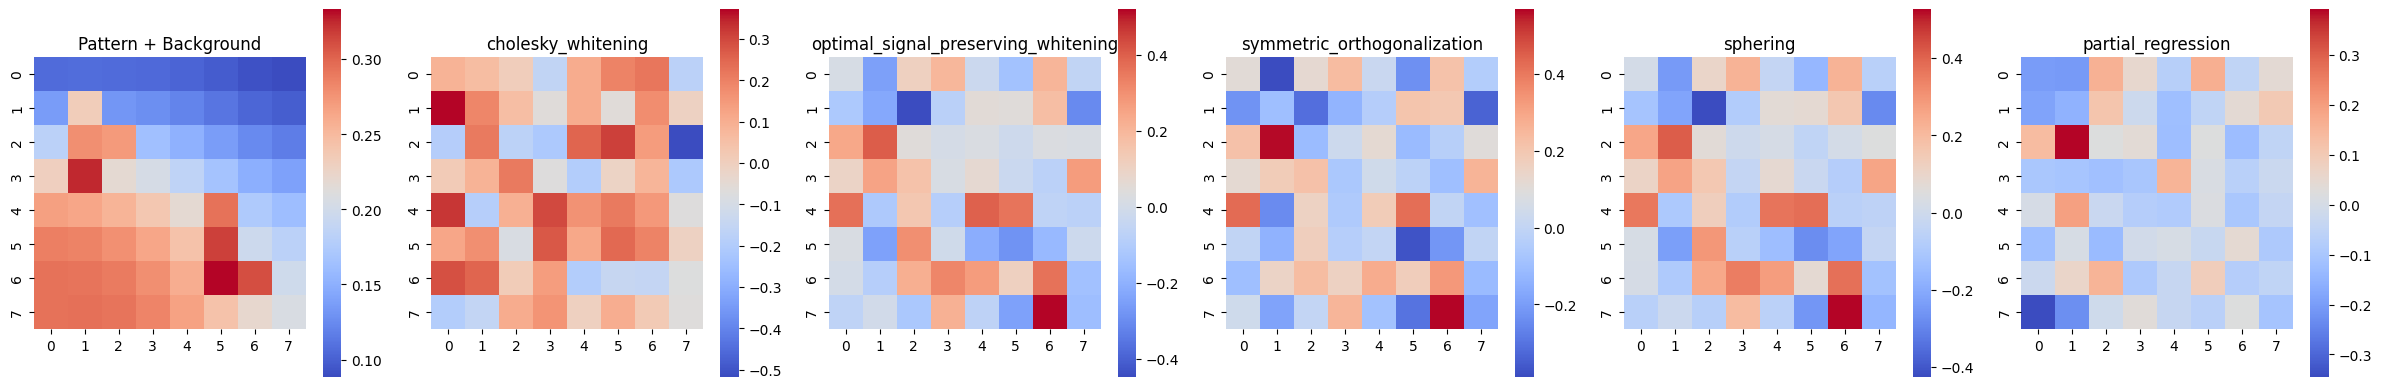

In [38]:
plot_heatmaps_for_index(0,  'xor', 'correlated', 0.15, 1)
plot_heatmaps_for_index(0,  'xor', 'correlated', 0.15, 2)
plot_heatmaps_for_index(0,  'xor', 'correlated', 0.15, 3)
plot_heatmaps_for_index(0,  'xor', 'correlated', 0.15, 4)
plot_heatmaps_for_index(0,  'xor', 'correlated', 0.15, 5)

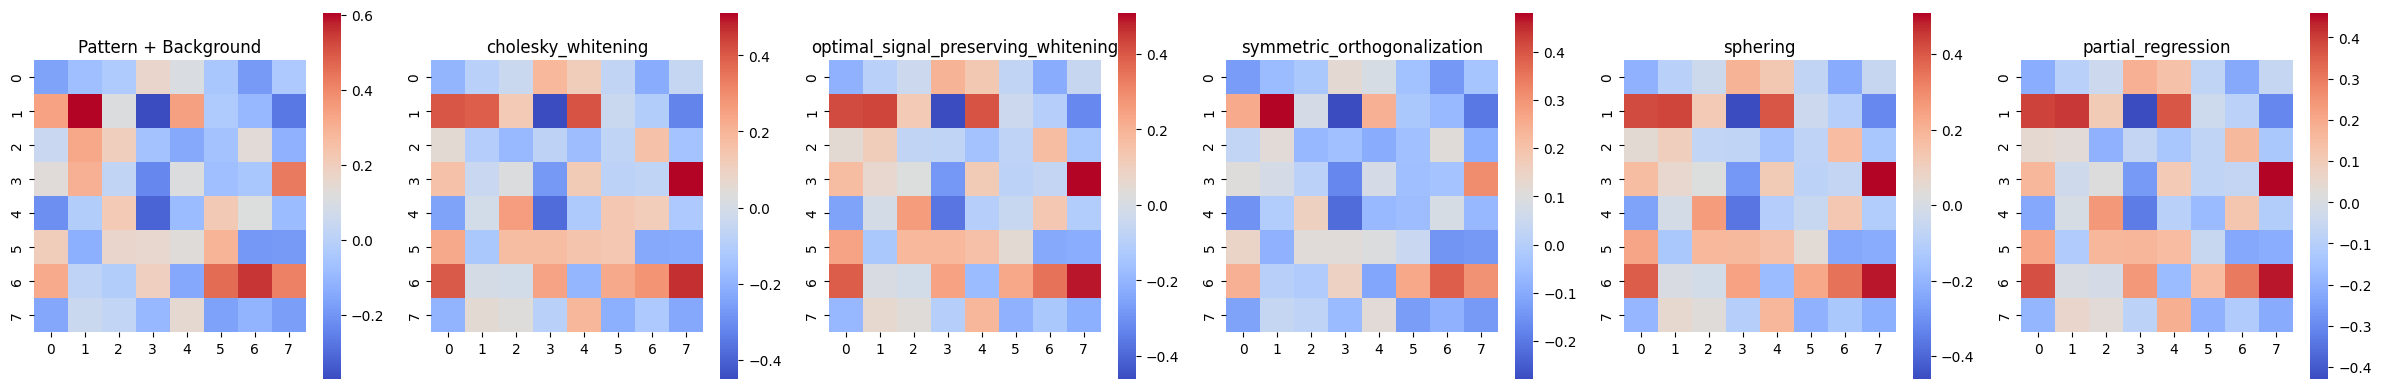

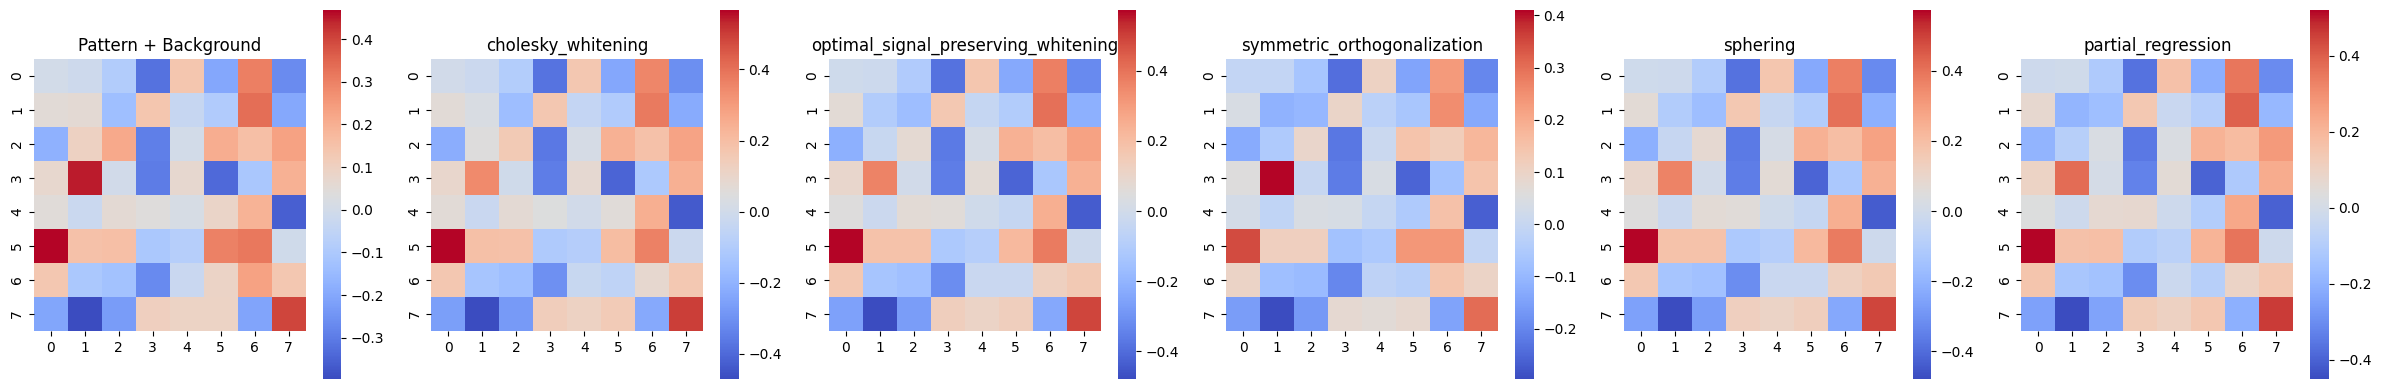

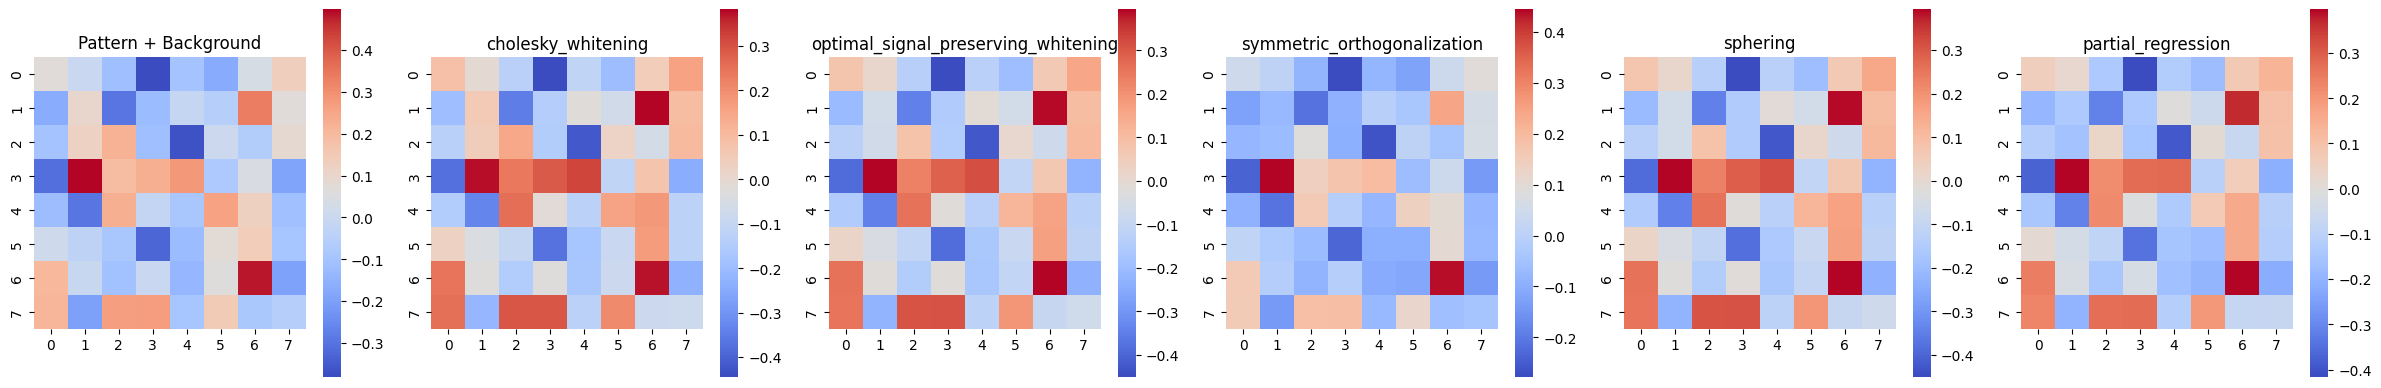

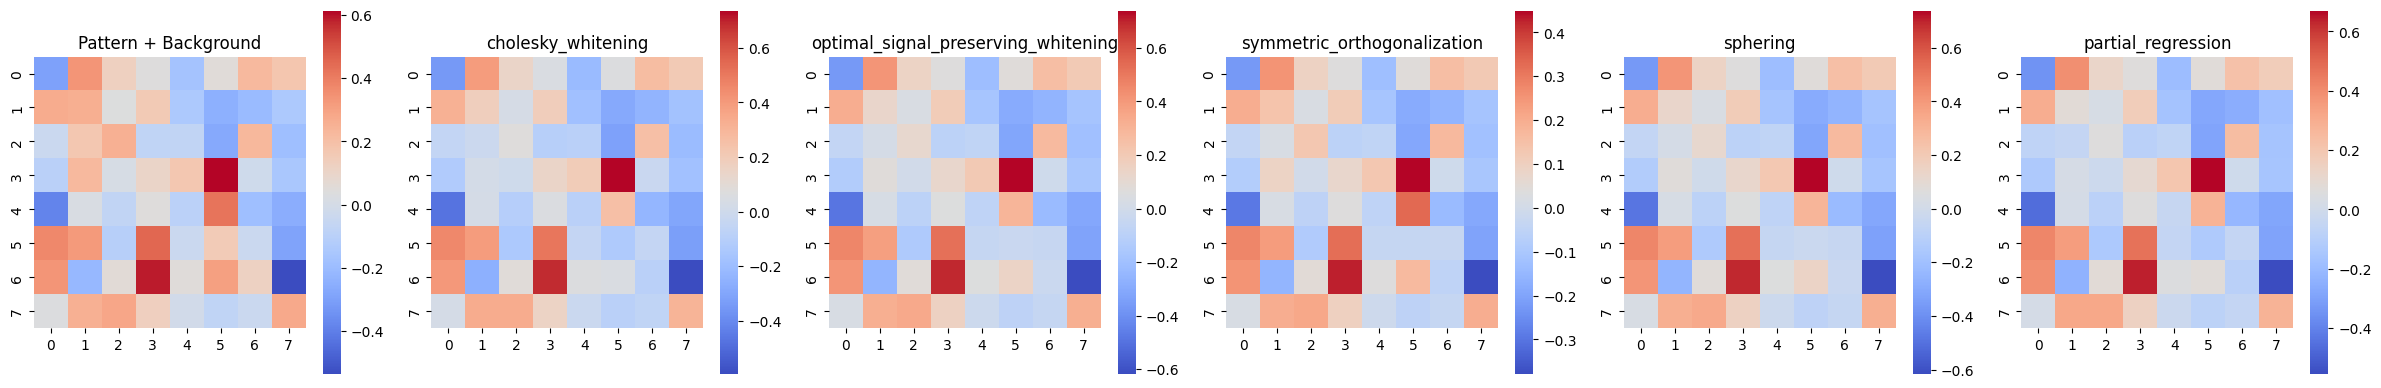

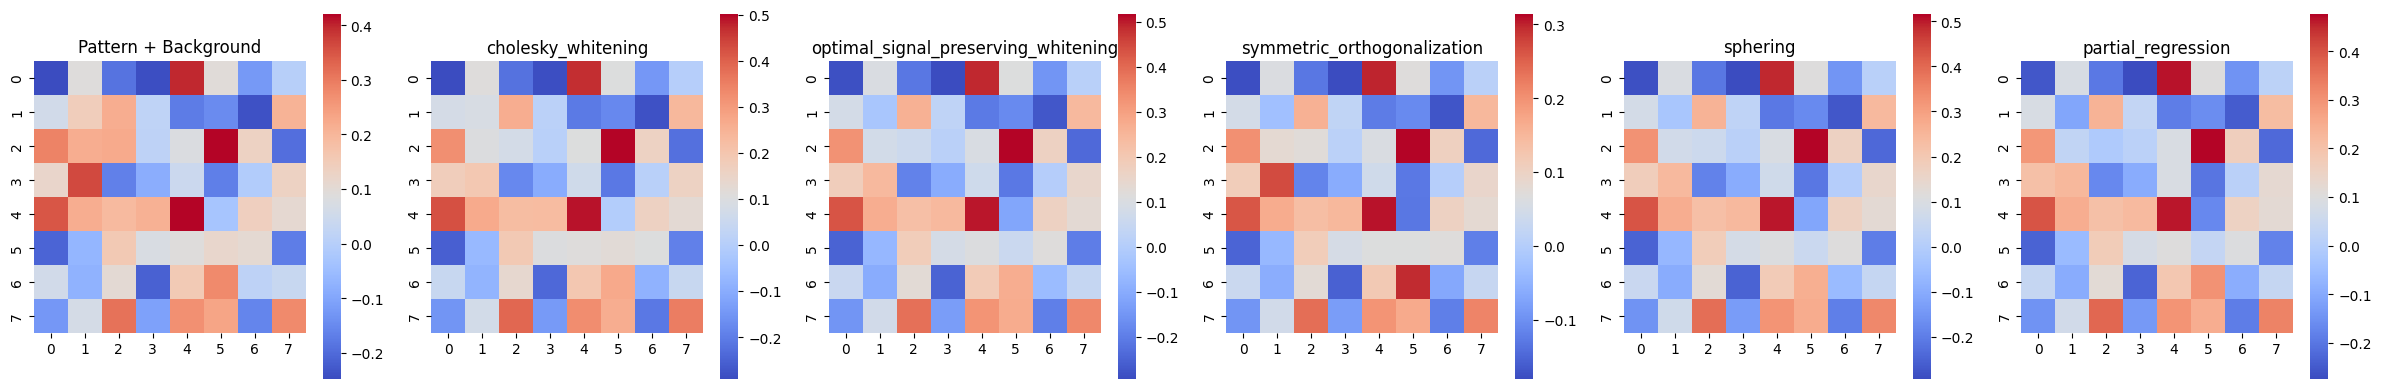

In [39]:
plot_heatmaps_for_index(0,  'xor', 'uncorrelated', 0.35, 1)
plot_heatmaps_for_index(0,  'xor', 'uncorrelated', 0.35, 2)
plot_heatmaps_for_index(0,  'xor', 'uncorrelated', 0.35, 3)
plot_heatmaps_for_index(0,  'xor', 'uncorrelated', 0.35, 4)
plot_heatmaps_for_index(0,  'xor', 'uncorrelated', 0.35, 5)

KeyError: 'experiment_0_pattern_plus_background_xor_correlated_alpha=0.7'

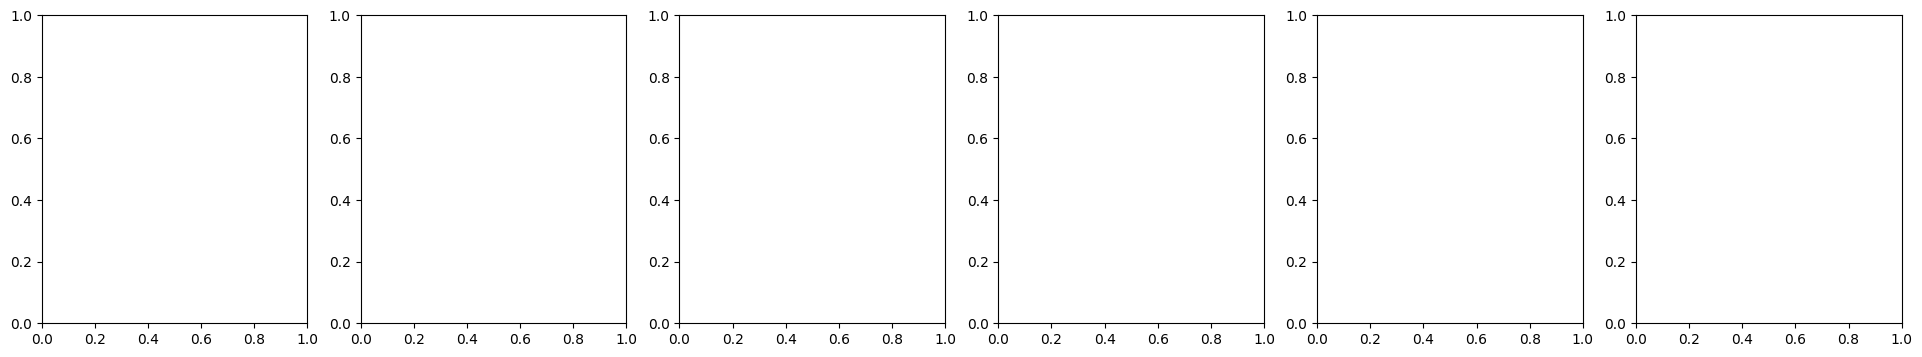

In [40]:
plot_correlation_matrices(0, 'xor', 'correlated', 0.7)
plot_correlation_matrices(0, 'xor', 'uncorrelated', 0.35)

In [ ]:
plot_covariance_matrices(0, 'xor', 'correlated', 0.15)
plot_covariance_matrices(0, 'xor', 'uncorrelated', 0.35)